# 서약
* 당연한 것을 아래와 같이 한번 다지고 가도록 하겠습니다. 아래 보고서는 **본인의 힘만으로 작성**해야하며, 다른 수강생에게 직접적인 질문, 복사 하는 행위는 모두 금지합니다 
  * 예를 들어서, 본 프로젝트의 코드 셀을 완성하는데 직접적인 질문 또는 복사하는 경우는 모두 금지합니다
  * 수업에서 제공한 코드, 노트북은 모두 재활용가능하며, 카피로 규정하지 않습니다
  * 수업 자료 이외에 참고자료가 있다면, 출처와 사용 부분에 모두 표시하는 경우는 모두 합당한 자료로 인정하겠습니다
  
* 위에 대해서 모두 이해하고 동의했다면, 아래 `서약글`에 다음을 작성해주세요:

"본인은 위 서약글을 이해하고 동의하며, 프로젝트를 수행하는데 있어서 반칙을 할 경우 (제공자 포함) 본 프로젝트에 대한 점수가 반영되지 않는다는 것에 동의 합니다."

**서약서**

이름: 신유승

학번: 20155326

서약글:  본인은 위 서약글을 이해하고 동의하며, 프로젝트를 수행하는데 있어서 반칙을 할 경우(제공자 포함)본 프로젝트에 대한 점수가 반영되지 않는다는 것에 동의합니다.

# Final Project 

## Project: 새 품종 분류하기

## Due date: 2021.06.15

---

* 아래 여러 셀에서 코드를 완성하는 부분을 수행하고, 설명을 요구하는 부분은 보고서에 설명을 최대한 자세하게 적어주세요. 기준은 본인이 이해하고 있다는 것을 표현할 수 있는 부분을 모두 적으시면 됩니다.
  * 답을 작성하는 원칙은 **보고서**를 작성한다고 생각하시면 됩니다
  * 내가 알고 있는 부분을 충실하게 **글로 표현** 하는 것 또한 중요한 연습입니다 
  * 코드 작성은 **주석**으로 설명하시기 바랍니다
  
  
> **제출방법**: 
* 보고서에는 코드 캡쳐 첨부이외에도, 각 코드를 작성하는 방법론과 설명을 작성해야하는 **서술형 문제**도 포함되어 있습니다.
* 서술형 문제는 채점하는 중요한 기준이 됩니다. 성실하게 작성해주세요.
* 서술형 문제에 대한 답변은 첨부된 보고서에 작성하면 됩니다. 


### 목표: 앱을 위한 인공지능 알고리즘 개발 ^ㅡ^
* 본 보고서에서는 모바일/웹앱을 위한 인공지능 알고리즘을 개발하라는 업무를 부여받았다고 가정합니다
* 프로젝트가 완성본은, 사용자가 제공하는 image를 받아서 새의 종(種)을 예측합니다


---

## Step 0: Import library

- 필요하다 생각되는 라이브러리를 미리 import해 놓은 항목입니다.(참고)
- 필요 없는 라이브러리를 제거하거나 필요한 라이브러리를 추가하셔도 됩니다.

In [3]:
import shutil
import os
import glob
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd

from pathlib import Path
from collections import OrderedDict
from torch.utils.data.sampler import SubsetRandomSampler

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset,DataLoader

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
# Test for Cuda

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
#train_on_gpu = False

if not train_on_gpu:
    device = 'cpu'
    print('CUDA is not available.  Training on CPU ...')
else:
    device = 'cuda'
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Step 1: Dataset 준비하기

In [5]:
# 이미지 리사이즈 및 정규화
transform_train = transforms.Compose([
    #transforms.Resize((128, 128)),
    transforms.RandomAffine(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
    transforms.RandomRotation(10),
    #transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    #transforms.RandomCrop(100),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomGrayscale(p=0.2),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


transform_val = transforms.Compose([
    transforms.RandomCrop(100),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


# dataset 준비
train_dir = "./imgs/train"

train_data = torchvision.datasets.ImageFolder(root=train_dir,transform=transform_train)
valid_data = torchvision.datasets.ImageFolder(root=train_dir,transform=transform_val)



class_names = train_data.classes

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.2*num_train))

np.random.shuffle(indices)

# dataset_sizes = {}
# dataset_sizes["train"] = int(0.8 * len(train_data))
# dataset_sizes["val"] = len(train_data) - dataset_sizes["train"]

## Step 2: Dataset 에 대한 Data Loaders 구성

In [6]:
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

dataloaders = {}
dataloaders["train"] = torch.utils.data.DataLoader(train_data,
                                                   batch_size=32,
                                                   sampler=train_sampler,
                                                   num_workers=4,
                                                  )
dataloaders["val"] = torch.utils.data.DataLoader(valid_data,
                                                   batch_size=16,
                                                   sampler=valid_sampler,
                                                   num_workers=4)

# for x in ["train", "val"]:
#     print("Loaded {} images under {}".format(split[x], x))
print("Loaded {} train images".format(len(dataloaders["train"])*32))
print("Loaded {} valid images".format(len(dataloaders["val"])*16))
         
print("Classes: ")
print(class_names)

Loaded 1984 train images
Loaded 496 valid images
Classes: 
['AMERICAN_PIPIT', 'BALTIMORE_ORIOLE', 'BELTED_KINGFISHER', 'BROWN_THRASHER', 'CALIFORNIA_GULL', 'CASPIAN_TERN', 'CRESTED_AUKLET', 'DOWNY_WOODPECKER', 'GRAY_CATBIRD', 'HOODED_MERGANSER', 'INDIGO_BUNTING', 'PURPLE_FINCH', 'RED_HEADED_WOODPECKER', 'RUBY_THROATED_HUMMINGBIRD', 'WHITE_NECKED_RAVEN']


## Visualization (시각화)

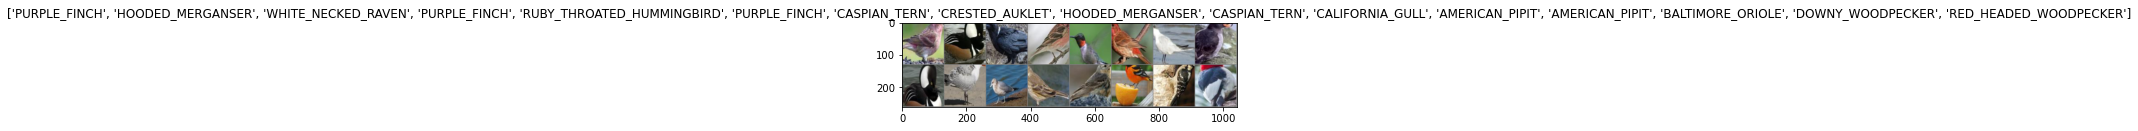

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([.5, .5, .5])
    std = np.array([.5, .5, .5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# 학습 데이터의 배치
inputs, classes = next(iter(dataloaders['val']))

# 배치로부터 격자 형태의 이미지
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Step 3: Neural Network 생성
- Pretrained model을 허용하지 않습니다. (직접 모델을 설계해 주세요)


In [8]:
class USNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Sequential(
            #3x128x128 image
            nn.Conv2d(3,32,3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            #nn.Dropout(0.25),
            
            #32x64x64
            nn.Conv2d(32,64,3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True), 
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.25),
            
            #64x32x32        
            nn.Conv2d(64,128,3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            #nn.Dropout(0.25),
            
            #128*16*16
            nn.Conv2d(128,256,3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.25),
            
            #256*8*8
            nn.Conv2d(256,512,3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            
            #512*4*4
        )
        
            
        self.fc1 = nn.Linear(512*4*4, 4096)
        #self.fc2 = nn.Linear(4096, 1000)
        self.fc2 = nn.Linear(4096, 15)
        self.relu = nn.ReLU(True)
        #dropout layer
        self.dropout = nn.Dropout(0.5)
        self.BN = nn.BatchNorm1d(4096)
        
        
    def forward(self, x):
        x = self.conv(x)
      
        # flatten image layer
        x = x.view(x.size(0), -1) 
        x = self.relu(self.BN(self.fc1(x)))
        x = self.dropout(x)
#         x = self.relu(self.fc2(x))
#         x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
# create a complete my model
model = USNet()

# move tensors to GPU if CUDA is available.
model.to(device)

USNet(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.25, inplace=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d

 ## Step 4: Cost (Loss) Function 과 Optimizer 선택
 
 [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) 및 [optimizer](http://pytorch.org/docs/stable/optim.html)를 선택하여 코드를 완성하세요.
 
 위 링크에서 다양한 Loss Function과 Optimize Function을 확인 할 수 있습니다
 

In [9]:
#코드작성
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-2)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 50], gamma=0.1 )

## Step 5: 구성한 모델에 대한 Train and Validate 진행

* 코드 전체를 주석으로 설명하세요
* Epoch 별로 Loss나 Accuracy를 출력하여 학습 진행 과정을 확인 할 수 있도록 합니다
* 출력 예시는 주어지나 정해진 형식은 없습니다
* 최적의 모델 저장

예제:
```
Started Training...
Epoch: 1 	Training Loss: 3.317162 	Validation Loss: 4.162958
Epoch: 2 	Training Loss: 2.420140 	Validation Loss: 4.182362
...
...
Finished training
```

In [10]:
from sklearn.model_selection import KFold

def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

In [11]:
from tqdm import tqdm_notebook
from torch.utils.data.sampler import SubsetRandomSampler

#코드작성
# Hyper Parameter tuning
n_epochs = 400
batch_size = 32
num_workers = 0
kf = KFold(n_splits=5, shuffle=True)


for fold, (train_ind, valid_ind) in enumerate(kf.split(train_data)):
    print('Starting fold = ', fold)
    
    # track change in validation loss
    valid_loss_min = np.Inf
    valid_acc_max = 0

    # keep track of training and validation loss
    train_loss = torch.zeros(n_epochs)
    valid_loss = torch.zeros(n_epochs)

    train_acc = torch.zeros(n_epochs)
    valid_acc = torch.zeros(n_epochs)
    
    train_kfold = SubsetRandomSampler(train_ind)
    valid_kfold = SubsetRandomSampler(valid_ind)
    train_loader_kfold = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_kfold, num_workers=num_workers)
    valid_loader_kfold = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, sampler=valid_kfold, num_workers=num_workers)

    model = USNet()
    model.to(device)
    model.apply(reset_weights)
    
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    for i in range(0, n_epochs):
        print('epoch = ', i)

        # train model
        model.train()
        for data, labels in tqdm_notebook(train_loader_kfold):
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            # clear the gradients of all optimized variables

            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model(data)
            # calculate the batch loss
            loss = criterion(logits, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss[i] += loss.item()

            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            train_acc[i] += torch.mean(equals.type(torch.float)).detach().cpu()

        train_loss[i] /= len(train_loader_kfold)
        train_acc[i] /= len(train_loader_kfold)

        # validate the model 
        with torch.no_grad(): 
            model.eval()
            for data, labels in tqdm_notebook(valid_loader_kfold):
                # move tensors to GPU if CUDA is available
                data, labels = data.to(device), labels.to(device)
                # forward pass: compute predicted outputs by passing inputs to the model
                logits = model(data)
                # calculate the batch loss
                loss = criterion(logits, labels)
                # update average validation loss 
                valid_loss[i] += loss.item()

                ps = F.softmax(logits, dim=1)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.reshape(top_class.shape)
                valid_acc[i] += torch.mean(equals.type(torch.float)).detach().cpu()

        # calculate average losses
        valid_loss[i] /= len(valid_loader_kfold)
        valid_acc[i] /= len(valid_loader_kfold)


        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(i, train_loss[i], valid_loss[i]))

        # print training/validation statistics 
        print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(i, train_acc[i], valid_acc[i]))

        # save model if validation loss has decreased
        if valid_loss[i] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss[i]))
            #torch.save(model.state_dict(), 'model_useung.pt')
            fold_model = model.state_dict()
            valid_loss_min = valid_loss[i]   

        # save model if validation accuracy has increased
#         if valid_acc_max <= valid_acc[i]:
#             print('Validation Accuracy increased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_acc_max, valid_acc[i]))
#             fold_model = model.state_dict()
#             valid_acc_max = valid_acc[i]

        
    
    torch.save(fold_model, './fold/model_fold_{}.pt'.format(fold))
    
    
print("...Training Finish")

Starting fold =  0
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1),

<ipython-input-11-62f06a9de8a5>:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data, labels in tqdm_notebook(train_loader_kfold):


  0%|          | 0/62 [00:00<?, ?it/s]

<ipython-input-11-62f06a9de8a5>:70: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data, labels in tqdm_notebook(valid_loader_kfold):


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 0 	Training Loss: 2.002784 	Validation Loss: 2.349373
Epoch: 0 	Training accuracy: 0.367210 	Validation accuracy: 0.299665
Validation loss decreased (inf --> 2.349373).  Saving model ...
epoch =  1


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.332471 	Validation Loss: 2.184611
Epoch: 1 	Training accuracy: 0.581103 	Validation accuracy: 0.382254
Validation loss decreased (2.349373 --> 2.184611).  Saving model ...
epoch =  2


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.091972 	Validation Loss: 1.995038
Epoch: 2 	Training accuracy: 0.658541 	Validation accuracy: 0.365234
Validation loss decreased (2.184611 --> 1.995038).  Saving model ...
epoch =  3


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.926849 	Validation Loss: 1.977956
Epoch: 3 	Training accuracy: 0.704316 	Validation accuracy: 0.418248
Validation loss decreased (1.995038 --> 1.977956).  Saving model ...
epoch =  4


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.817910 	Validation Loss: 2.311348
Epoch: 4 	Training accuracy: 0.736987 	Validation accuracy: 0.344029
epoch =  5


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.749879 	Validation Loss: 2.128247
Epoch: 5 	Training accuracy: 0.754399 	Validation accuracy: 0.409877
epoch =  6


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.688357 	Validation Loss: 2.298517
Epoch: 6 	Training accuracy: 0.783953 	Validation accuracy: 0.380859
epoch =  7


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.630561 	Validation Loss: 1.994584
Epoch: 7 	Training accuracy: 0.793667 	Validation accuracy: 0.416574
epoch =  8


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.599742 	Validation Loss: 2.056144
Epoch: 8 	Training accuracy: 0.814562 	Validation accuracy: 0.434431
epoch =  9


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.552692 	Validation Loss: 2.037293
Epoch: 9 	Training accuracy: 0.821939 	Validation accuracy: 0.486328
epoch =  10


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.514999 	Validation Loss: 2.053035
Epoch: 10 	Training accuracy: 0.839764 	Validation accuracy: 0.478795
epoch =  11


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.447061 	Validation Loss: 1.926165
Epoch: 11 	Training accuracy: 0.848882 	Validation accuracy: 0.490234
Validation loss decreased (1.977956 --> 1.926165).  Saving model ...
epoch =  12


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.481582 	Validation Loss: 2.101350
Epoch: 12 	Training accuracy: 0.839076 	Validation accuracy: 0.472656
epoch =  13


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.418201 	Validation Loss: 1.540762
Epoch: 13 	Training accuracy: 0.873075 	Validation accuracy: 0.559989
Validation loss decreased (1.926165 --> 1.540762).  Saving model ...
epoch =  14


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.442779 	Validation Loss: 1.654584
Epoch: 14 	Training accuracy: 0.845766 	Validation accuracy: 0.568080
epoch =  15


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.374676 	Validation Loss: 1.897016
Epoch: 15 	Training accuracy: 0.873259 	Validation accuracy: 0.500558
epoch =  16


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.331777 	Validation Loss: 1.669572
Epoch: 16 	Training accuracy: 0.893191 	Validation accuracy: 0.540737
epoch =  17


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.336427 	Validation Loss: 1.796431
Epoch: 17 	Training accuracy: 0.891725 	Validation accuracy: 0.565290
epoch =  18


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.328575 	Validation Loss: 2.032596
Epoch: 18 	Training accuracy: 0.893924 	Validation accuracy: 0.500837
epoch =  19


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.312203 	Validation Loss: 1.958616
Epoch: 19 	Training accuracy: 0.901026 	Validation accuracy: 0.503906
epoch =  20


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.300540 	Validation Loss: 1.754882
Epoch: 20 	Training accuracy: 0.894703 	Validation accuracy: 0.591518
epoch =  21


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.243600 	Validation Loss: 1.766051
Epoch: 21 	Training accuracy: 0.923662 	Validation accuracy: 0.536272
epoch =  22


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.269726 	Validation Loss: 1.870866
Epoch: 22 	Training accuracy: 0.913581 	Validation accuracy: 0.546038
epoch =  23


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.263130 	Validation Loss: 1.599323
Epoch: 23 	Training accuracy: 0.916880 	Validation accuracy: 0.581473
epoch =  24


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.233295 	Validation Loss: 1.644676
Epoch: 24 	Training accuracy: 0.920959 	Validation accuracy: 0.594866
epoch =  25


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.224105 	Validation Loss: 1.792949
Epoch: 25 	Training accuracy: 0.929481 	Validation accuracy: 0.580078
epoch =  26


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.209481 	Validation Loss: 1.952112
Epoch: 26 	Training accuracy: 0.928702 	Validation accuracy: 0.538504
epoch =  27


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.203128 	Validation Loss: 1.827062
Epoch: 27 	Training accuracy: 0.938279 	Validation accuracy: 0.562221
epoch =  28


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.193406 	Validation Loss: 1.752666
Epoch: 28 	Training accuracy: 0.942082 	Validation accuracy: 0.597656
epoch =  29


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.195252 	Validation Loss: 1.718570
Epoch: 29 	Training accuracy: 0.937821 	Validation accuracy: 0.576172
epoch =  30


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.167176 	Validation Loss: 1.911658
Epoch: 30 	Training accuracy: 0.942540 	Validation accuracy: 0.557199
epoch =  31


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 0.157025 	Validation Loss: 1.668449
Epoch: 31 	Training accuracy: 0.948405 	Validation accuracy: 0.598772
epoch =  32


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 0.140922 	Validation Loss: 1.522484
Epoch: 32 	Training accuracy: 0.962198 	Validation accuracy: 0.636440
Validation loss decreased (1.540762 --> 1.522484).  Saving model ...
epoch =  33


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 0.151166 	Validation Loss: 1.538698
Epoch: 33 	Training accuracy: 0.955462 	Validation accuracy: 0.598772
epoch =  34


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 0.150637 	Validation Loss: 1.786336
Epoch: 34 	Training accuracy: 0.947397 	Validation accuracy: 0.601562
epoch =  35


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 0.144382 	Validation Loss: 1.336700
Epoch: 35 	Training accuracy: 0.953171 	Validation accuracy: 0.670480
Validation loss decreased (1.522484 --> 1.336700).  Saving model ...
epoch =  36


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 0.121130 	Validation Loss: 1.546844
Epoch: 36 	Training accuracy: 0.961190 	Validation accuracy: 0.632254
epoch =  37


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 0.127953 	Validation Loss: 1.365411
Epoch: 37 	Training accuracy: 0.959448 	Validation accuracy: 0.653460
epoch =  38


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 0.124118 	Validation Loss: 1.717472
Epoch: 38 	Training accuracy: 0.963985 	Validation accuracy: 0.603795
epoch =  39


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 0.124295 	Validation Loss: 1.578571
Epoch: 39 	Training accuracy: 0.959677 	Validation accuracy: 0.628627
epoch =  40


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 0.116730 	Validation Loss: 1.605477
Epoch: 40 	Training accuracy: 0.967788 	Validation accuracy: 0.629185
epoch =  41


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 41 	Training Loss: 0.118020 	Validation Loss: 1.765767
Epoch: 41 	Training accuracy: 0.964993 	Validation accuracy: 0.622210
epoch =  42


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 42 	Training Loss: 0.101767 	Validation Loss: 1.545832
Epoch: 42 	Training accuracy: 0.976815 	Validation accuracy: 0.629464
epoch =  43


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 43 	Training Loss: 0.116586 	Validation Loss: 1.427632
Epoch: 43 	Training accuracy: 0.968017 	Validation accuracy: 0.647600
epoch =  44


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 44 	Training Loss: 0.097742 	Validation Loss: 1.748279
Epoch: 44 	Training accuracy: 0.971545 	Validation accuracy: 0.594308
epoch =  45


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 45 	Training Loss: 0.106952 	Validation Loss: 1.501902
Epoch: 45 	Training accuracy: 0.963481 	Validation accuracy: 0.651507
epoch =  46


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 46 	Training Loss: 0.095192 	Validation Loss: 1.554297
Epoch: 46 	Training accuracy: 0.975302 	Validation accuracy: 0.640346
epoch =  47


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 47 	Training Loss: 0.120373 	Validation Loss: 1.402350
Epoch: 47 	Training accuracy: 0.958440 	Validation accuracy: 0.648158
epoch =  48


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 48 	Training Loss: 0.096004 	Validation Loss: 1.711076
Epoch: 48 	Training accuracy: 0.976081 	Validation accuracy: 0.600725
epoch =  49


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 49 	Training Loss: 0.106754 	Validation Loss: 1.553059
Epoch: 49 	Training accuracy: 0.964260 	Validation accuracy: 0.645368
epoch =  50


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 50 	Training Loss: 0.081542 	Validation Loss: 1.744109
Epoch: 50 	Training accuracy: 0.979106 	Validation accuracy: 0.632533
epoch =  51


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 51 	Training Loss: 0.083735 	Validation Loss: 1.770000
Epoch: 51 	Training accuracy: 0.973790 	Validation accuracy: 0.613560
epoch =  52


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 52 	Training Loss: 0.078626 	Validation Loss: 1.710271
Epoch: 52 	Training accuracy: 0.977593 	Validation accuracy: 0.602121
epoch =  53


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 53 	Training Loss: 0.077697 	Validation Loss: 1.699423
Epoch: 53 	Training accuracy: 0.979335 	Validation accuracy: 0.633092
epoch =  54


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 54 	Training Loss: 0.084099 	Validation Loss: 1.471188
Epoch: 54 	Training accuracy: 0.975852 	Validation accuracy: 0.667132
epoch =  55


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 55 	Training Loss: 0.072050 	Validation Loss: 1.810413
Epoch: 55 	Training accuracy: 0.980389 	Validation accuracy: 0.640625
epoch =  56


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 56 	Training Loss: 0.064221 	Validation Loss: 1.863704
Epoch: 56 	Training accuracy: 0.983367 	Validation accuracy: 0.633650
epoch =  57


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 57 	Training Loss: 0.070890 	Validation Loss: 1.617483
Epoch: 57 	Training accuracy: 0.977089 	Validation accuracy: 0.641462
epoch =  58


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 58 	Training Loss: 0.053953 	Validation Loss: 1.415023
Epoch: 58 	Training accuracy: 0.985154 	Validation accuracy: 0.652065
epoch =  59


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 59 	Training Loss: 0.070783 	Validation Loss: 1.692361
Epoch: 59 	Training accuracy: 0.981351 	Validation accuracy: 0.631975
epoch =  60


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 60 	Training Loss: 0.069713 	Validation Loss: 1.748610
Epoch: 60 	Training accuracy: 0.980847 	Validation accuracy: 0.631417
epoch =  61


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 61 	Training Loss: 0.056568 	Validation Loss: 1.763791
Epoch: 61 	Training accuracy: 0.985887 	Validation accuracy: 0.646205
epoch =  62


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 62 	Training Loss: 0.068112 	Validation Loss: 1.971391
Epoch: 62 	Training accuracy: 0.979610 	Validation accuracy: 0.598772
epoch =  63


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 63 	Training Loss: 0.060976 	Validation Loss: 1.711060
Epoch: 63 	Training accuracy: 0.983367 	Validation accuracy: 0.644810
epoch =  64


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 64 	Training Loss: 0.070511 	Validation Loss: 1.394063
Epoch: 64 	Training accuracy: 0.979335 	Validation accuracy: 0.689732
epoch =  65


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 65 	Training Loss: 0.052171 	Validation Loss: 1.531799
Epoch: 65 	Training accuracy: 0.987399 	Validation accuracy: 0.688616
epoch =  66


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 66 	Training Loss: 0.050383 	Validation Loss: 1.643078
Epoch: 66 	Training accuracy: 0.986666 	Validation accuracy: 0.629464
epoch =  67


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 67 	Training Loss: 0.053915 	Validation Loss: 1.643503
Epoch: 67 	Training accuracy: 0.985429 	Validation accuracy: 0.648996
epoch =  68


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 68 	Training Loss: 0.053277 	Validation Loss: 1.604973
Epoch: 68 	Training accuracy: 0.985383 	Validation accuracy: 0.670201
epoch =  69


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 69 	Training Loss: 0.048877 	Validation Loss: 1.644485
Epoch: 69 	Training accuracy: 0.988407 	Validation accuracy: 0.654576
epoch =  70


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 70 	Training Loss: 0.060710 	Validation Loss: 1.478855
Epoch: 70 	Training accuracy: 0.981351 	Validation accuracy: 0.655413
epoch =  71


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 71 	Training Loss: 0.044563 	Validation Loss: 1.607178
Epoch: 71 	Training accuracy: 0.987903 	Validation accuracy: 0.643973
epoch =  72


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 72 	Training Loss: 0.048058 	Validation Loss: 1.648114
Epoch: 72 	Training accuracy: 0.984696 	Validation accuracy: 0.660435
epoch =  73


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 73 	Training Loss: 0.045532 	Validation Loss: 1.813641
Epoch: 73 	Training accuracy: 0.990423 	Validation accuracy: 0.650949
epoch =  74


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 74 	Training Loss: 0.055764 	Validation Loss: 1.415444
Epoch: 74 	Training accuracy: 0.984925 	Validation accuracy: 0.677455
epoch =  75


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 75 	Training Loss: 0.051853 	Validation Loss: 1.452094
Epoch: 75 	Training accuracy: 0.986895 	Validation accuracy: 0.675781
epoch =  76


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 76 	Training Loss: 0.046575 	Validation Loss: 1.781855
Epoch: 76 	Training accuracy: 0.988407 	Validation accuracy: 0.632812
epoch =  77


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 77 	Training Loss: 0.040750 	Validation Loss: 1.590050
Epoch: 77 	Training accuracy: 0.991202 	Validation accuracy: 0.653460
epoch =  78


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 78 	Training Loss: 0.048072 	Validation Loss: 1.713238
Epoch: 78 	Training accuracy: 0.984650 	Validation accuracy: 0.649833
epoch =  79


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 79 	Training Loss: 0.045421 	Validation Loss: 1.723450
Epoch: 79 	Training accuracy: 0.988178 	Validation accuracy: 0.656808
epoch =  80


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 80 	Training Loss: 0.036677 	Validation Loss: 1.514113
Epoch: 80 	Training accuracy: 0.991935 	Validation accuracy: 0.659319
epoch =  81


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 81 	Training Loss: 0.044803 	Validation Loss: 1.628654
Epoch: 81 	Training accuracy: 0.989186 	Validation accuracy: 0.671596
epoch =  82


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 82 	Training Loss: 0.036892 	Validation Loss: 1.593063
Epoch: 82 	Training accuracy: 0.990698 	Validation accuracy: 0.679408
epoch =  83


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 83 	Training Loss: 0.041219 	Validation Loss: 1.500176
Epoch: 83 	Training accuracy: 0.989415 	Validation accuracy: 0.657924
epoch =  84


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 84 	Training Loss: 0.037847 	Validation Loss: 1.777274
Epoch: 84 	Training accuracy: 0.990927 	Validation accuracy: 0.647321
epoch =  85


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 85 	Training Loss: 0.047692 	Validation Loss: 1.592915
Epoch: 85 	Training accuracy: 0.987399 	Validation accuracy: 0.661830
epoch =  86


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 86 	Training Loss: 0.037611 	Validation Loss: 1.619860
Epoch: 86 	Training accuracy: 0.993952 	Validation accuracy: 0.662388
epoch =  87


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 87 	Training Loss: 0.036327 	Validation Loss: 1.573670
Epoch: 87 	Training accuracy: 0.990927 	Validation accuracy: 0.676060
epoch =  88


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 88 	Training Loss: 0.042299 	Validation Loss: 1.403664
Epoch: 88 	Training accuracy: 0.987903 	Validation accuracy: 0.717913
epoch =  89


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 89 	Training Loss: 0.032982 	Validation Loss: 1.548352
Epoch: 89 	Training accuracy: 0.992944 	Validation accuracy: 0.675781
epoch =  90


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 90 	Training Loss: 0.038469 	Validation Loss: 1.360308
Epoch: 90 	Training accuracy: 0.989919 	Validation accuracy: 0.698382
epoch =  91


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 91 	Training Loss: 0.032423 	Validation Loss: 1.545893
Epoch: 91 	Training accuracy: 0.991706 	Validation accuracy: 0.684431
epoch =  92


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 92 	Training Loss: 0.033286 	Validation Loss: 1.646602
Epoch: 92 	Training accuracy: 0.991431 	Validation accuracy: 0.671596
epoch =  93


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 93 	Training Loss: 0.032115 	Validation Loss: 1.878889
Epoch: 93 	Training accuracy: 0.991431 	Validation accuracy: 0.622489
epoch =  94


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 94 	Training Loss: 0.031611 	Validation Loss: 1.497433
Epoch: 94 	Training accuracy: 0.990698 	Validation accuracy: 0.680246
epoch =  95


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 95 	Training Loss: 0.031368 	Validation Loss: 1.706882
Epoch: 95 	Training accuracy: 0.989690 	Validation accuracy: 0.666574
epoch =  96


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 96 	Training Loss: 0.029659 	Validation Loss: 1.537426
Epoch: 96 	Training accuracy: 0.991935 	Validation accuracy: 0.680804
epoch =  97


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 97 	Training Loss: 0.030121 	Validation Loss: 1.589934
Epoch: 97 	Training accuracy: 0.993722 	Validation accuracy: 0.672991
epoch =  98


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 98 	Training Loss: 0.028914 	Validation Loss: 1.597945
Epoch: 98 	Training accuracy: 0.993448 	Validation accuracy: 0.663783
epoch =  99


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 99 	Training Loss: 0.029137 	Validation Loss: 1.766870
Epoch: 99 	Training accuracy: 0.990423 	Validation accuracy: 0.652902
epoch =  100


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 100 	Training Loss: 0.035680 	Validation Loss: 1.513908
Epoch: 100 	Training accuracy: 0.991202 	Validation accuracy: 0.680804
epoch =  101


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 101 	Training Loss: 0.028336 	Validation Loss: 1.572156
Epoch: 101 	Training accuracy: 0.994227 	Validation accuracy: 0.676060
epoch =  102


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 102 	Training Loss: 0.022601 	Validation Loss: 1.633678
Epoch: 102 	Training accuracy: 0.995968 	Validation accuracy: 0.666574
epoch =  103


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 103 	Training Loss: 0.023212 	Validation Loss: 1.509141
Epoch: 103 	Training accuracy: 0.994456 	Validation accuracy: 0.668527
epoch =  104


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 104 	Training Loss: 0.035591 	Validation Loss: 1.760774
Epoch: 104 	Training accuracy: 0.989186 	Validation accuracy: 0.679129
epoch =  105


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 105 	Training Loss: 0.030537 	Validation Loss: 1.686319
Epoch: 105 	Training accuracy: 0.992944 	Validation accuracy: 0.683315
epoch =  106


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 106 	Training Loss: 0.037580 	Validation Loss: 1.766700
Epoch: 106 	Training accuracy: 0.988911 	Validation accuracy: 0.631417
epoch =  107


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 107 	Training Loss: 0.030334 	Validation Loss: 1.801183
Epoch: 107 	Training accuracy: 0.991706 	Validation accuracy: 0.662667
epoch =  108


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 108 	Training Loss: 0.025896 	Validation Loss: 1.544984
Epoch: 108 	Training accuracy: 0.994456 	Validation accuracy: 0.681641
epoch =  109


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 109 	Training Loss: 0.029175 	Validation Loss: 1.677197
Epoch: 109 	Training accuracy: 0.989919 	Validation accuracy: 0.660435
epoch =  110


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 110 	Training Loss: 0.022482 	Validation Loss: 1.444472
Epoch: 110 	Training accuracy: 0.994456 	Validation accuracy: 0.706194
epoch =  111


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 111 	Training Loss: 0.026745 	Validation Loss: 1.694606
Epoch: 111 	Training accuracy: 0.991202 	Validation accuracy: 0.643694
epoch =  112


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 112 	Training Loss: 0.036745 	Validation Loss: 1.469221
Epoch: 112 	Training accuracy: 0.989919 	Validation accuracy: 0.716518
epoch =  113


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 113 	Training Loss: 0.021996 	Validation Loss: 1.695280
Epoch: 113 	Training accuracy: 0.994960 	Validation accuracy: 0.673549
epoch =  114


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 114 	Training Loss: 0.025351 	Validation Loss: 1.776257
Epoch: 114 	Training accuracy: 0.993448 	Validation accuracy: 0.686384
epoch =  115


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 115 	Training Loss: 0.024416 	Validation Loss: 1.681167
Epoch: 115 	Training accuracy: 0.993952 	Validation accuracy: 0.639230
epoch =  116


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 116 	Training Loss: 0.020302 	Validation Loss: 1.537160
Epoch: 116 	Training accuracy: 0.995464 	Validation accuracy: 0.685268
epoch =  117


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 117 	Training Loss: 0.020984 	Validation Loss: 1.437788
Epoch: 117 	Training accuracy: 0.995464 	Validation accuracy: 0.704241
epoch =  118


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 118 	Training Loss: 0.023623 	Validation Loss: 1.616768
Epoch: 118 	Training accuracy: 0.995464 	Validation accuracy: 0.690290
epoch =  119


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 119 	Training Loss: 0.031127 	Validation Loss: 1.697337
Epoch: 119 	Training accuracy: 0.991431 	Validation accuracy: 0.672712
epoch =  120


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 120 	Training Loss: 0.024716 	Validation Loss: 1.712919
Epoch: 120 	Training accuracy: 0.992440 	Validation accuracy: 0.680804
epoch =  121


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 121 	Training Loss: 0.022708 	Validation Loss: 1.336053
Epoch: 121 	Training accuracy: 0.995968 	Validation accuracy: 0.710100
Validation loss decreased (1.336700 --> 1.336053).  Saving model ...
epoch =  122


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 122 	Training Loss: 0.018560 	Validation Loss: 1.736363
Epoch: 122 	Training accuracy: 0.996976 	Validation accuracy: 0.696150
epoch =  123


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 123 	Training Loss: 0.029345 	Validation Loss: 1.709489
Epoch: 123 	Training accuracy: 0.993218 	Validation accuracy: 0.655134
epoch =  124


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 124 	Training Loss: 0.025306 	Validation Loss: 1.360629
Epoch: 124 	Training accuracy: 0.992440 	Validation accuracy: 0.724888
epoch =  125


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 125 	Training Loss: 0.021569 	Validation Loss: 1.506860
Epoch: 125 	Training accuracy: 0.993952 	Validation accuracy: 0.701172
epoch =  126


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 126 	Training Loss: 0.033189 	Validation Loss: 1.463504
Epoch: 126 	Training accuracy: 0.990927 	Validation accuracy: 0.678850
epoch =  127


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 127 	Training Loss: 0.027401 	Validation Loss: 1.560915
Epoch: 127 	Training accuracy: 0.993952 	Validation accuracy: 0.708147
epoch =  128


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 128 	Training Loss: 0.023435 	Validation Loss: 1.455745
Epoch: 128 	Training accuracy: 0.995464 	Validation accuracy: 0.719587
epoch =  129


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 129 	Training Loss: 0.017561 	Validation Loss: 1.242327
Epoch: 129 	Training accuracy: 0.997480 	Validation accuracy: 0.733259
Validation loss decreased (1.336053 --> 1.242327).  Saving model ...
epoch =  130


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 130 	Training Loss: 0.019818 	Validation Loss: 1.540490
Epoch: 130 	Training accuracy: 0.996472 	Validation accuracy: 0.711217
epoch =  131


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 131 	Training Loss: 0.018815 	Validation Loss: 1.635021
Epoch: 131 	Training accuracy: 0.994960 	Validation accuracy: 0.682757
epoch =  132


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 132 	Training Loss: 0.017458 	Validation Loss: 1.560590
Epoch: 132 	Training accuracy: 0.995968 	Validation accuracy: 0.676897
epoch =  133


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 133 	Training Loss: 0.017221 	Validation Loss: 1.295192
Epoch: 133 	Training accuracy: 0.995235 	Validation accuracy: 0.721540
epoch =  134


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 134 	Training Loss: 0.023703 	Validation Loss: 1.674625
Epoch: 134 	Training accuracy: 0.993448 	Validation accuracy: 0.674944
epoch =  135


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 135 	Training Loss: 0.016358 	Validation Loss: 1.480347
Epoch: 135 	Training accuracy: 0.996472 	Validation accuracy: 0.693080
epoch =  136


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 136 	Training Loss: 0.026494 	Validation Loss: 1.585278
Epoch: 136 	Training accuracy: 0.992440 	Validation accuracy: 0.679688
epoch =  137


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 137 	Training Loss: 0.020932 	Validation Loss: 1.602569
Epoch: 137 	Training accuracy: 0.995464 	Validation accuracy: 0.679129
epoch =  138


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 138 	Training Loss: 0.017470 	Validation Loss: 1.434291
Epoch: 138 	Training accuracy: 0.996472 	Validation accuracy: 0.711217
epoch =  139


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 139 	Training Loss: 0.022907 	Validation Loss: 1.300596
Epoch: 139 	Training accuracy: 0.993952 	Validation accuracy: 0.720145
epoch =  140


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 140 	Training Loss: 0.017311 	Validation Loss: 1.648028
Epoch: 140 	Training accuracy: 0.997480 	Validation accuracy: 0.681083
epoch =  141


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 141 	Training Loss: 0.019688 	Validation Loss: 1.463830
Epoch: 141 	Training accuracy: 0.996472 	Validation accuracy: 0.667969
epoch =  142


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 142 	Training Loss: 0.020802 	Validation Loss: 1.568919
Epoch: 142 	Training accuracy: 0.994456 	Validation accuracy: 0.671875
epoch =  143


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 143 	Training Loss: 0.018753 	Validation Loss: 1.482300
Epoch: 143 	Training accuracy: 0.994960 	Validation accuracy: 0.680246
epoch =  144


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 144 	Training Loss: 0.025910 	Validation Loss: 1.482336
Epoch: 144 	Training accuracy: 0.992944 	Validation accuracy: 0.683594
epoch =  145


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 145 	Training Loss: 0.022077 	Validation Loss: 1.420008
Epoch: 145 	Training accuracy: 0.992440 	Validation accuracy: 0.702567
epoch =  146


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 146 	Training Loss: 0.017145 	Validation Loss: 1.436221
Epoch: 146 	Training accuracy: 0.995968 	Validation accuracy: 0.703404
epoch =  147


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 147 	Training Loss: 0.019665 	Validation Loss: 1.502967
Epoch: 147 	Training accuracy: 0.994960 	Validation accuracy: 0.699777
epoch =  148


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 148 	Training Loss: 0.018668 	Validation Loss: 1.603024
Epoch: 148 	Training accuracy: 0.994960 	Validation accuracy: 0.678013
epoch =  149


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 149 	Training Loss: 0.018343 	Validation Loss: 1.552113
Epoch: 149 	Training accuracy: 0.995464 	Validation accuracy: 0.680246
epoch =  150


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 150 	Training Loss: 0.020733 	Validation Loss: 1.570934
Epoch: 150 	Training accuracy: 0.994456 	Validation accuracy: 0.683873
epoch =  151


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 151 	Training Loss: 0.014386 	Validation Loss: 1.653171
Epoch: 151 	Training accuracy: 0.995235 	Validation accuracy: 0.689174
epoch =  152


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 152 	Training Loss: 0.015854 	Validation Loss: 1.353824
Epoch: 152 	Training accuracy: 0.995968 	Validation accuracy: 0.726283
epoch =  153


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 153 	Training Loss: 0.014730 	Validation Loss: 1.792241
Epoch: 153 	Training accuracy: 0.996976 	Validation accuracy: 0.647600
epoch =  154


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 154 	Training Loss: 0.016385 	Validation Loss: 1.429765
Epoch: 154 	Training accuracy: 0.997480 	Validation accuracy: 0.719029
epoch =  155


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 155 	Training Loss: 0.019858 	Validation Loss: 1.468784
Epoch: 155 	Training accuracy: 0.994960 	Validation accuracy: 0.691406
epoch =  156


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 156 	Training Loss: 0.014007 	Validation Loss: 1.471629
Epoch: 156 	Training accuracy: 0.998992 	Validation accuracy: 0.710658
epoch =  157


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 157 	Training Loss: 0.022041 	Validation Loss: 1.645097
Epoch: 157 	Training accuracy: 0.994456 	Validation accuracy: 0.697545
epoch =  158


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 158 	Training Loss: 0.015266 	Validation Loss: 1.676523
Epoch: 158 	Training accuracy: 0.996472 	Validation accuracy: 0.685268
epoch =  159


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 159 	Training Loss: 0.012703 	Validation Loss: 1.423670
Epoch: 159 	Training accuracy: 0.997984 	Validation accuracy: 0.715123
epoch =  160


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 160 	Training Loss: 0.017609 	Validation Loss: 1.425132
Epoch: 160 	Training accuracy: 0.996472 	Validation accuracy: 0.695312
epoch =  161


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 161 	Training Loss: 0.016417 	Validation Loss: 1.502789
Epoch: 161 	Training accuracy: 0.995464 	Validation accuracy: 0.701451
epoch =  162


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 162 	Training Loss: 0.017436 	Validation Loss: 1.682358
Epoch: 162 	Training accuracy: 0.995968 	Validation accuracy: 0.705357
epoch =  163


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 163 	Training Loss: 0.013748 	Validation Loss: 1.726197
Epoch: 163 	Training accuracy: 0.997480 	Validation accuracy: 0.671038
epoch =  164


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 164 	Training Loss: 0.010858 	Validation Loss: 1.518473
Epoch: 164 	Training accuracy: 0.998488 	Validation accuracy: 0.674107
epoch =  165


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 165 	Training Loss: 0.010266 	Validation Loss: 1.765430
Epoch: 165 	Training accuracy: 1.000000 	Validation accuracy: 0.668248
epoch =  166


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 166 	Training Loss: 0.014030 	Validation Loss: 1.474577
Epoch: 166 	Training accuracy: 0.995464 	Validation accuracy: 0.710379
epoch =  167


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 167 	Training Loss: 0.019611 	Validation Loss: 1.464756
Epoch: 167 	Training accuracy: 0.994960 	Validation accuracy: 0.686105
epoch =  168


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 168 	Training Loss: 0.021779 	Validation Loss: 1.463218
Epoch: 168 	Training accuracy: 0.994456 	Validation accuracy: 0.699498
epoch =  169


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 169 	Training Loss: 0.010774 	Validation Loss: 1.343429
Epoch: 169 	Training accuracy: 0.996976 	Validation accuracy: 0.725725
epoch =  170


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 170 	Training Loss: 0.018030 	Validation Loss: 1.630036
Epoch: 170 	Training accuracy: 0.995968 	Validation accuracy: 0.684710
epoch =  171


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 171 	Training Loss: 0.012624 	Validation Loss: 1.477108
Epoch: 171 	Training accuracy: 0.996976 	Validation accuracy: 0.699498
epoch =  172


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 172 	Training Loss: 0.016242 	Validation Loss: 1.519722
Epoch: 172 	Training accuracy: 0.995968 	Validation accuracy: 0.705357
epoch =  173


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 173 	Training Loss: 0.013810 	Validation Loss: 1.432919
Epoch: 173 	Training accuracy: 0.995464 	Validation accuracy: 0.698940
epoch =  174


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 174 	Training Loss: 0.016450 	Validation Loss: 1.520586
Epoch: 174 	Training accuracy: 0.994456 	Validation accuracy: 0.692243
epoch =  175


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 175 	Training Loss: 0.016347 	Validation Loss: 1.774793
Epoch: 175 	Training accuracy: 0.995968 	Validation accuracy: 0.668527
epoch =  176


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 176 	Training Loss: 0.013709 	Validation Loss: 1.561969
Epoch: 176 	Training accuracy: 0.997251 	Validation accuracy: 0.699498
epoch =  177


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 177 	Training Loss: 0.016759 	Validation Loss: 1.587403
Epoch: 177 	Training accuracy: 0.995968 	Validation accuracy: 0.701451
epoch =  178


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 178 	Training Loss: 0.012619 	Validation Loss: 1.735509
Epoch: 178 	Training accuracy: 0.996472 	Validation accuracy: 0.676897
epoch =  179


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 179 	Training Loss: 0.016003 	Validation Loss: 1.629622
Epoch: 179 	Training accuracy: 0.995464 	Validation accuracy: 0.678292
epoch =  180


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 180 	Training Loss: 0.011862 	Validation Loss: 1.677373
Epoch: 180 	Training accuracy: 0.996976 	Validation accuracy: 0.685826
epoch =  181


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 181 	Training Loss: 0.011246 	Validation Loss: 1.579937
Epoch: 181 	Training accuracy: 0.997480 	Validation accuracy: 0.703962
epoch =  182


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 182 	Training Loss: 0.015791 	Validation Loss: 1.543259
Epoch: 182 	Training accuracy: 0.995968 	Validation accuracy: 0.701451
epoch =  183


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 183 	Training Loss: 0.016460 	Validation Loss: 1.379196
Epoch: 183 	Training accuracy: 0.995968 	Validation accuracy: 0.695592
epoch =  184


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 184 	Training Loss: 0.008636 	Validation Loss: 1.309847
Epoch: 184 	Training accuracy: 0.999496 	Validation accuracy: 0.724330
epoch =  185


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 185 	Training Loss: 0.011867 	Validation Loss: 1.607715
Epoch: 185 	Training accuracy: 0.995968 	Validation accuracy: 0.693080
epoch =  186


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 186 	Training Loss: 0.015296 	Validation Loss: 1.786967
Epoch: 186 	Training accuracy: 0.995968 	Validation accuracy: 0.657924
epoch =  187


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 187 	Training Loss: 0.014180 	Validation Loss: 1.435911
Epoch: 187 	Training accuracy: 0.996747 	Validation accuracy: 0.711217
epoch =  188


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 188 	Training Loss: 0.014614 	Validation Loss: 1.736147
Epoch: 188 	Training accuracy: 0.995968 	Validation accuracy: 0.674107
epoch =  189


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 189 	Training Loss: 0.019788 	Validation Loss: 1.703123
Epoch: 189 	Training accuracy: 0.992944 	Validation accuracy: 0.680804
epoch =  190


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 190 	Training Loss: 0.013065 	Validation Loss: 1.635027
Epoch: 190 	Training accuracy: 0.997984 	Validation accuracy: 0.692522
epoch =  191


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 191 	Training Loss: 0.013611 	Validation Loss: 1.519196
Epoch: 191 	Training accuracy: 0.996976 	Validation accuracy: 0.667132
epoch =  192


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 192 	Training Loss: 0.020401 	Validation Loss: 1.847437
Epoch: 192 	Training accuracy: 0.995464 	Validation accuracy: 0.677455
epoch =  193


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 193 	Training Loss: 0.012567 	Validation Loss: 2.029204
Epoch: 193 	Training accuracy: 0.996976 	Validation accuracy: 0.662109
epoch =  194


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 194 	Training Loss: 0.013366 	Validation Loss: 1.519835
Epoch: 194 	Training accuracy: 0.996976 	Validation accuracy: 0.709263
epoch =  195


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 195 	Training Loss: 0.012002 	Validation Loss: 1.765512
Epoch: 195 	Training accuracy: 0.996976 	Validation accuracy: 0.659598
epoch =  196


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 196 	Training Loss: 0.012455 	Validation Loss: 1.398218
Epoch: 196 	Training accuracy: 0.997251 	Validation accuracy: 0.710379
epoch =  197


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 197 	Training Loss: 0.011228 	Validation Loss: 1.329204
Epoch: 197 	Training accuracy: 0.997984 	Validation accuracy: 0.739118
epoch =  198


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 198 	Training Loss: 0.012590 	Validation Loss: 1.429372
Epoch: 198 	Training accuracy: 0.996472 	Validation accuracy: 0.725446
epoch =  199


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 199 	Training Loss: 0.015879 	Validation Loss: 1.708224
Epoch: 199 	Training accuracy: 0.996014 	Validation accuracy: 0.676339
epoch =  200


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 200 	Training Loss: 0.017592 	Validation Loss: 1.628126
Epoch: 200 	Training accuracy: 0.994960 	Validation accuracy: 0.693080
epoch =  201


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 201 	Training Loss: 0.014312 	Validation Loss: 1.480714
Epoch: 201 	Training accuracy: 0.996472 	Validation accuracy: 0.728237
epoch =  202


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 202 	Training Loss: 0.010491 	Validation Loss: 1.506749
Epoch: 202 	Training accuracy: 0.996976 	Validation accuracy: 0.715123
epoch =  203


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 203 	Training Loss: 0.013060 	Validation Loss: 1.452079
Epoch: 203 	Training accuracy: 0.996243 	Validation accuracy: 0.725725
epoch =  204


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 204 	Training Loss: 0.009475 	Validation Loss: 1.669932
Epoch: 204 	Training accuracy: 0.998488 	Validation accuracy: 0.702288
epoch =  205


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 205 	Training Loss: 0.009547 	Validation Loss: 1.346348
Epoch: 205 	Training accuracy: 0.998488 	Validation accuracy: 0.719029
epoch =  206


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 206 	Training Loss: 0.011201 	Validation Loss: 1.709357
Epoch: 206 	Training accuracy: 0.998488 	Validation accuracy: 0.699498
epoch =  207


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 207 	Training Loss: 0.012748 	Validation Loss: 1.509046
Epoch: 207 	Training accuracy: 0.997480 	Validation accuracy: 0.715960
epoch =  208


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 208 	Training Loss: 0.013293 	Validation Loss: 1.667730
Epoch: 208 	Training accuracy: 0.997480 	Validation accuracy: 0.671596
epoch =  209


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 209 	Training Loss: 0.010202 	Validation Loss: 1.539232
Epoch: 209 	Training accuracy: 0.998488 	Validation accuracy: 0.695871
epoch =  210


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 210 	Training Loss: 0.013183 	Validation Loss: 1.533748
Epoch: 210 	Training accuracy: 0.997480 	Validation accuracy: 0.704799
epoch =  211


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 211 	Training Loss: 0.020840 	Validation Loss: 1.671046
Epoch: 211 	Training accuracy: 0.991706 	Validation accuracy: 0.683873
epoch =  212


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 212 	Training Loss: 0.010616 	Validation Loss: 1.708597
Epoch: 212 	Training accuracy: 0.997984 	Validation accuracy: 0.702846
epoch =  213


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 213 	Training Loss: 0.012001 	Validation Loss: 1.333501
Epoch: 213 	Training accuracy: 0.997755 	Validation accuracy: 0.704799
epoch =  214


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 214 	Training Loss: 0.010177 	Validation Loss: 1.826411
Epoch: 214 	Training accuracy: 0.998488 	Validation accuracy: 0.655692
epoch =  215


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 215 	Training Loss: 0.008479 	Validation Loss: 1.769473
Epoch: 215 	Training accuracy: 0.998488 	Validation accuracy: 0.677176
epoch =  216


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 216 	Training Loss: 0.009128 	Validation Loss: 1.536222
Epoch: 216 	Training accuracy: 0.998488 	Validation accuracy: 0.750279
epoch =  217


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 217 	Training Loss: 0.009344 	Validation Loss: 1.413800
Epoch: 217 	Training accuracy: 0.998488 	Validation accuracy: 0.729074
epoch =  218


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 218 	Training Loss: 0.010114 	Validation Loss: 1.392034
Epoch: 218 	Training accuracy: 0.997984 	Validation accuracy: 0.724888
epoch =  219


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 219 	Training Loss: 0.017928 	Validation Loss: 1.749313
Epoch: 219 	Training accuracy: 0.993448 	Validation accuracy: 0.676897
epoch =  220


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 220 	Training Loss: 0.014016 	Validation Loss: 1.356576
Epoch: 220 	Training accuracy: 0.996472 	Validation accuracy: 0.724330
epoch =  221


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 221 	Training Loss: 0.013517 	Validation Loss: 1.615487
Epoch: 221 	Training accuracy: 0.996472 	Validation accuracy: 0.682757
epoch =  222


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 222 	Training Loss: 0.008215 	Validation Loss: 1.712114
Epoch: 222 	Training accuracy: 0.999496 	Validation accuracy: 0.684152
epoch =  223


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 223 	Training Loss: 0.009428 	Validation Loss: 1.574364
Epoch: 223 	Training accuracy: 0.997251 	Validation accuracy: 0.694475
epoch =  224


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 224 	Training Loss: 0.010980 	Validation Loss: 1.517456
Epoch: 224 	Training accuracy: 0.996472 	Validation accuracy: 0.695871
epoch =  225


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 225 	Training Loss: 0.012144 	Validation Loss: 1.437138
Epoch: 225 	Training accuracy: 0.996976 	Validation accuracy: 0.708984
epoch =  226


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 226 	Training Loss: 0.008519 	Validation Loss: 1.426172
Epoch: 226 	Training accuracy: 0.998488 	Validation accuracy: 0.715681
epoch =  227


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 227 	Training Loss: 0.011315 	Validation Loss: 1.562814
Epoch: 227 	Training accuracy: 0.996976 	Validation accuracy: 0.698940
epoch =  228


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 228 	Training Loss: 0.008082 	Validation Loss: 1.481721
Epoch: 228 	Training accuracy: 0.999496 	Validation accuracy: 0.723493
epoch =  229


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 229 	Training Loss: 0.007308 	Validation Loss: 1.500818
Epoch: 229 	Training accuracy: 0.999496 	Validation accuracy: 0.705357
epoch =  230


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 230 	Training Loss: 0.011173 	Validation Loss: 1.517910
Epoch: 230 	Training accuracy: 0.996976 	Validation accuracy: 0.689174
epoch =  231


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 231 	Training Loss: 0.008578 	Validation Loss: 1.533756
Epoch: 231 	Training accuracy: 0.997480 	Validation accuracy: 0.704799
epoch =  232


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 232 	Training Loss: 0.012285 	Validation Loss: 1.615331
Epoch: 232 	Training accuracy: 0.996976 	Validation accuracy: 0.710658
epoch =  233


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 233 	Training Loss: 0.014699 	Validation Loss: 1.508381
Epoch: 233 	Training accuracy: 0.996472 	Validation accuracy: 0.714844
epoch =  234


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 234 	Training Loss: 0.011309 	Validation Loss: 1.417174
Epoch: 234 	Training accuracy: 0.997480 	Validation accuracy: 0.719866
epoch =  235


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 235 	Training Loss: 0.014272 	Validation Loss: 1.794830
Epoch: 235 	Training accuracy: 0.995464 	Validation accuracy: 0.676060
epoch =  236


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 236 	Training Loss: 0.015229 	Validation Loss: 1.737008
Epoch: 236 	Training accuracy: 0.996472 	Validation accuracy: 0.688058
epoch =  237


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 237 	Training Loss: 0.006897 	Validation Loss: 1.641997
Epoch: 237 	Training accuracy: 0.998992 	Validation accuracy: 0.667690
epoch =  238


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 238 	Training Loss: 0.010060 	Validation Loss: 1.473613
Epoch: 238 	Training accuracy: 0.998488 	Validation accuracy: 0.705915
epoch =  239


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 239 	Training Loss: 0.010368 	Validation Loss: 1.741960
Epoch: 239 	Training accuracy: 0.997480 	Validation accuracy: 0.675781
epoch =  240


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 240 	Training Loss: 0.007265 	Validation Loss: 1.598604
Epoch: 240 	Training accuracy: 0.998992 	Validation accuracy: 0.688895
epoch =  241


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 241 	Training Loss: 0.008746 	Validation Loss: 1.567326
Epoch: 241 	Training accuracy: 0.998488 	Validation accuracy: 0.689732
epoch =  242


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 242 	Training Loss: 0.006176 	Validation Loss: 1.500121
Epoch: 242 	Training accuracy: 0.998992 	Validation accuracy: 0.703404
epoch =  243


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 243 	Training Loss: 0.007398 	Validation Loss: 1.443939
Epoch: 243 	Training accuracy: 0.998992 	Validation accuracy: 0.705357
epoch =  244


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 244 	Training Loss: 0.010088 	Validation Loss: 1.561010
Epoch: 244 	Training accuracy: 0.997480 	Validation accuracy: 0.706194
epoch =  245


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 245 	Training Loss: 0.011877 	Validation Loss: 1.511896
Epoch: 245 	Training accuracy: 0.997480 	Validation accuracy: 0.697545
epoch =  246


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 246 	Training Loss: 0.006710 	Validation Loss: 1.364267
Epoch: 246 	Training accuracy: 0.998992 	Validation accuracy: 0.714007
epoch =  247


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 247 	Training Loss: 0.008845 	Validation Loss: 1.777474
Epoch: 247 	Training accuracy: 0.997984 	Validation accuracy: 0.681920
epoch =  248


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 248 	Training Loss: 0.012077 	Validation Loss: 1.711358
Epoch: 248 	Training accuracy: 0.996976 	Validation accuracy: 0.689453
epoch =  249


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 249 	Training Loss: 0.009803 	Validation Loss: 1.574039
Epoch: 249 	Training accuracy: 0.997480 	Validation accuracy: 0.703683
epoch =  250


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 250 	Training Loss: 0.006101 	Validation Loss: 1.479171
Epoch: 250 	Training accuracy: 0.998992 	Validation accuracy: 0.715960
epoch =  251


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 251 	Training Loss: 0.007268 	Validation Loss: 1.749945
Epoch: 251 	Training accuracy: 0.998992 	Validation accuracy: 0.676060
epoch =  252


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 252 	Training Loss: 0.006440 	Validation Loss: 1.598274
Epoch: 252 	Training accuracy: 0.998992 	Validation accuracy: 0.710100
epoch =  253


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 253 	Training Loss: 0.011024 	Validation Loss: 1.555251
Epoch: 253 	Training accuracy: 0.996472 	Validation accuracy: 0.709821
epoch =  254


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 254 	Training Loss: 0.012410 	Validation Loss: 1.495265
Epoch: 254 	Training accuracy: 0.996472 	Validation accuracy: 0.697545
epoch =  255


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 255 	Training Loss: 0.008602 	Validation Loss: 1.585008
Epoch: 255 	Training accuracy: 0.998992 	Validation accuracy: 0.693080
epoch =  256


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 256 	Training Loss: 0.007810 	Validation Loss: 1.522185
Epoch: 256 	Training accuracy: 0.998488 	Validation accuracy: 0.696987
epoch =  257


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 257 	Training Loss: 0.005370 	Validation Loss: 1.450331
Epoch: 257 	Training accuracy: 1.000000 	Validation accuracy: 0.717913
epoch =  258


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 258 	Training Loss: 0.006737 	Validation Loss: 1.668077
Epoch: 258 	Training accuracy: 0.999267 	Validation accuracy: 0.678292
epoch =  259


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 259 	Training Loss: 0.007922 	Validation Loss: 1.535386
Epoch: 259 	Training accuracy: 0.998992 	Validation accuracy: 0.704799
epoch =  260


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 260 	Training Loss: 0.005958 	Validation Loss: 1.403881
Epoch: 260 	Training accuracy: 1.000000 	Validation accuracy: 0.699498
epoch =  261


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 261 	Training Loss: 0.006981 	Validation Loss: 1.484911
Epoch: 261 	Training accuracy: 0.998992 	Validation accuracy: 0.717913
epoch =  262


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 262 	Training Loss: 0.009014 	Validation Loss: 1.489602
Epoch: 262 	Training accuracy: 0.998259 	Validation accuracy: 0.718750
epoch =  263


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 263 	Training Loss: 0.007516 	Validation Loss: 1.626024
Epoch: 263 	Training accuracy: 0.999496 	Validation accuracy: 0.697545
epoch =  264


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 264 	Training Loss: 0.007389 	Validation Loss: 1.390428
Epoch: 264 	Training accuracy: 0.996976 	Validation accuracy: 0.712612
epoch =  265


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 265 	Training Loss: 0.006365 	Validation Loss: 1.316736
Epoch: 265 	Training accuracy: 0.998488 	Validation accuracy: 0.738560
epoch =  266


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 266 	Training Loss: 0.009358 	Validation Loss: 1.384880
Epoch: 266 	Training accuracy: 0.996976 	Validation accuracy: 0.715681
epoch =  267


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 267 	Training Loss: 0.006972 	Validation Loss: 1.578303
Epoch: 267 	Training accuracy: 0.998992 	Validation accuracy: 0.692522
epoch =  268


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 268 	Training Loss: 0.006426 	Validation Loss: 1.574171
Epoch: 268 	Training accuracy: 0.998992 	Validation accuracy: 0.702009
epoch =  269


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 269 	Training Loss: 0.007683 	Validation Loss: 1.495699
Epoch: 269 	Training accuracy: 0.997526 	Validation accuracy: 0.731585
epoch =  270


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 270 	Training Loss: 0.008300 	Validation Loss: 1.485569
Epoch: 270 	Training accuracy: 0.998992 	Validation accuracy: 0.708705
epoch =  271


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 271 	Training Loss: 0.008707 	Validation Loss: 1.456485
Epoch: 271 	Training accuracy: 0.998488 	Validation accuracy: 0.710658
epoch =  272


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 272 	Training Loss: 0.005420 	Validation Loss: 1.412331
Epoch: 272 	Training accuracy: 0.999496 	Validation accuracy: 0.722935
epoch =  273


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 273 	Training Loss: 0.005865 	Validation Loss: 1.448331
Epoch: 273 	Training accuracy: 0.998992 	Validation accuracy: 0.691685
epoch =  274


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 274 	Training Loss: 0.011203 	Validation Loss: 1.583658
Epoch: 274 	Training accuracy: 0.995968 	Validation accuracy: 0.679408
epoch =  275


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 275 	Training Loss: 0.006651 	Validation Loss: 1.708763
Epoch: 275 	Training accuracy: 1.000000 	Validation accuracy: 0.686663
epoch =  276


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 276 	Training Loss: 0.007295 	Validation Loss: 1.547983
Epoch: 276 	Training accuracy: 0.998992 	Validation accuracy: 0.705078
epoch =  277


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 277 	Training Loss: 0.006361 	Validation Loss: 1.668056
Epoch: 277 	Training accuracy: 0.997984 	Validation accuracy: 0.695312
epoch =  278


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 278 	Training Loss: 0.006796 	Validation Loss: 1.727478
Epoch: 278 	Training accuracy: 0.998992 	Validation accuracy: 0.668806
epoch =  279


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 279 	Training Loss: 0.006930 	Validation Loss: 1.438743
Epoch: 279 	Training accuracy: 0.998488 	Validation accuracy: 0.709821
epoch =  280


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 280 	Training Loss: 0.006685 	Validation Loss: 1.717621
Epoch: 280 	Training accuracy: 0.998488 	Validation accuracy: 0.704799
epoch =  281


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 281 	Training Loss: 0.006772 	Validation Loss: 1.401286
Epoch: 281 	Training accuracy: 0.999496 	Validation accuracy: 0.747210
epoch =  282


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 282 	Training Loss: 0.006674 	Validation Loss: 1.475678
Epoch: 282 	Training accuracy: 0.998992 	Validation accuracy: 0.714286
epoch =  283


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 283 	Training Loss: 0.007559 	Validation Loss: 1.945330
Epoch: 283 	Training accuracy: 0.997984 	Validation accuracy: 0.688058
epoch =  284


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 284 	Training Loss: 0.005196 	Validation Loss: 1.547269
Epoch: 284 	Training accuracy: 0.999496 	Validation accuracy: 0.682757
epoch =  285


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 285 	Training Loss: 0.009166 	Validation Loss: 1.530102
Epoch: 285 	Training accuracy: 0.996472 	Validation accuracy: 0.693638
epoch =  286


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 286 	Training Loss: 0.006555 	Validation Loss: 1.946837
Epoch: 286 	Training accuracy: 0.998488 	Validation accuracy: 0.671596
epoch =  287


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 287 	Training Loss: 0.010060 	Validation Loss: 1.581550
Epoch: 287 	Training accuracy: 0.997480 	Validation accuracy: 0.690569
epoch =  288


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 288 	Training Loss: 0.007537 	Validation Loss: 1.427163
Epoch: 288 	Training accuracy: 0.998488 	Validation accuracy: 0.701451
epoch =  289


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 289 	Training Loss: 0.012200 	Validation Loss: 1.617943
Epoch: 289 	Training accuracy: 0.994960 	Validation accuracy: 0.702846
epoch =  290


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 290 	Training Loss: 0.006878 	Validation Loss: 1.528407
Epoch: 290 	Training accuracy: 0.998992 	Validation accuracy: 0.723772
epoch =  291


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 291 	Training Loss: 0.008399 	Validation Loss: 1.677246
Epoch: 291 	Training accuracy: 0.997480 	Validation accuracy: 0.710658
epoch =  292


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 292 	Training Loss: 0.009959 	Validation Loss: 1.681171
Epoch: 292 	Training accuracy: 0.997480 	Validation accuracy: 0.671875
epoch =  293


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 293 	Training Loss: 0.007881 	Validation Loss: 1.546485
Epoch: 293 	Training accuracy: 0.997984 	Validation accuracy: 0.730748
epoch =  294


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 294 	Training Loss: 0.006291 	Validation Loss: 1.545873
Epoch: 294 	Training accuracy: 0.998992 	Validation accuracy: 0.711775
epoch =  295


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 295 	Training Loss: 0.006709 	Validation Loss: 1.621802
Epoch: 295 	Training accuracy: 0.998259 	Validation accuracy: 0.717634
epoch =  296


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 296 	Training Loss: 0.011745 	Validation Loss: 1.691553
Epoch: 296 	Training accuracy: 0.996976 	Validation accuracy: 0.666295
epoch =  297


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 297 	Training Loss: 0.007695 	Validation Loss: 1.388389
Epoch: 297 	Training accuracy: 0.998488 	Validation accuracy: 0.736049
epoch =  298


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 298 	Training Loss: 0.009072 	Validation Loss: 1.811266
Epoch: 298 	Training accuracy: 0.996976 	Validation accuracy: 0.693917
epoch =  299


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 299 	Training Loss: 0.004242 	Validation Loss: 1.415297
Epoch: 299 	Training accuracy: 0.998992 	Validation accuracy: 0.743025
epoch =  300


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 300 	Training Loss: 0.006513 	Validation Loss: 1.646590
Epoch: 300 	Training accuracy: 0.998488 	Validation accuracy: 0.688058
epoch =  301


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 301 	Training Loss: 0.009852 	Validation Loss: 1.615126
Epoch: 301 	Training accuracy: 0.997480 	Validation accuracy: 0.709263
epoch =  302


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 302 	Training Loss: 0.010691 	Validation Loss: 1.586469
Epoch: 302 	Training accuracy: 0.997480 	Validation accuracy: 0.703404
epoch =  303


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 303 	Training Loss: 0.007483 	Validation Loss: 1.532974
Epoch: 303 	Training accuracy: 0.997984 	Validation accuracy: 0.706752
epoch =  304


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 304 	Training Loss: 0.010639 	Validation Loss: 1.477584
Epoch: 304 	Training accuracy: 0.997984 	Validation accuracy: 0.743025
epoch =  305


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 305 	Training Loss: 0.006042 	Validation Loss: 1.512233
Epoch: 305 	Training accuracy: 0.999496 	Validation accuracy: 0.699498
epoch =  306


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 306 	Training Loss: 0.007926 	Validation Loss: 1.484194
Epoch: 306 	Training accuracy: 0.997984 	Validation accuracy: 0.714007
epoch =  307


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 307 	Training Loss: 0.007187 	Validation Loss: 1.711579
Epoch: 307 	Training accuracy: 0.998488 	Validation accuracy: 0.690569
epoch =  308


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 308 	Training Loss: 0.007630 	Validation Loss: 1.634759
Epoch: 308 	Training accuracy: 0.998992 	Validation accuracy: 0.676897
epoch =  309


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 309 	Training Loss: 0.005618 	Validation Loss: 1.735045
Epoch: 309 	Training accuracy: 0.999496 	Validation accuracy: 0.691964
epoch =  310


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 310 	Training Loss: 0.008147 	Validation Loss: 1.300931
Epoch: 310 	Training accuracy: 0.998992 	Validation accuracy: 0.743583
epoch =  311


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 311 	Training Loss: 0.003488 	Validation Loss: 1.697382
Epoch: 311 	Training accuracy: 1.000000 	Validation accuracy: 0.722377
epoch =  312


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 312 	Training Loss: 0.006675 	Validation Loss: 1.645370
Epoch: 312 	Training accuracy: 0.998488 	Validation accuracy: 0.694475
epoch =  313


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 313 	Training Loss: 0.004596 	Validation Loss: 1.572483
Epoch: 313 	Training accuracy: 0.999496 	Validation accuracy: 0.691685
epoch =  314


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 314 	Training Loss: 0.003918 	Validation Loss: 1.506274
Epoch: 314 	Training accuracy: 1.000000 	Validation accuracy: 0.717355
epoch =  315


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 315 	Training Loss: 0.006559 	Validation Loss: 1.554716
Epoch: 315 	Training accuracy: 0.998992 	Validation accuracy: 0.717076
epoch =  316


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 316 	Training Loss: 0.004340 	Validation Loss: 1.687799
Epoch: 316 	Training accuracy: 1.000000 	Validation accuracy: 0.714565
epoch =  317


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 317 	Training Loss: 0.006177 	Validation Loss: 1.568070
Epoch: 317 	Training accuracy: 0.998488 	Validation accuracy: 0.709263
epoch =  318


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 318 	Training Loss: 0.009198 	Validation Loss: 1.619318
Epoch: 318 	Training accuracy: 0.996976 	Validation accuracy: 0.696429
epoch =  319


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 319 	Training Loss: 0.006405 	Validation Loss: 1.614988
Epoch: 319 	Training accuracy: 0.998992 	Validation accuracy: 0.700335
epoch =  320


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 320 	Training Loss: 0.008888 	Validation Loss: 1.792339
Epoch: 320 	Training accuracy: 0.997480 	Validation accuracy: 0.694475
epoch =  321


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 321 	Training Loss: 0.006427 	Validation Loss: 1.604232
Epoch: 321 	Training accuracy: 0.998488 	Validation accuracy: 0.691964
epoch =  322


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 322 	Training Loss: 0.004009 	Validation Loss: 1.528833
Epoch: 322 	Training accuracy: 0.998992 	Validation accuracy: 0.707031
epoch =  323


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 323 	Training Loss: 0.007422 	Validation Loss: 1.500313
Epoch: 323 	Training accuracy: 0.997755 	Validation accuracy: 0.704799
epoch =  324


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 324 	Training Loss: 0.009578 	Validation Loss: 1.683181
Epoch: 324 	Training accuracy: 0.996976 	Validation accuracy: 0.690290
epoch =  325


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 325 	Training Loss: 0.006996 	Validation Loss: 1.868074
Epoch: 325 	Training accuracy: 0.998488 	Validation accuracy: 0.682199
epoch =  326


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 326 	Training Loss: 0.008315 	Validation Loss: 1.616606
Epoch: 326 	Training accuracy: 0.996976 	Validation accuracy: 0.726283
epoch =  327


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 327 	Training Loss: 0.008216 	Validation Loss: 1.647353
Epoch: 327 	Training accuracy: 0.996976 	Validation accuracy: 0.700056
epoch =  328


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 328 	Training Loss: 0.006856 	Validation Loss: 1.683649
Epoch: 328 	Training accuracy: 0.998992 	Validation accuracy: 0.684431
epoch =  329


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 329 	Training Loss: 0.005391 	Validation Loss: 1.662485
Epoch: 329 	Training accuracy: 0.997984 	Validation accuracy: 0.705357
epoch =  330


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 330 	Training Loss: 0.007180 	Validation Loss: 1.484350
Epoch: 330 	Training accuracy: 0.997480 	Validation accuracy: 0.700335
epoch =  331


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 331 	Training Loss: 0.008500 	Validation Loss: 1.946808
Epoch: 331 	Training accuracy: 0.998992 	Validation accuracy: 0.663783
epoch =  332


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 332 	Training Loss: 0.005078 	Validation Loss: 1.603358
Epoch: 332 	Training accuracy: 1.000000 	Validation accuracy: 0.706752
epoch =  333


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 333 	Training Loss: 0.005117 	Validation Loss: 1.633669
Epoch: 333 	Training accuracy: 0.998992 	Validation accuracy: 0.700893
epoch =  334


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 334 	Training Loss: 0.005534 	Validation Loss: 1.713917
Epoch: 334 	Training accuracy: 0.998488 	Validation accuracy: 0.701451
epoch =  335


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 335 	Training Loss: 0.004367 	Validation Loss: 1.675810
Epoch: 335 	Training accuracy: 0.998488 	Validation accuracy: 0.691964
epoch =  336


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 336 	Training Loss: 0.005397 	Validation Loss: 1.551781
Epoch: 336 	Training accuracy: 0.998488 	Validation accuracy: 0.702288
epoch =  337


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 337 	Training Loss: 0.007569 	Validation Loss: 1.562026
Epoch: 337 	Training accuracy: 0.998488 	Validation accuracy: 0.706194
epoch =  338


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 338 	Training Loss: 0.007325 	Validation Loss: 1.688011
Epoch: 338 	Training accuracy: 0.998488 	Validation accuracy: 0.699498
epoch =  339


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 339 	Training Loss: 0.005543 	Validation Loss: 1.547662
Epoch: 339 	Training accuracy: 0.998992 	Validation accuracy: 0.727679
epoch =  340


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 340 	Training Loss: 0.006395 	Validation Loss: 1.783168
Epoch: 340 	Training accuracy: 0.998992 	Validation accuracy: 0.678850
epoch =  341


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 341 	Training Loss: 0.004860 	Validation Loss: 1.607354
Epoch: 341 	Training accuracy: 0.998992 	Validation accuracy: 0.706194
epoch =  342


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 342 	Training Loss: 0.004243 	Validation Loss: 1.697643
Epoch: 342 	Training accuracy: 0.998992 	Validation accuracy: 0.676060
epoch =  343


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 343 	Training Loss: 0.004475 	Validation Loss: 1.599967
Epoch: 343 	Training accuracy: 0.997984 	Validation accuracy: 0.722377
epoch =  344


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 344 	Training Loss: 0.005743 	Validation Loss: 1.630054
Epoch: 344 	Training accuracy: 0.998992 	Validation accuracy: 0.704799
epoch =  345


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 345 	Training Loss: 0.007086 	Validation Loss: 1.496369
Epoch: 345 	Training accuracy: 0.996976 	Validation accuracy: 0.712891
epoch =  346


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 346 	Training Loss: 0.008328 	Validation Loss: 1.737981
Epoch: 346 	Training accuracy: 0.997984 	Validation accuracy: 0.690569
epoch =  347


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 347 	Training Loss: 0.005513 	Validation Loss: 1.436034
Epoch: 347 	Training accuracy: 0.998488 	Validation accuracy: 0.718471
epoch =  348


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 348 	Training Loss: 0.004171 	Validation Loss: 1.615106
Epoch: 348 	Training accuracy: 0.999496 	Validation accuracy: 0.741908
epoch =  349


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 349 	Training Loss: 0.009498 	Validation Loss: 1.724885
Epoch: 349 	Training accuracy: 0.997755 	Validation accuracy: 0.680525
epoch =  350


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 350 	Training Loss: 0.007722 	Validation Loss: 1.486052
Epoch: 350 	Training accuracy: 0.998488 	Validation accuracy: 0.722377
epoch =  351


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 351 	Training Loss: 0.004787 	Validation Loss: 1.486399
Epoch: 351 	Training accuracy: 1.000000 	Validation accuracy: 0.722377
epoch =  352


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 352 	Training Loss: 0.006615 	Validation Loss: 1.404761
Epoch: 352 	Training accuracy: 0.998992 	Validation accuracy: 0.743862
epoch =  353


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 353 	Training Loss: 0.005362 	Validation Loss: 1.484064
Epoch: 353 	Training accuracy: 0.998992 	Validation accuracy: 0.710100
epoch =  354


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 354 	Training Loss: 0.003397 	Validation Loss: 1.535923
Epoch: 354 	Training accuracy: 1.000000 	Validation accuracy: 0.727121
epoch =  355


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 355 	Training Loss: 0.004881 	Validation Loss: 1.533409
Epoch: 355 	Training accuracy: 0.999496 	Validation accuracy: 0.740513
epoch =  356


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 356 	Training Loss: 0.004369 	Validation Loss: 1.609937
Epoch: 356 	Training accuracy: 0.999496 	Validation accuracy: 0.696429
epoch =  357


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 357 	Training Loss: 0.003331 	Validation Loss: 1.609456
Epoch: 357 	Training accuracy: 1.000000 	Validation accuracy: 0.709542
epoch =  358


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 358 	Training Loss: 0.004364 	Validation Loss: 1.435546
Epoch: 358 	Training accuracy: 1.000000 	Validation accuracy: 0.718471
epoch =  359


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 359 	Training Loss: 0.004745 	Validation Loss: 1.403795
Epoch: 359 	Training accuracy: 0.999496 	Validation accuracy: 0.703962
epoch =  360


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 360 	Training Loss: 0.006362 	Validation Loss: 1.456534
Epoch: 360 	Training accuracy: 0.998488 	Validation accuracy: 0.724888
epoch =  361


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 361 	Training Loss: 0.005537 	Validation Loss: 1.535128
Epoch: 361 	Training accuracy: 0.998488 	Validation accuracy: 0.702846
epoch =  362


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 362 	Training Loss: 0.006653 	Validation Loss: 1.546510
Epoch: 362 	Training accuracy: 0.998992 	Validation accuracy: 0.700893
epoch =  363


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 363 	Training Loss: 0.005536 	Validation Loss: 1.352674
Epoch: 363 	Training accuracy: 0.998992 	Validation accuracy: 0.751674
epoch =  364


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 364 	Training Loss: 0.003490 	Validation Loss: 1.414438
Epoch: 364 	Training accuracy: 0.999496 	Validation accuracy: 0.735770
epoch =  365


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 365 	Training Loss: 0.006060 	Validation Loss: 1.645370
Epoch: 365 	Training accuracy: 0.998488 	Validation accuracy: 0.706473
epoch =  366


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 366 	Training Loss: 0.006626 	Validation Loss: 1.631181
Epoch: 366 	Training accuracy: 0.998992 	Validation accuracy: 0.692522
epoch =  367


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 367 	Training Loss: 0.004438 	Validation Loss: 1.564444
Epoch: 367 	Training accuracy: 0.999496 	Validation accuracy: 0.711496
epoch =  368


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 368 	Training Loss: 0.004198 	Validation Loss: 1.623699
Epoch: 368 	Training accuracy: 0.998992 	Validation accuracy: 0.696987
epoch =  369


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 369 	Training Loss: 0.007224 	Validation Loss: 1.448119
Epoch: 369 	Training accuracy: 0.997984 	Validation accuracy: 0.714007
epoch =  370


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 370 	Training Loss: 0.003564 	Validation Loss: 1.582348
Epoch: 370 	Training accuracy: 1.000000 	Validation accuracy: 0.711217
epoch =  371


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 371 	Training Loss: 0.007133 	Validation Loss: 1.542086
Epoch: 371 	Training accuracy: 0.997984 	Validation accuracy: 0.697266
epoch =  372


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 372 	Training Loss: 0.003259 	Validation Loss: 1.482435
Epoch: 372 	Training accuracy: 0.999496 	Validation accuracy: 0.686105
epoch =  373


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 373 	Training Loss: 0.005152 	Validation Loss: 1.442076
Epoch: 373 	Training accuracy: 0.998488 	Validation accuracy: 0.710658
epoch =  374


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 374 	Training Loss: 0.005204 	Validation Loss: 1.443128
Epoch: 374 	Training accuracy: 0.998992 	Validation accuracy: 0.726283
epoch =  375


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 375 	Training Loss: 0.008034 	Validation Loss: 1.705601
Epoch: 375 	Training accuracy: 0.997984 	Validation accuracy: 0.687779
epoch =  376


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 376 	Training Loss: 0.004342 	Validation Loss: 1.668851
Epoch: 376 	Training accuracy: 1.000000 	Validation accuracy: 0.694196
epoch =  377


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 377 	Training Loss: 0.004382 	Validation Loss: 1.582614
Epoch: 377 	Training accuracy: 0.999496 	Validation accuracy: 0.719866
epoch =  378


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 378 	Training Loss: 0.003982 	Validation Loss: 1.645781
Epoch: 378 	Training accuracy: 0.998992 	Validation accuracy: 0.685826
epoch =  379


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 379 	Training Loss: 0.005310 	Validation Loss: 1.734864
Epoch: 379 	Training accuracy: 0.998992 	Validation accuracy: 0.706752
epoch =  380


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 380 	Training Loss: 0.007349 	Validation Loss: 1.738772
Epoch: 380 	Training accuracy: 0.997984 	Validation accuracy: 0.690011
epoch =  381


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 381 	Training Loss: 0.007754 	Validation Loss: 1.484989
Epoch: 381 	Training accuracy: 0.997984 	Validation accuracy: 0.709542
epoch =  382


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 382 	Training Loss: 0.003573 	Validation Loss: 1.551279
Epoch: 382 	Training accuracy: 1.000000 	Validation accuracy: 0.714565
epoch =  383


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 383 	Training Loss: 0.004038 	Validation Loss: 1.426705
Epoch: 383 	Training accuracy: 0.998992 	Validation accuracy: 0.736328
epoch =  384


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 384 	Training Loss: 0.005177 	Validation Loss: 1.478223
Epoch: 384 	Training accuracy: 0.998992 	Validation accuracy: 0.733259
epoch =  385


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 385 	Training Loss: 0.004605 	Validation Loss: 1.542780
Epoch: 385 	Training accuracy: 0.999496 	Validation accuracy: 0.714565
epoch =  386


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 386 	Training Loss: 0.005685 	Validation Loss: 1.607859
Epoch: 386 	Training accuracy: 0.997984 	Validation accuracy: 0.703962
epoch =  387


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 387 	Training Loss: 0.002303 	Validation Loss: 1.803043
Epoch: 387 	Training accuracy: 1.000000 	Validation accuracy: 0.682199
epoch =  388


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 388 	Training Loss: 0.003510 	Validation Loss: 1.489161
Epoch: 388 	Training accuracy: 0.998992 	Validation accuracy: 0.724888
epoch =  389


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 389 	Training Loss: 0.005199 	Validation Loss: 1.740792
Epoch: 389 	Training accuracy: 0.999496 	Validation accuracy: 0.701730
epoch =  390


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 390 	Training Loss: 0.003947 	Validation Loss: 1.823421
Epoch: 390 	Training accuracy: 0.999496 	Validation accuracy: 0.684710
epoch =  391


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 391 	Training Loss: 0.004225 	Validation Loss: 1.514638
Epoch: 391 	Training accuracy: 0.998488 	Validation accuracy: 0.724888
epoch =  392


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 392 	Training Loss: 0.002633 	Validation Loss: 1.497685
Epoch: 392 	Training accuracy: 1.000000 	Validation accuracy: 0.722098
epoch =  393


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 393 	Training Loss: 0.003794 	Validation Loss: 1.638749
Epoch: 393 	Training accuracy: 0.999496 	Validation accuracy: 0.691685
epoch =  394


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 394 	Training Loss: 0.005336 	Validation Loss: 1.502481
Epoch: 394 	Training accuracy: 0.998488 	Validation accuracy: 0.721540
epoch =  395


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 395 	Training Loss: 0.004718 	Validation Loss: 1.502040
Epoch: 395 	Training accuracy: 0.999496 	Validation accuracy: 0.734096
epoch =  396


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 396 	Training Loss: 0.005274 	Validation Loss: 1.692595
Epoch: 396 	Training accuracy: 0.998992 	Validation accuracy: 0.697545
epoch =  397


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 397 	Training Loss: 0.003193 	Validation Loss: 1.516194
Epoch: 397 	Training accuracy: 1.000000 	Validation accuracy: 0.703404
epoch =  398


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 398 	Training Loss: 0.003276 	Validation Loss: 1.711036
Epoch: 398 	Training accuracy: 0.999496 	Validation accuracy: 0.705078
epoch =  399


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 399 	Training Loss: 0.004726 	Validation Loss: 1.696972
Epoch: 399 	Training accuracy: 0.998992 	Validation accuracy: 0.714565
Starting fold =  1
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 0 	Training Loss: 2.103815 	Validation Loss: 2.705007
Epoch: 0 	Training accuracy: 0.331882 	Validation accuracy: 0.189174
Validation loss decreased (inf --> 2.705007).  Saving model ...
epoch =  1


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.389178 	Validation Loss: 1.958752
Epoch: 1 	Training accuracy: 0.554619 	Validation accuracy: 0.385045
Validation loss decreased (2.705007 --> 1.958752).  Saving model ...
epoch =  2


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.110847 	Validation Loss: 2.334129
Epoch: 2 	Training accuracy: 0.655379 	Validation accuracy: 0.349330
epoch =  3


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.927652 	Validation Loss: 1.954742
Epoch: 3 	Training accuracy: 0.716138 	Validation accuracy: 0.449777
Validation loss decreased (1.958752 --> 1.954742).  Saving model ...
epoch =  4


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.864312 	Validation Loss: 2.146071
Epoch: 4 	Training accuracy: 0.724936 	Validation accuracy: 0.389788
epoch =  5


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.773614 	Validation Loss: 2.333118
Epoch: 5 	Training accuracy: 0.753712 	Validation accuracy: 0.352679
epoch =  6


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.714395 	Validation Loss: 1.895260
Epoch: 6 	Training accuracy: 0.770345 	Validation accuracy: 0.472098
Validation loss decreased (1.954742 --> 1.895260).  Saving model ...
epoch =  7


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.652178 	Validation Loss: 2.245996
Epoch: 7 	Training accuracy: 0.784962 	Validation accuracy: 0.406250
epoch =  8


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.577194 	Validation Loss: 2.202072
Epoch: 8 	Training accuracy: 0.808101 	Validation accuracy: 0.421317
epoch =  9


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.581268 	Validation Loss: 2.067479
Epoch: 9 	Training accuracy: 0.813600 	Validation accuracy: 0.461496
epoch =  10


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.540142 	Validation Loss: 1.916836
Epoch: 10 	Training accuracy: 0.824459 	Validation accuracy: 0.465960
epoch =  11


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.506307 	Validation Loss: 1.776351
Epoch: 11 	Training accuracy: 0.830279 	Validation accuracy: 0.478795
Validation loss decreased (1.895260 --> 1.776351).  Saving model ...
epoch =  12


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.453447 	Validation Loss: 1.628060
Epoch: 12 	Training accuracy: 0.846316 	Validation accuracy: 0.546875
Validation loss decreased (1.776351 --> 1.628060).  Saving model ...
epoch =  13


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.449085 	Validation Loss: 1.608575
Epoch: 13 	Training accuracy: 0.852410 	Validation accuracy: 0.570033
Validation loss decreased (1.628060 --> 1.608575).  Saving model ...
epoch =  14


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.403984 	Validation Loss: 1.877881
Epoch: 14 	Training accuracy: 0.870280 	Validation accuracy: 0.509487
epoch =  15


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.416702 	Validation Loss: 1.614936
Epoch: 15 	Training accuracy: 0.857634 	Validation accuracy: 0.551339
epoch =  16


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.378902 	Validation Loss: 1.764599
Epoch: 16 	Training accuracy: 0.880590 	Validation accuracy: 0.509208
epoch =  17


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.349695 	Validation Loss: 1.880208
Epoch: 17 	Training accuracy: 0.891908 	Validation accuracy: 0.496931
epoch =  18


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.309528 	Validation Loss: 1.548709
Epoch: 18 	Training accuracy: 0.896719 	Validation accuracy: 0.572824
Validation loss decreased (1.608575 --> 1.548709).  Saving model ...
epoch =  19


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.312582 	Validation Loss: 1.771313
Epoch: 19 	Training accuracy: 0.903317 	Validation accuracy: 0.540179
epoch =  20


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.315073 	Validation Loss: 1.539673
Epoch: 20 	Training accuracy: 0.893741 	Validation accuracy: 0.589286
Validation loss decreased (1.548709 --> 1.539673).  Saving model ...
epoch =  21


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.289278 	Validation Loss: 1.676408
Epoch: 21 	Training accuracy: 0.903272 	Validation accuracy: 0.565011
epoch =  22


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.280721 	Validation Loss: 1.720783
Epoch: 22 	Training accuracy: 0.905379 	Validation accuracy: 0.547712
epoch =  23


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.263603 	Validation Loss: 1.574355
Epoch: 23 	Training accuracy: 0.916147 	Validation accuracy: 0.571429
epoch =  24


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.266335 	Validation Loss: 1.551766
Epoch: 24 	Training accuracy: 0.915368 	Validation accuracy: 0.583147
epoch =  25


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.226089 	Validation Loss: 1.901514
Epoch: 25 	Training accuracy: 0.930031 	Validation accuracy: 0.493583
epoch =  26


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.205538 	Validation Loss: 1.793857
Epoch: 26 	Training accuracy: 0.934476 	Validation accuracy: 0.546875
epoch =  27


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.207823 	Validation Loss: 1.854582
Epoch: 27 	Training accuracy: 0.934522 	Validation accuracy: 0.524833
epoch =  28


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.197899 	Validation Loss: 1.794067
Epoch: 28 	Training accuracy: 0.935759 	Validation accuracy: 0.543806
epoch =  29


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.214163 	Validation Loss: 1.627972
Epoch: 29 	Training accuracy: 0.930535 	Validation accuracy: 0.587891
epoch =  30


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.198064 	Validation Loss: 1.928872
Epoch: 30 	Training accuracy: 0.935530 	Validation accuracy: 0.553292
epoch =  31


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 0.186300 	Validation Loss: 1.425301
Epoch: 31 	Training accuracy: 0.942311 	Validation accuracy: 0.610491
Validation loss decreased (1.539673 --> 1.425301).  Saving model ...
epoch =  32


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 0.167494 	Validation Loss: 1.477876
Epoch: 32 	Training accuracy: 0.949872 	Validation accuracy: 0.618862
epoch =  33


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 0.176633 	Validation Loss: 1.488844
Epoch: 33 	Training accuracy: 0.948589 	Validation accuracy: 0.609933
epoch =  34


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 0.151418 	Validation Loss: 1.507369
Epoch: 34 	Training accuracy: 0.955966 	Validation accuracy: 0.613839
epoch =  35


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 0.152070 	Validation Loss: 1.420168
Epoch: 35 	Training accuracy: 0.947352 	Validation accuracy: 0.618862
Validation loss decreased (1.425301 --> 1.420168).  Saving model ...
epoch =  36


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 0.131555 	Validation Loss: 1.760559
Epoch: 36 	Training accuracy: 0.965268 	Validation accuracy: 0.581194
epoch =  37


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 0.135086 	Validation Loss: 1.430131
Epoch: 37 	Training accuracy: 0.958944 	Validation accuracy: 0.600725
epoch =  38


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 0.122320 	Validation Loss: 1.682456
Epoch: 38 	Training accuracy: 0.962702 	Validation accuracy: 0.574498
epoch =  39


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 0.122925 	Validation Loss: 1.469874
Epoch: 39 	Training accuracy: 0.961190 	Validation accuracy: 0.623605
epoch =  40


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 0.125185 	Validation Loss: 1.546578
Epoch: 40 	Training accuracy: 0.964993 	Validation accuracy: 0.619699
epoch =  41


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 41 	Training Loss: 0.112046 	Validation Loss: 1.394555
Epoch: 41 	Training accuracy: 0.969254 	Validation accuracy: 0.639509
Validation loss decreased (1.420168 --> 1.394555).  Saving model ...
epoch =  42


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 42 	Training Loss: 0.120644 	Validation Loss: 1.398424
Epoch: 42 	Training accuracy: 0.959173 	Validation accuracy: 0.646484
epoch =  43


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 43 	Training Loss: 0.130192 	Validation Loss: 1.658491
Epoch: 43 	Training accuracy: 0.959952 	Validation accuracy: 0.587891
epoch =  44


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 44 	Training Loss: 0.105728 	Validation Loss: 1.497302
Epoch: 44 	Training accuracy: 0.966230 	Validation accuracy: 0.624442
epoch =  45


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 45 	Training Loss: 0.095791 	Validation Loss: 1.495142
Epoch: 45 	Training accuracy: 0.973561 	Validation accuracy: 0.642020
epoch =  46


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 46 	Training Loss: 0.088644 	Validation Loss: 1.248459
Epoch: 46 	Training accuracy: 0.976310 	Validation accuracy: 0.656250
Validation loss decreased (1.394555 --> 1.248459).  Saving model ...
epoch =  47


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 47 	Training Loss: 0.089787 	Validation Loss: 1.479696
Epoch: 47 	Training accuracy: 0.974569 	Validation accuracy: 0.657924
epoch =  48


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 48 	Training Loss: 0.096382 	Validation Loss: 1.628710
Epoch: 48 	Training accuracy: 0.969758 	Validation accuracy: 0.612165
epoch =  49


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 49 	Training Loss: 0.088697 	Validation Loss: 1.503808
Epoch: 49 	Training accuracy: 0.973790 	Validation accuracy: 0.621094
epoch =  50


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 50 	Training Loss: 0.084249 	Validation Loss: 1.572587
Epoch: 50 	Training accuracy: 0.973790 	Validation accuracy: 0.627511
epoch =  51


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 51 	Training Loss: 0.080075 	Validation Loss: 1.774676
Epoch: 51 	Training accuracy: 0.976356 	Validation accuracy: 0.607143
epoch =  52


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 52 	Training Loss: 0.075636 	Validation Loss: 1.585016
Epoch: 52 	Training accuracy: 0.974294 	Validation accuracy: 0.639230
epoch =  53


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 53 	Training Loss: 0.075384 	Validation Loss: 1.519145
Epoch: 53 	Training accuracy: 0.980847 	Validation accuracy: 0.637556
epoch =  54


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 54 	Training Loss: 0.081807 	Validation Loss: 1.512273
Epoch: 54 	Training accuracy: 0.977823 	Validation accuracy: 0.650391
epoch =  55


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 55 	Training Loss: 0.080741 	Validation Loss: 1.525108
Epoch: 55 	Training accuracy: 0.980847 	Validation accuracy: 0.613281
epoch =  56


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 56 	Training Loss: 0.066897 	Validation Loss: 1.523555
Epoch: 56 	Training accuracy: 0.982359 	Validation accuracy: 0.661272
epoch =  57


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 57 	Training Loss: 0.076506 	Validation Loss: 1.729971
Epoch: 57 	Training accuracy: 0.975577 	Validation accuracy: 0.610212
epoch =  58


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 58 	Training Loss: 0.080436 	Validation Loss: 1.409365
Epoch: 58 	Training accuracy: 0.975073 	Validation accuracy: 0.645647
epoch =  59


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 59 	Training Loss: 0.075955 	Validation Loss: 1.424052
Epoch: 59 	Training accuracy: 0.976310 	Validation accuracy: 0.671596
epoch =  60


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 60 	Training Loss: 0.057051 	Validation Loss: 1.507314
Epoch: 60 	Training accuracy: 0.985383 	Validation accuracy: 0.641183
epoch =  61


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 61 	Training Loss: 0.056220 	Validation Loss: 1.431157
Epoch: 61 	Training accuracy: 0.984925 	Validation accuracy: 0.638672
epoch =  62


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 62 	Training Loss: 0.059660 	Validation Loss: 1.394446
Epoch: 62 	Training accuracy: 0.983871 	Validation accuracy: 0.657087
epoch =  63


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 63 	Training Loss: 0.055977 	Validation Loss: 1.427996
Epoch: 63 	Training accuracy: 0.984879 	Validation accuracy: 0.652344
epoch =  64


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 64 	Training Loss: 0.054895 	Validation Loss: 1.479520
Epoch: 64 	Training accuracy: 0.982909 	Validation accuracy: 0.644810
epoch =  65


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 65 	Training Loss: 0.060197 	Validation Loss: 1.528875
Epoch: 65 	Training accuracy: 0.985383 	Validation accuracy: 0.652623
epoch =  66


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 66 	Training Loss: 0.054102 	Validation Loss: 1.681295
Epoch: 66 	Training accuracy: 0.987674 	Validation accuracy: 0.597935
epoch =  67


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 67 	Training Loss: 0.047927 	Validation Loss: 1.424883
Epoch: 67 	Training accuracy: 0.987903 	Validation accuracy: 0.662388
epoch =  68


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 68 	Training Loss: 0.048302 	Validation Loss: 1.601767
Epoch: 68 	Training accuracy: 0.987170 	Validation accuracy: 0.618862
epoch =  69


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 69 	Training Loss: 0.066025 	Validation Loss: 1.674761
Epoch: 69 	Training accuracy: 0.977823 	Validation accuracy: 0.621094
epoch =  70


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 70 	Training Loss: 0.058236 	Validation Loss: 1.508433
Epoch: 70 	Training accuracy: 0.984375 	Validation accuracy: 0.674386
epoch =  71


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 71 	Training Loss: 0.054031 	Validation Loss: 1.342209
Epoch: 71 	Training accuracy: 0.986391 	Validation accuracy: 0.683315
epoch =  72


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 72 	Training Loss: 0.047968 	Validation Loss: 1.637074
Epoch: 72 	Training accuracy: 0.988682 	Validation accuracy: 0.617467
epoch =  73


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 73 	Training Loss: 0.050998 	Validation Loss: 1.814135
Epoch: 73 	Training accuracy: 0.982909 	Validation accuracy: 0.612444
epoch =  74


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 74 	Training Loss: 0.041040 	Validation Loss: 1.590420
Epoch: 74 	Training accuracy: 0.991935 	Validation accuracy: 0.629464
epoch =  75


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 75 	Training Loss: 0.052473 	Validation Loss: 1.604320
Epoch: 75 	Training accuracy: 0.985658 	Validation accuracy: 0.650391
epoch =  76


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 76 	Training Loss: 0.055382 	Validation Loss: 1.539131
Epoch: 76 	Training accuracy: 0.985887 	Validation accuracy: 0.654018
epoch =  77


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 77 	Training Loss: 0.050092 	Validation Loss: 1.644490
Epoch: 77 	Training accuracy: 0.984879 	Validation accuracy: 0.623047
epoch =  78


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 78 	Training Loss: 0.045472 	Validation Loss: 1.488204
Epoch: 78 	Training accuracy: 0.986391 	Validation accuracy: 0.658482
epoch =  79


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 79 	Training Loss: 0.045384 	Validation Loss: 1.624840
Epoch: 79 	Training accuracy: 0.985383 	Validation accuracy: 0.662388
epoch =  80


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 80 	Training Loss: 0.051293 	Validation Loss: 1.294286
Epoch: 80 	Training accuracy: 0.986666 	Validation accuracy: 0.685268
epoch =  81


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 81 	Training Loss: 0.052145 	Validation Loss: 1.385252
Epoch: 81 	Training accuracy: 0.985383 	Validation accuracy: 0.675781
epoch =  82


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 82 	Training Loss: 0.044656 	Validation Loss: 1.532793
Epoch: 82 	Training accuracy: 0.987399 	Validation accuracy: 0.659319
epoch =  83


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 83 	Training Loss: 0.032759 	Validation Loss: 1.552576
Epoch: 83 	Training accuracy: 0.993952 	Validation accuracy: 0.631696
epoch =  84


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 84 	Training Loss: 0.057437 	Validation Loss: 1.665166
Epoch: 84 	Training accuracy: 0.983642 	Validation accuracy: 0.647600
epoch =  85


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 85 	Training Loss: 0.033876 	Validation Loss: 1.387796
Epoch: 85 	Training accuracy: 0.991431 	Validation accuracy: 0.656250
epoch =  86


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 86 	Training Loss: 0.039712 	Validation Loss: 1.656559
Epoch: 86 	Training accuracy: 0.987445 	Validation accuracy: 0.633371
epoch =  87


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 87 	Training Loss: 0.036464 	Validation Loss: 1.347673
Epoch: 87 	Training accuracy: 0.989461 	Validation accuracy: 0.674944
epoch =  88


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 88 	Training Loss: 0.033946 	Validation Loss: 1.458865
Epoch: 88 	Training accuracy: 0.993952 	Validation accuracy: 0.658761
epoch =  89


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 89 	Training Loss: 0.037006 	Validation Loss: 1.497643
Epoch: 89 	Training accuracy: 0.990423 	Validation accuracy: 0.671038
epoch =  90


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 90 	Training Loss: 0.042682 	Validation Loss: 1.631100
Epoch: 90 	Training accuracy: 0.985887 	Validation accuracy: 0.644531
epoch =  91


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 91 	Training Loss: 0.032638 	Validation Loss: 1.543015
Epoch: 91 	Training accuracy: 0.992944 	Validation accuracy: 0.682757
epoch =  92


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 92 	Training Loss: 0.037956 	Validation Loss: 1.321799
Epoch: 92 	Training accuracy: 0.990423 	Validation accuracy: 0.678013
epoch =  93


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 93 	Training Loss: 0.035452 	Validation Loss: 1.616503
Epoch: 93 	Training accuracy: 0.990927 	Validation accuracy: 0.643136
epoch =  94


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 94 	Training Loss: 0.026000 	Validation Loss: 1.389613
Epoch: 94 	Training accuracy: 0.994960 	Validation accuracy: 0.678850
epoch =  95


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 95 	Training Loss: 0.024967 	Validation Loss: 1.402525
Epoch: 95 	Training accuracy: 0.994456 	Validation accuracy: 0.658482
epoch =  96


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 96 	Training Loss: 0.030876 	Validation Loss: 1.431603
Epoch: 96 	Training accuracy: 0.993218 	Validation accuracy: 0.665737
epoch =  97


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 97 	Training Loss: 0.033364 	Validation Loss: 1.354809
Epoch: 97 	Training accuracy: 0.991431 	Validation accuracy: 0.668806
epoch =  98


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 98 	Training Loss: 0.034386 	Validation Loss: 1.280638
Epoch: 98 	Training accuracy: 0.990469 	Validation accuracy: 0.713728
epoch =  99


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 99 	Training Loss: 0.031593 	Validation Loss: 1.369944
Epoch: 99 	Training accuracy: 0.991431 	Validation accuracy: 0.674944
epoch =  100


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 100 	Training Loss: 0.030118 	Validation Loss: 1.315260
Epoch: 100 	Training accuracy: 0.991706 	Validation accuracy: 0.702846
epoch =  101


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 101 	Training Loss: 0.028162 	Validation Loss: 1.460894
Epoch: 101 	Training accuracy: 0.993952 	Validation accuracy: 0.669643
epoch =  102


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 102 	Training Loss: 0.026589 	Validation Loss: 1.344677
Epoch: 102 	Training accuracy: 0.994960 	Validation accuracy: 0.685826
epoch =  103


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 103 	Training Loss: 0.027555 	Validation Loss: 1.238462
Epoch: 103 	Training accuracy: 0.991431 	Validation accuracy: 0.683315
Validation loss decreased (1.248459 --> 1.238462).  Saving model ...
epoch =  104


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 104 	Training Loss: 0.034760 	Validation Loss: 1.499460
Epoch: 104 	Training accuracy: 0.989919 	Validation accuracy: 0.677455
epoch =  105


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 105 	Training Loss: 0.037172 	Validation Loss: 1.504593
Epoch: 105 	Training accuracy: 0.990698 	Validation accuracy: 0.666016
epoch =  106


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 106 	Training Loss: 0.034791 	Validation Loss: 1.390484
Epoch: 106 	Training accuracy: 0.989415 	Validation accuracy: 0.674107
epoch =  107


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 107 	Training Loss: 0.027417 	Validation Loss: 1.412025
Epoch: 107 	Training accuracy: 0.993448 	Validation accuracy: 0.656529
epoch =  108


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 108 	Training Loss: 0.023066 	Validation Loss: 1.585059
Epoch: 108 	Training accuracy: 0.994456 	Validation accuracy: 0.672154
epoch =  109


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 109 	Training Loss: 0.028356 	Validation Loss: 1.302476
Epoch: 109 	Training accuracy: 0.990423 	Validation accuracy: 0.689732
epoch =  110


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 110 	Training Loss: 0.026285 	Validation Loss: 1.457546
Epoch: 110 	Training accuracy: 0.991431 	Validation accuracy: 0.659319
epoch =  111


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 111 	Training Loss: 0.035641 	Validation Loss: 1.515014
Epoch: 111 	Training accuracy: 0.990927 	Validation accuracy: 0.671596
epoch =  112


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 112 	Training Loss: 0.033261 	Validation Loss: 1.624363
Epoch: 112 	Training accuracy: 0.990698 	Validation accuracy: 0.640625
epoch =  113


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 113 	Training Loss: 0.024565 	Validation Loss: 1.441457
Epoch: 113 	Training accuracy: 0.994227 	Validation accuracy: 0.686105
epoch =  114


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 114 	Training Loss: 0.027647 	Validation Loss: 1.335906
Epoch: 114 	Training accuracy: 0.993218 	Validation accuracy: 0.686942
epoch =  115


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 115 	Training Loss: 0.024199 	Validation Loss: 1.463285
Epoch: 115 	Training accuracy: 0.993952 	Validation accuracy: 0.688616
epoch =  116


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 116 	Training Loss: 0.025709 	Validation Loss: 1.530182
Epoch: 116 	Training accuracy: 0.994960 	Validation accuracy: 0.658761
epoch =  117


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 117 	Training Loss: 0.024775 	Validation Loss: 1.507079
Epoch: 117 	Training accuracy: 0.992440 	Validation accuracy: 0.660714
epoch =  118


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 118 	Training Loss: 0.022460 	Validation Loss: 1.370838
Epoch: 118 	Training accuracy: 0.994456 	Validation accuracy: 0.670480
epoch =  119


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 119 	Training Loss: 0.025493 	Validation Loss: 1.440423
Epoch: 119 	Training accuracy: 0.992944 	Validation accuracy: 0.669085
epoch =  120


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 120 	Training Loss: 0.023624 	Validation Loss: 1.449406
Epoch: 120 	Training accuracy: 0.993448 	Validation accuracy: 0.688337
epoch =  121


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 121 	Training Loss: 0.024853 	Validation Loss: 1.484971
Epoch: 121 	Training accuracy: 0.995464 	Validation accuracy: 0.671038
epoch =  122


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 122 	Training Loss: 0.019030 	Validation Loss: 1.676708
Epoch: 122 	Training accuracy: 0.995464 	Validation accuracy: 0.649554
epoch =  123


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 123 	Training Loss: 0.015764 	Validation Loss: 1.606059
Epoch: 123 	Training accuracy: 0.996472 	Validation accuracy: 0.650391
epoch =  124


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 124 	Training Loss: 0.021734 	Validation Loss: 1.321828
Epoch: 124 	Training accuracy: 0.993722 	Validation accuracy: 0.702009
epoch =  125


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 125 	Training Loss: 0.018608 	Validation Loss: 1.397701
Epoch: 125 	Training accuracy: 0.996472 	Validation accuracy: 0.671596
epoch =  126


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 126 	Training Loss: 0.029298 	Validation Loss: 1.577429
Epoch: 126 	Training accuracy: 0.991431 	Validation accuracy: 0.657924
epoch =  127


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 127 	Training Loss: 0.023846 	Validation Loss: 1.385670
Epoch: 127 	Training accuracy: 0.994456 	Validation accuracy: 0.659877
epoch =  128


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 128 	Training Loss: 0.024557 	Validation Loss: 1.151310
Epoch: 128 	Training accuracy: 0.993952 	Validation accuracy: 0.697266
Validation loss decreased (1.238462 --> 1.151310).  Saving model ...
epoch =  129


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 129 	Training Loss: 0.024476 	Validation Loss: 1.549677
Epoch: 129 	Training accuracy: 0.992944 	Validation accuracy: 0.671875
epoch =  130


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 130 	Training Loss: 0.027092 	Validation Loss: 1.420890
Epoch: 130 	Training accuracy: 0.992440 	Validation accuracy: 0.693638
epoch =  131


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 131 	Training Loss: 0.018493 	Validation Loss: 1.592820
Epoch: 131 	Training accuracy: 0.996472 	Validation accuracy: 0.653460
epoch =  132


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 132 	Training Loss: 0.030750 	Validation Loss: 1.427930
Epoch: 132 	Training accuracy: 0.991431 	Validation accuracy: 0.686105
epoch =  133


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 133 	Training Loss: 0.020730 	Validation Loss: 1.464421
Epoch: 133 	Training accuracy: 0.995739 	Validation accuracy: 0.670201
epoch =  134


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 134 	Training Loss: 0.023459 	Validation Loss: 1.443704
Epoch: 134 	Training accuracy: 0.993952 	Validation accuracy: 0.675781
epoch =  135


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 135 	Training Loss: 0.025004 	Validation Loss: 1.672421
Epoch: 135 	Training accuracy: 0.993448 	Validation accuracy: 0.644810
epoch =  136


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 136 	Training Loss: 0.020054 	Validation Loss: 1.695470
Epoch: 136 	Training accuracy: 0.995464 	Validation accuracy: 0.663504
epoch =  137


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 137 	Training Loss: 0.018270 	Validation Loss: 1.708777
Epoch: 137 	Training accuracy: 0.993722 	Validation accuracy: 0.645368
epoch =  138


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 138 	Training Loss: 0.019644 	Validation Loss: 1.318319
Epoch: 138 	Training accuracy: 0.996472 	Validation accuracy: 0.741071
epoch =  139


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 139 	Training Loss: 0.015187 	Validation Loss: 1.335800
Epoch: 139 	Training accuracy: 0.998488 	Validation accuracy: 0.690011
epoch =  140


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 140 	Training Loss: 0.026082 	Validation Loss: 1.346191
Epoch: 140 	Training accuracy: 0.992944 	Validation accuracy: 0.696987
epoch =  141


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 141 	Training Loss: 0.017135 	Validation Loss: 1.348692
Epoch: 141 	Training accuracy: 0.996472 	Validation accuracy: 0.710100
epoch =  142


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 142 	Training Loss: 0.017762 	Validation Loss: 1.417349
Epoch: 142 	Training accuracy: 0.995464 	Validation accuracy: 0.676339
epoch =  143


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 143 	Training Loss: 0.022280 	Validation Loss: 1.489233
Epoch: 143 	Training accuracy: 0.993722 	Validation accuracy: 0.669085
epoch =  144


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 144 	Training Loss: 0.022812 	Validation Loss: 1.481863
Epoch: 144 	Training accuracy: 0.990927 	Validation accuracy: 0.661551
epoch =  145


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 145 	Training Loss: 0.019781 	Validation Loss: 1.430486
Epoch: 145 	Training accuracy: 0.993952 	Validation accuracy: 0.700614
epoch =  146


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 146 	Training Loss: 0.016143 	Validation Loss: 1.504368
Epoch: 146 	Training accuracy: 0.996747 	Validation accuracy: 0.679408
epoch =  147


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 147 	Training Loss: 0.015446 	Validation Loss: 1.398007
Epoch: 147 	Training accuracy: 0.995464 	Validation accuracy: 0.688616
epoch =  148


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 148 	Training Loss: 0.013669 	Validation Loss: 1.271629
Epoch: 148 	Training accuracy: 0.996976 	Validation accuracy: 0.724888
epoch =  149


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 149 	Training Loss: 0.015650 	Validation Loss: 1.834594
Epoch: 149 	Training accuracy: 0.997480 	Validation accuracy: 0.630580
epoch =  150


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 150 	Training Loss: 0.017765 	Validation Loss: 1.347807
Epoch: 150 	Training accuracy: 0.995968 	Validation accuracy: 0.688337
epoch =  151


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 151 	Training Loss: 0.016899 	Validation Loss: 1.306839
Epoch: 151 	Training accuracy: 0.997480 	Validation accuracy: 0.728237
epoch =  152


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 152 	Training Loss: 0.015041 	Validation Loss: 1.537825
Epoch: 152 	Training accuracy: 0.996472 	Validation accuracy: 0.675223
epoch =  153


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 153 	Training Loss: 0.015701 	Validation Loss: 1.407183
Epoch: 153 	Training accuracy: 0.997984 	Validation accuracy: 0.676897
epoch =  154


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 154 	Training Loss: 0.015874 	Validation Loss: 1.385824
Epoch: 154 	Training accuracy: 0.995464 	Validation accuracy: 0.687500
epoch =  155


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 155 	Training Loss: 0.021363 	Validation Loss: 1.513140
Epoch: 155 	Training accuracy: 0.994456 	Validation accuracy: 0.670201
epoch =  156


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 156 	Training Loss: 0.020055 	Validation Loss: 1.563373
Epoch: 156 	Training accuracy: 0.995464 	Validation accuracy: 0.666853
epoch =  157


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 157 	Training Loss: 0.020890 	Validation Loss: 1.610063
Epoch: 157 	Training accuracy: 0.994456 	Validation accuracy: 0.664621
epoch =  158


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 158 	Training Loss: 0.015560 	Validation Loss: 1.330302
Epoch: 158 	Training accuracy: 0.995968 	Validation accuracy: 0.703404
epoch =  159


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 159 	Training Loss: 0.018206 	Validation Loss: 1.370911
Epoch: 159 	Training accuracy: 0.995739 	Validation accuracy: 0.691685
epoch =  160


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 160 	Training Loss: 0.017923 	Validation Loss: 1.491912
Epoch: 160 	Training accuracy: 0.995235 	Validation accuracy: 0.662388
epoch =  161


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 161 	Training Loss: 0.020213 	Validation Loss: 1.509138
Epoch: 161 	Training accuracy: 0.995235 	Validation accuracy: 0.661272
epoch =  162


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 162 	Training Loss: 0.015981 	Validation Loss: 1.344649
Epoch: 162 	Training accuracy: 0.996472 	Validation accuracy: 0.696987
epoch =  163


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 163 	Training Loss: 0.014234 	Validation Loss: 1.361889
Epoch: 163 	Training accuracy: 0.997480 	Validation accuracy: 0.691127
epoch =  164


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 164 	Training Loss: 0.012350 	Validation Loss: 1.443847
Epoch: 164 	Training accuracy: 0.997984 	Validation accuracy: 0.667690
epoch =  165


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 165 	Training Loss: 0.012078 	Validation Loss: 1.358824
Epoch: 165 	Training accuracy: 0.996976 	Validation accuracy: 0.691685
epoch =  166


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 166 	Training Loss: 0.012276 	Validation Loss: 1.267597
Epoch: 166 	Training accuracy: 0.997984 	Validation accuracy: 0.714007
epoch =  167


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 167 	Training Loss: 0.013407 	Validation Loss: 1.501503
Epoch: 167 	Training accuracy: 0.997480 	Validation accuracy: 0.675502
epoch =  168


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 168 	Training Loss: 0.013387 	Validation Loss: 1.640693
Epoch: 168 	Training accuracy: 0.996976 	Validation accuracy: 0.661830
epoch =  169


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 169 	Training Loss: 0.018425 	Validation Loss: 1.558721
Epoch: 169 	Training accuracy: 0.995464 	Validation accuracy: 0.683315
epoch =  170


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 170 	Training Loss: 0.017540 	Validation Loss: 1.471799
Epoch: 170 	Training accuracy: 0.996472 	Validation accuracy: 0.666574
epoch =  171


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 171 	Training Loss: 0.014790 	Validation Loss: 1.536367
Epoch: 171 	Training accuracy: 0.996747 	Validation accuracy: 0.664062
epoch =  172


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 172 	Training Loss: 0.013023 	Validation Loss: 1.566401
Epoch: 172 	Training accuracy: 0.997480 	Validation accuracy: 0.676897
epoch =  173


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 173 	Training Loss: 0.012275 	Validation Loss: 1.409019
Epoch: 173 	Training accuracy: 0.997480 	Validation accuracy: 0.700056
epoch =  174


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 174 	Training Loss: 0.009329 	Validation Loss: 1.371825
Epoch: 174 	Training accuracy: 0.997984 	Validation accuracy: 0.671875
epoch =  175


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 175 	Training Loss: 0.017696 	Validation Loss: 1.438345
Epoch: 175 	Training accuracy: 0.995464 	Validation accuracy: 0.702567
epoch =  176


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 176 	Training Loss: 0.019961 	Validation Loss: 1.543545
Epoch: 176 	Training accuracy: 0.993952 	Validation accuracy: 0.684431
epoch =  177


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 177 	Training Loss: 0.010079 	Validation Loss: 1.418377
Epoch: 177 	Training accuracy: 0.998992 	Validation accuracy: 0.694196
epoch =  178


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 178 	Training Loss: 0.010484 	Validation Loss: 1.361343
Epoch: 178 	Training accuracy: 0.997251 	Validation accuracy: 0.701451
epoch =  179


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 179 	Training Loss: 0.015250 	Validation Loss: 1.331628
Epoch: 179 	Training accuracy: 0.997984 	Validation accuracy: 0.720982
epoch =  180


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 180 	Training Loss: 0.010985 	Validation Loss: 1.233137
Epoch: 180 	Training accuracy: 0.998992 	Validation accuracy: 0.703404
epoch =  181


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 181 	Training Loss: 0.014702 	Validation Loss: 1.473348
Epoch: 181 	Training accuracy: 0.995464 	Validation accuracy: 0.678571
epoch =  182


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 182 	Training Loss: 0.011868 	Validation Loss: 1.516674
Epoch: 182 	Training accuracy: 0.997984 	Validation accuracy: 0.684152
epoch =  183


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 183 	Training Loss: 0.011476 	Validation Loss: 1.343499
Epoch: 183 	Training accuracy: 0.997480 	Validation accuracy: 0.693080
epoch =  184


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 184 	Training Loss: 0.010416 	Validation Loss: 1.173303
Epoch: 184 	Training accuracy: 0.997984 	Validation accuracy: 0.728795
epoch =  185


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 185 	Training Loss: 0.014600 	Validation Loss: 1.424527
Epoch: 185 	Training accuracy: 0.996472 	Validation accuracy: 0.695312
epoch =  186


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 186 	Training Loss: 0.018405 	Validation Loss: 1.617479
Epoch: 186 	Training accuracy: 0.994456 	Validation accuracy: 0.676618
epoch =  187


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 187 	Training Loss: 0.028003 	Validation Loss: 1.467044
Epoch: 187 	Training accuracy: 0.991477 	Validation accuracy: 0.666016
epoch =  188


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 188 	Training Loss: 0.014819 	Validation Loss: 1.390848
Epoch: 188 	Training accuracy: 0.994456 	Validation accuracy: 0.673828
epoch =  189


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 189 	Training Loss: 0.014544 	Validation Loss: 1.374187
Epoch: 189 	Training accuracy: 0.996976 	Validation accuracy: 0.700893
epoch =  190


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 190 	Training Loss: 0.011338 	Validation Loss: 1.439000
Epoch: 190 	Training accuracy: 0.999496 	Validation accuracy: 0.691964
epoch =  191


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 191 	Training Loss: 0.014588 	Validation Loss: 1.494941
Epoch: 191 	Training accuracy: 0.994731 	Validation accuracy: 0.665179
epoch =  192


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 192 	Training Loss: 0.014301 	Validation Loss: 1.593201
Epoch: 192 	Training accuracy: 0.994960 	Validation accuracy: 0.676060
epoch =  193


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 193 	Training Loss: 0.013116 	Validation Loss: 1.599166
Epoch: 193 	Training accuracy: 0.997480 	Validation accuracy: 0.660714
epoch =  194


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 194 	Training Loss: 0.011423 	Validation Loss: 1.336504
Epoch: 194 	Training accuracy: 0.998992 	Validation accuracy: 0.716518
epoch =  195


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 195 	Training Loss: 0.013475 	Validation Loss: 1.288901
Epoch: 195 	Training accuracy: 0.995464 	Validation accuracy: 0.707868
epoch =  196


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 196 	Training Loss: 0.013747 	Validation Loss: 1.276087
Epoch: 196 	Training accuracy: 0.995968 	Validation accuracy: 0.715960
epoch =  197


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 197 	Training Loss: 0.011303 	Validation Loss: 1.597252
Epoch: 197 	Training accuracy: 0.997984 	Validation accuracy: 0.668806
epoch =  198


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 198 	Training Loss: 0.007967 	Validation Loss: 1.434547
Epoch: 198 	Training accuracy: 1.000000 	Validation accuracy: 0.683873
epoch =  199


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 199 	Training Loss: 0.010520 	Validation Loss: 1.384258
Epoch: 199 	Training accuracy: 0.996976 	Validation accuracy: 0.724330
epoch =  200


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 200 	Training Loss: 0.011032 	Validation Loss: 1.413996
Epoch: 200 	Training accuracy: 0.997480 	Validation accuracy: 0.680246
epoch =  201


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 201 	Training Loss: 0.012661 	Validation Loss: 1.510126
Epoch: 201 	Training accuracy: 0.995464 	Validation accuracy: 0.693917
epoch =  202


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 202 	Training Loss: 0.014136 	Validation Loss: 1.515221
Epoch: 202 	Training accuracy: 0.997480 	Validation accuracy: 0.695033
epoch =  203


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 203 	Training Loss: 0.008560 	Validation Loss: 1.386120
Epoch: 203 	Training accuracy: 0.998992 	Validation accuracy: 0.689732
epoch =  204


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 204 	Training Loss: 0.009060 	Validation Loss: 1.180049
Epoch: 204 	Training accuracy: 0.998488 	Validation accuracy: 0.739676
epoch =  205


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 205 	Training Loss: 0.010033 	Validation Loss: 1.474899
Epoch: 205 	Training accuracy: 0.998488 	Validation accuracy: 0.650949
epoch =  206


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 206 	Training Loss: 0.011664 	Validation Loss: 1.343407
Epoch: 206 	Training accuracy: 0.995968 	Validation accuracy: 0.697824
epoch =  207


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 207 	Training Loss: 0.009097 	Validation Loss: 1.353945
Epoch: 207 	Training accuracy: 0.998992 	Validation accuracy: 0.715123
epoch =  208


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 208 	Training Loss: 0.009058 	Validation Loss: 1.357537
Epoch: 208 	Training accuracy: 0.997480 	Validation accuracy: 0.704799
epoch =  209


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 209 	Training Loss: 0.008831 	Validation Loss: 1.679267
Epoch: 209 	Training accuracy: 0.997984 	Validation accuracy: 0.672991
epoch =  210


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 210 	Training Loss: 0.010984 	Validation Loss: 1.507509
Epoch: 210 	Training accuracy: 0.998992 	Validation accuracy: 0.684152
epoch =  211


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 211 	Training Loss: 0.014240 	Validation Loss: 1.541205
Epoch: 211 	Training accuracy: 0.995464 	Validation accuracy: 0.665737
epoch =  212


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 212 	Training Loss: 0.011900 	Validation Loss: 1.504928
Epoch: 212 	Training accuracy: 0.997984 	Validation accuracy: 0.669643
epoch =  213


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 213 	Training Loss: 0.012096 	Validation Loss: 1.482562
Epoch: 213 	Training accuracy: 0.996472 	Validation accuracy: 0.680246
epoch =  214


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 214 	Training Loss: 0.009403 	Validation Loss: 1.246682
Epoch: 214 	Training accuracy: 0.998488 	Validation accuracy: 0.734096
epoch =  215


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 215 	Training Loss: 0.010101 	Validation Loss: 1.461650
Epoch: 215 	Training accuracy: 0.998488 	Validation accuracy: 0.687500
epoch =  216


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 216 	Training Loss: 0.009267 	Validation Loss: 1.502204
Epoch: 216 	Training accuracy: 0.998488 	Validation accuracy: 0.704241
epoch =  217


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 217 	Training Loss: 0.007647 	Validation Loss: 1.226184
Epoch: 217 	Training accuracy: 0.998992 	Validation accuracy: 0.703404
epoch =  218


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 218 	Training Loss: 0.013320 	Validation Loss: 1.433782
Epoch: 218 	Training accuracy: 0.997984 	Validation accuracy: 0.698940
epoch =  219


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 219 	Training Loss: 0.011789 	Validation Loss: 1.371737
Epoch: 219 	Training accuracy: 0.996976 	Validation accuracy: 0.726283
epoch =  220


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 220 	Training Loss: 0.008357 	Validation Loss: 1.645530
Epoch: 220 	Training accuracy: 0.998992 	Validation accuracy: 0.699777
epoch =  221


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 221 	Training Loss: 0.009450 	Validation Loss: 1.323555
Epoch: 221 	Training accuracy: 0.997984 	Validation accuracy: 0.713728
epoch =  222


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 222 	Training Loss: 0.012561 	Validation Loss: 1.403397
Epoch: 222 	Training accuracy: 0.997480 	Validation accuracy: 0.721540
epoch =  223


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 223 	Training Loss: 0.011603 	Validation Loss: 1.494261
Epoch: 223 	Training accuracy: 0.997480 	Validation accuracy: 0.706752
epoch =  224


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 224 	Training Loss: 0.011581 	Validation Loss: 1.636249
Epoch: 224 	Training accuracy: 0.997480 	Validation accuracy: 0.671038
epoch =  225


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 225 	Training Loss: 0.007960 	Validation Loss: 1.530118
Epoch: 225 	Training accuracy: 0.998992 	Validation accuracy: 0.691685
epoch =  226


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 226 	Training Loss: 0.011707 	Validation Loss: 1.487077
Epoch: 226 	Training accuracy: 0.997251 	Validation accuracy: 0.693080
epoch =  227


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 227 	Training Loss: 0.011510 	Validation Loss: 1.530264
Epoch: 227 	Training accuracy: 0.995464 	Validation accuracy: 0.699498
epoch =  228


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 228 	Training Loss: 0.014017 	Validation Loss: 1.613719
Epoch: 228 	Training accuracy: 0.996747 	Validation accuracy: 0.678292
epoch =  229


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 229 	Training Loss: 0.011601 	Validation Loss: 1.414770
Epoch: 229 	Training accuracy: 0.997755 	Validation accuracy: 0.720982
epoch =  230


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 230 	Training Loss: 0.009977 	Validation Loss: 1.431043
Epoch: 230 	Training accuracy: 0.998488 	Validation accuracy: 0.714007
epoch =  231


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 231 	Training Loss: 0.010979 	Validation Loss: 1.381053
Epoch: 231 	Training accuracy: 0.997984 	Validation accuracy: 0.728237
epoch =  232


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 232 	Training Loss: 0.014168 	Validation Loss: 1.661317
Epoch: 232 	Training accuracy: 0.997480 	Validation accuracy: 0.654855
epoch =  233


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 233 	Training Loss: 0.008403 	Validation Loss: 1.455589
Epoch: 233 	Training accuracy: 0.998488 	Validation accuracy: 0.697545
epoch =  234


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 234 	Training Loss: 0.007752 	Validation Loss: 1.628758
Epoch: 234 	Training accuracy: 0.998488 	Validation accuracy: 0.706752
epoch =  235


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 235 	Training Loss: 0.013214 	Validation Loss: 1.464434
Epoch: 235 	Training accuracy: 0.996976 	Validation accuracy: 0.695033
epoch =  236


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 236 	Training Loss: 0.006539 	Validation Loss: 1.572485
Epoch: 236 	Training accuracy: 0.999496 	Validation accuracy: 0.663225
epoch =  237


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 237 	Training Loss: 0.009107 	Validation Loss: 1.556885
Epoch: 237 	Training accuracy: 0.997480 	Validation accuracy: 0.677455
epoch =  238


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 238 	Training Loss: 0.007939 	Validation Loss: 1.450991
Epoch: 238 	Training accuracy: 0.998992 	Validation accuracy: 0.677455
epoch =  239


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 239 	Training Loss: 0.008175 	Validation Loss: 1.423299
Epoch: 239 	Training accuracy: 0.997984 	Validation accuracy: 0.696708
epoch =  240


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 240 	Training Loss: 0.006810 	Validation Loss: 1.324043
Epoch: 240 	Training accuracy: 0.998488 	Validation accuracy: 0.728795
epoch =  241


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 241 	Training Loss: 0.010606 	Validation Loss: 1.593017
Epoch: 241 	Training accuracy: 0.997984 	Validation accuracy: 0.679408
epoch =  242


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 242 	Training Loss: 0.008251 	Validation Loss: 1.474387
Epoch: 242 	Training accuracy: 0.997984 	Validation accuracy: 0.707868
epoch =  243


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 243 	Training Loss: 0.008726 	Validation Loss: 1.605213
Epoch: 243 	Training accuracy: 0.997984 	Validation accuracy: 0.674386
epoch =  244


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 244 	Training Loss: 0.010027 	Validation Loss: 1.775228
Epoch: 244 	Training accuracy: 0.997480 	Validation accuracy: 0.645647
epoch =  245


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 245 	Training Loss: 0.012402 	Validation Loss: 1.727226
Epoch: 245 	Training accuracy: 0.996976 	Validation accuracy: 0.664342
epoch =  246


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 246 	Training Loss: 0.006242 	Validation Loss: 1.444295
Epoch: 246 	Training accuracy: 1.000000 	Validation accuracy: 0.705357
epoch =  247


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 247 	Training Loss: 0.009047 	Validation Loss: 1.395558
Epoch: 247 	Training accuracy: 0.997984 	Validation accuracy: 0.706194
epoch =  248


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 248 	Training Loss: 0.009469 	Validation Loss: 1.395348
Epoch: 248 	Training accuracy: 0.996976 	Validation accuracy: 0.708705
epoch =  249


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 249 	Training Loss: 0.007490 	Validation Loss: 1.470436
Epoch: 249 	Training accuracy: 0.998488 	Validation accuracy: 0.691127
epoch =  250


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 250 	Training Loss: 0.013368 	Validation Loss: 1.416718
Epoch: 250 	Training accuracy: 0.996976 	Validation accuracy: 0.711775
epoch =  251


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 251 	Training Loss: 0.009962 	Validation Loss: 1.207210
Epoch: 251 	Training accuracy: 0.997480 	Validation accuracy: 0.724330
epoch =  252


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 252 	Training Loss: 0.007665 	Validation Loss: 1.492474
Epoch: 252 	Training accuracy: 0.997984 	Validation accuracy: 0.700335
epoch =  253


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 253 	Training Loss: 0.005678 	Validation Loss: 1.303667
Epoch: 253 	Training accuracy: 0.999496 	Validation accuracy: 0.711496
epoch =  254


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 254 	Training Loss: 0.007398 	Validation Loss: 1.520799
Epoch: 254 	Training accuracy: 0.998488 	Validation accuracy: 0.686663
epoch =  255


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 255 	Training Loss: 0.007083 	Validation Loss: 1.428301
Epoch: 255 	Training accuracy: 0.997984 	Validation accuracy: 0.682478
epoch =  256


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 256 	Training Loss: 0.007066 	Validation Loss: 1.432517
Epoch: 256 	Training accuracy: 0.998488 	Validation accuracy: 0.696429
epoch =  257


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 257 	Training Loss: 0.007416 	Validation Loss: 1.485925
Epoch: 257 	Training accuracy: 0.998992 	Validation accuracy: 0.707310
epoch =  258


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 258 	Training Loss: 0.007436 	Validation Loss: 1.474774
Epoch: 258 	Training accuracy: 0.998992 	Validation accuracy: 0.700056
epoch =  259


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 259 	Training Loss: 0.009617 	Validation Loss: 1.502169
Epoch: 259 	Training accuracy: 0.996243 	Validation accuracy: 0.709263
epoch =  260


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 260 	Training Loss: 0.007383 	Validation Loss: 1.777929
Epoch: 260 	Training accuracy: 0.998488 	Validation accuracy: 0.671038
epoch =  261


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 261 	Training Loss: 0.008427 	Validation Loss: 1.553480
Epoch: 261 	Training accuracy: 0.998488 	Validation accuracy: 0.681083
epoch =  262


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 262 	Training Loss: 0.010792 	Validation Loss: 1.486621
Epoch: 262 	Training accuracy: 0.996243 	Validation accuracy: 0.705357
epoch =  263


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 263 	Training Loss: 0.007331 	Validation Loss: 1.480797
Epoch: 263 	Training accuracy: 0.998992 	Validation accuracy: 0.685826
epoch =  264


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 264 	Training Loss: 0.007979 	Validation Loss: 1.444436
Epoch: 264 	Training accuracy: 0.998488 	Validation accuracy: 0.698940
epoch =  265


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 265 	Training Loss: 0.007399 	Validation Loss: 1.384745
Epoch: 265 	Training accuracy: 0.999496 	Validation accuracy: 0.702846
epoch =  266


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 266 	Training Loss: 0.009438 	Validation Loss: 1.322474
Epoch: 266 	Training accuracy: 0.997984 	Validation accuracy: 0.731585
epoch =  267


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 267 	Training Loss: 0.007476 	Validation Loss: 1.625235
Epoch: 267 	Training accuracy: 0.998992 	Validation accuracy: 0.687221
epoch =  268


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 268 	Training Loss: 0.007880 	Validation Loss: 1.484517
Epoch: 268 	Training accuracy: 0.997984 	Validation accuracy: 0.691127
epoch =  269


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 269 	Training Loss: 0.006676 	Validation Loss: 1.565382
Epoch: 269 	Training accuracy: 0.998992 	Validation accuracy: 0.699777
epoch =  270


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 270 	Training Loss: 0.005202 	Validation Loss: 1.543761
Epoch: 270 	Training accuracy: 1.000000 	Validation accuracy: 0.688058
epoch =  271


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 271 	Training Loss: 0.008588 	Validation Loss: 1.404991
Epoch: 271 	Training accuracy: 0.998488 	Validation accuracy: 0.719866
epoch =  272


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 272 	Training Loss: 0.010545 	Validation Loss: 1.417654
Epoch: 272 	Training accuracy: 0.996976 	Validation accuracy: 0.719866
epoch =  273


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 273 	Training Loss: 0.010955 	Validation Loss: 1.550137
Epoch: 273 	Training accuracy: 0.997984 	Validation accuracy: 0.669643
epoch =  274


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 274 	Training Loss: 0.006231 	Validation Loss: 1.439203
Epoch: 274 	Training accuracy: 0.998488 	Validation accuracy: 0.706752
epoch =  275


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 275 	Training Loss: 0.011522 	Validation Loss: 1.594380
Epoch: 275 	Training accuracy: 0.996472 	Validation accuracy: 0.700335
epoch =  276


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 276 	Training Loss: 0.006932 	Validation Loss: 1.321609
Epoch: 276 	Training accuracy: 0.999496 	Validation accuracy: 0.728795
epoch =  277


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 277 	Training Loss: 0.006662 	Validation Loss: 1.550512
Epoch: 277 	Training accuracy: 0.999496 	Validation accuracy: 0.684152
epoch =  278


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 278 	Training Loss: 0.007133 	Validation Loss: 1.439526
Epoch: 278 	Training accuracy: 0.997984 	Validation accuracy: 0.694475
epoch =  279


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 279 	Training Loss: 0.008178 	Validation Loss: 1.698016
Epoch: 279 	Training accuracy: 0.998488 	Validation accuracy: 0.679408
epoch =  280


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 280 	Training Loss: 0.005509 	Validation Loss: 1.477910
Epoch: 280 	Training accuracy: 0.998992 	Validation accuracy: 0.703962
epoch =  281


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 281 	Training Loss: 0.006622 	Validation Loss: 1.536056
Epoch: 281 	Training accuracy: 0.998992 	Validation accuracy: 0.710658
epoch =  282


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 282 	Training Loss: 0.005934 	Validation Loss: 1.585521
Epoch: 282 	Training accuracy: 0.998488 	Validation accuracy: 0.714007
epoch =  283


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 283 	Training Loss: 0.007911 	Validation Loss: 1.249436
Epoch: 283 	Training accuracy: 0.998488 	Validation accuracy: 0.719308
epoch =  284


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 284 	Training Loss: 0.008346 	Validation Loss: 1.553269
Epoch: 284 	Training accuracy: 0.997984 	Validation accuracy: 0.690290
epoch =  285


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 285 	Training Loss: 0.003361 	Validation Loss: 1.474179
Epoch: 285 	Training accuracy: 1.000000 	Validation accuracy: 0.685826
epoch =  286


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 286 	Training Loss: 0.011293 	Validation Loss: 1.626826
Epoch: 286 	Training accuracy: 0.997984 	Validation accuracy: 0.679688
epoch =  287


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 287 	Training Loss: 0.004714 	Validation Loss: 1.503158
Epoch: 287 	Training accuracy: 0.999496 	Validation accuracy: 0.690011
epoch =  288


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 288 	Training Loss: 0.003360 	Validation Loss: 1.408272
Epoch: 288 	Training accuracy: 0.999496 	Validation accuracy: 0.702846
epoch =  289


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 289 	Training Loss: 0.006504 	Validation Loss: 1.377267
Epoch: 289 	Training accuracy: 0.998259 	Validation accuracy: 0.719308
epoch =  290


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 290 	Training Loss: 0.007919 	Validation Loss: 1.495270
Epoch: 290 	Training accuracy: 0.996976 	Validation accuracy: 0.694475
epoch =  291


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 291 	Training Loss: 0.004928 	Validation Loss: 1.526770
Epoch: 291 	Training accuracy: 0.998488 	Validation accuracy: 0.691127
epoch =  292


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 292 	Training Loss: 0.005795 	Validation Loss: 1.581715
Epoch: 292 	Training accuracy: 0.998488 	Validation accuracy: 0.679129
epoch =  293


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 293 	Training Loss: 0.006770 	Validation Loss: 1.620079
Epoch: 293 	Training accuracy: 0.998763 	Validation accuracy: 0.676897
epoch =  294


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 294 	Training Loss: 0.009426 	Validation Loss: 1.484719
Epoch: 294 	Training accuracy: 0.998488 	Validation accuracy: 0.699219
epoch =  295


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 295 	Training Loss: 0.011388 	Validation Loss: 1.360621
Epoch: 295 	Training accuracy: 0.996976 	Validation accuracy: 0.714565
epoch =  296


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 296 	Training Loss: 0.008101 	Validation Loss: 1.386369
Epoch: 296 	Training accuracy: 0.997984 	Validation accuracy: 0.705357
epoch =  297


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 297 	Training Loss: 0.006198 	Validation Loss: 1.449090
Epoch: 297 	Training accuracy: 0.999496 	Validation accuracy: 0.709821
epoch =  298


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 298 	Training Loss: 0.004937 	Validation Loss: 1.634151
Epoch: 298 	Training accuracy: 0.999496 	Validation accuracy: 0.693080
epoch =  299


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 299 	Training Loss: 0.006303 	Validation Loss: 1.515350
Epoch: 299 	Training accuracy: 0.998259 	Validation accuracy: 0.691964
epoch =  300


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 300 	Training Loss: 0.005207 	Validation Loss: 1.576764
Epoch: 300 	Training accuracy: 0.998992 	Validation accuracy: 0.707589
epoch =  301


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 301 	Training Loss: 0.005000 	Validation Loss: 1.517724
Epoch: 301 	Training accuracy: 0.998992 	Validation accuracy: 0.715123
epoch =  302


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 302 	Training Loss: 0.008217 	Validation Loss: 1.509691
Epoch: 302 	Training accuracy: 0.997984 	Validation accuracy: 0.703404
epoch =  303


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 303 	Training Loss: 0.008799 	Validation Loss: 1.668226
Epoch: 303 	Training accuracy: 0.997984 	Validation accuracy: 0.676060
epoch =  304


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 304 	Training Loss: 0.008574 	Validation Loss: 1.429948
Epoch: 304 	Training accuracy: 0.998488 	Validation accuracy: 0.689453
epoch =  305


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 305 	Training Loss: 0.008188 	Validation Loss: 1.527695
Epoch: 305 	Training accuracy: 0.997984 	Validation accuracy: 0.704799
epoch =  306


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 306 	Training Loss: 0.008724 	Validation Loss: 1.472027
Epoch: 306 	Training accuracy: 0.998488 	Validation accuracy: 0.709263
epoch =  307


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 307 	Training Loss: 0.008202 	Validation Loss: 1.537238
Epoch: 307 	Training accuracy: 0.997984 	Validation accuracy: 0.706194
epoch =  308


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 308 	Training Loss: 0.007086 	Validation Loss: 1.619691
Epoch: 308 	Training accuracy: 0.997984 	Validation accuracy: 0.679967
epoch =  309


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 309 	Training Loss: 0.007939 	Validation Loss: 1.418528
Epoch: 309 	Training accuracy: 0.997984 	Validation accuracy: 0.686384
epoch =  310


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 310 	Training Loss: 0.009649 	Validation Loss: 1.473692
Epoch: 310 	Training accuracy: 0.998488 	Validation accuracy: 0.703962
epoch =  311


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 311 	Training Loss: 0.005889 	Validation Loss: 1.661758
Epoch: 311 	Training accuracy: 0.999496 	Validation accuracy: 0.682757
epoch =  312


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 312 	Training Loss: 0.004895 	Validation Loss: 1.632228
Epoch: 312 	Training accuracy: 0.998488 	Validation accuracy: 0.689453
epoch =  313


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 313 	Training Loss: 0.006157 	Validation Loss: 1.583838
Epoch: 313 	Training accuracy: 0.998992 	Validation accuracy: 0.699777
epoch =  314


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 314 	Training Loss: 0.004615 	Validation Loss: 1.449405
Epoch: 314 	Training accuracy: 0.998992 	Validation accuracy: 0.712054
epoch =  315


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 315 	Training Loss: 0.007081 	Validation Loss: 1.658313
Epoch: 315 	Training accuracy: 0.998488 	Validation accuracy: 0.669085
epoch =  316


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 316 	Training Loss: 0.005394 	Validation Loss: 1.524902
Epoch: 316 	Training accuracy: 0.998488 	Validation accuracy: 0.678292
epoch =  317


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 317 	Training Loss: 0.006529 	Validation Loss: 1.512821
Epoch: 317 	Training accuracy: 0.998992 	Validation accuracy: 0.695871
epoch =  318


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 318 	Training Loss: 0.005724 	Validation Loss: 1.549227
Epoch: 318 	Training accuracy: 0.999496 	Validation accuracy: 0.695033
epoch =  319


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 319 	Training Loss: 0.006883 	Validation Loss: 1.390316
Epoch: 319 	Training accuracy: 0.998992 	Validation accuracy: 0.695592
epoch =  320


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 320 	Training Loss: 0.005696 	Validation Loss: 1.457468
Epoch: 320 	Training accuracy: 0.999496 	Validation accuracy: 0.707310
epoch =  321


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 321 	Training Loss: 0.003630 	Validation Loss: 1.509972
Epoch: 321 	Training accuracy: 1.000000 	Validation accuracy: 0.703125
epoch =  322


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 322 	Training Loss: 0.005137 	Validation Loss: 1.379036
Epoch: 322 	Training accuracy: 0.998488 	Validation accuracy: 0.723772
epoch =  323


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 323 	Training Loss: 0.005139 	Validation Loss: 1.487490
Epoch: 323 	Training accuracy: 0.998992 	Validation accuracy: 0.701730
epoch =  324


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 324 	Training Loss: 0.007325 	Validation Loss: 1.504355
Epoch: 324 	Training accuracy: 0.998488 	Validation accuracy: 0.697824
epoch =  325


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 325 	Training Loss: 0.005658 	Validation Loss: 1.316733
Epoch: 325 	Training accuracy: 0.998992 	Validation accuracy: 0.744420
epoch =  326


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 326 	Training Loss: 0.004438 	Validation Loss: 1.400966
Epoch: 326 	Training accuracy: 0.998992 	Validation accuracy: 0.725446
epoch =  327


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 327 	Training Loss: 0.006456 	Validation Loss: 1.539648
Epoch: 327 	Training accuracy: 0.998992 	Validation accuracy: 0.703404
epoch =  328


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 328 	Training Loss: 0.005180 	Validation Loss: 1.283544
Epoch: 328 	Training accuracy: 0.999496 	Validation accuracy: 0.738560
epoch =  329


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 329 	Training Loss: 0.007876 	Validation Loss: 1.438930
Epoch: 329 	Training accuracy: 0.997480 	Validation accuracy: 0.714286
epoch =  330


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 330 	Training Loss: 0.003260 	Validation Loss: 1.346605
Epoch: 330 	Training accuracy: 0.999496 	Validation accuracy: 0.708705
epoch =  331


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 331 	Training Loss: 0.007561 	Validation Loss: 1.422892
Epoch: 331 	Training accuracy: 0.998992 	Validation accuracy: 0.743304
epoch =  332


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 332 	Training Loss: 0.005266 	Validation Loss: 1.514429
Epoch: 332 	Training accuracy: 0.997984 	Validation accuracy: 0.699777
epoch =  333


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 333 	Training Loss: 0.005941 	Validation Loss: 1.473767
Epoch: 333 	Training accuracy: 0.998992 	Validation accuracy: 0.687221
epoch =  334


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 334 	Training Loss: 0.005743 	Validation Loss: 1.451282
Epoch: 334 	Training accuracy: 0.998992 	Validation accuracy: 0.700893
epoch =  335


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 335 	Training Loss: 0.007094 	Validation Loss: 1.447311
Epoch: 335 	Training accuracy: 0.998488 	Validation accuracy: 0.703404
epoch =  336


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 336 	Training Loss: 0.003817 	Validation Loss: 1.472710
Epoch: 336 	Training accuracy: 0.999496 	Validation accuracy: 0.684989
epoch =  337


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 337 	Training Loss: 0.005669 	Validation Loss: 1.138824
Epoch: 337 	Training accuracy: 0.999496 	Validation accuracy: 0.735770
Validation loss decreased (1.151310 --> 1.138824).  Saving model ...
epoch =  338


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 338 	Training Loss: 0.005207 	Validation Loss: 1.391991
Epoch: 338 	Training accuracy: 0.999496 	Validation accuracy: 0.714007
epoch =  339


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 339 	Training Loss: 0.005714 	Validation Loss: 1.371456
Epoch: 339 	Training accuracy: 0.998488 	Validation accuracy: 0.700893
epoch =  340


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 340 	Training Loss: 0.005872 	Validation Loss: 1.330842
Epoch: 340 	Training accuracy: 0.998992 	Validation accuracy: 0.722935
epoch =  341


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 341 	Training Loss: 0.004564 	Validation Loss: 1.328973
Epoch: 341 	Training accuracy: 0.999496 	Validation accuracy: 0.724888
epoch =  342


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 342 	Training Loss: 0.006103 	Validation Loss: 1.404468
Epoch: 342 	Training accuracy: 0.998259 	Validation accuracy: 0.710379
epoch =  343


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 343 	Training Loss: 0.003581 	Validation Loss: 1.161548
Epoch: 343 	Training accuracy: 1.000000 	Validation accuracy: 0.709821
epoch =  344


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 344 	Training Loss: 0.004653 	Validation Loss: 1.436256
Epoch: 344 	Training accuracy: 0.999496 	Validation accuracy: 0.710658
epoch =  345


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 345 	Training Loss: 0.004541 	Validation Loss: 1.699373
Epoch: 345 	Training accuracy: 0.999496 	Validation accuracy: 0.672712
epoch =  346


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 346 	Training Loss: 0.006118 	Validation Loss: 1.546106
Epoch: 346 	Training accuracy: 0.998992 	Validation accuracy: 0.689174
epoch =  347


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 347 	Training Loss: 0.005925 	Validation Loss: 1.381914
Epoch: 347 	Training accuracy: 0.998488 	Validation accuracy: 0.705357
epoch =  348


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 348 	Training Loss: 0.004261 	Validation Loss: 1.493805
Epoch: 348 	Training accuracy: 0.999496 	Validation accuracy: 0.701730
epoch =  349


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 349 	Training Loss: 0.004934 	Validation Loss: 1.646747
Epoch: 349 	Training accuracy: 0.999267 	Validation accuracy: 0.658761
epoch =  350


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 350 	Training Loss: 0.008050 	Validation Loss: 1.592191
Epoch: 350 	Training accuracy: 0.997755 	Validation accuracy: 0.700335
epoch =  351


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 351 	Training Loss: 0.007064 	Validation Loss: 1.421954
Epoch: 351 	Training accuracy: 0.997480 	Validation accuracy: 0.700056
epoch =  352


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 352 	Training Loss: 0.004392 	Validation Loss: 1.320275
Epoch: 352 	Training accuracy: 0.998992 	Validation accuracy: 0.700893
epoch =  353


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 353 	Training Loss: 0.004056 	Validation Loss: 1.414877
Epoch: 353 	Training accuracy: 0.998259 	Validation accuracy: 0.695871
epoch =  354


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 354 	Training Loss: 0.006265 	Validation Loss: 1.684458
Epoch: 354 	Training accuracy: 0.998992 	Validation accuracy: 0.675781
epoch =  355


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 355 	Training Loss: 0.003076 	Validation Loss: 1.488076
Epoch: 355 	Training accuracy: 1.000000 	Validation accuracy: 0.709263
epoch =  356


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 356 	Training Loss: 0.003753 	Validation Loss: 1.468170
Epoch: 356 	Training accuracy: 0.999496 	Validation accuracy: 0.687779
epoch =  357


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 357 	Training Loss: 0.003558 	Validation Loss: 1.455405
Epoch: 357 	Training accuracy: 1.000000 	Validation accuracy: 0.686663
epoch =  358


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 358 	Training Loss: 0.008174 	Validation Loss: 1.556038
Epoch: 358 	Training accuracy: 0.998488 	Validation accuracy: 0.703404
epoch =  359


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 359 	Training Loss: 0.007784 	Validation Loss: 1.347272
Epoch: 359 	Training accuracy: 0.997755 	Validation accuracy: 0.723493
epoch =  360


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 360 	Training Loss: 0.006687 	Validation Loss: 1.429470
Epoch: 360 	Training accuracy: 0.998488 	Validation accuracy: 0.700056
epoch =  361


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 361 	Training Loss: 0.005693 	Validation Loss: 1.363569
Epoch: 361 	Training accuracy: 0.997480 	Validation accuracy: 0.701451
epoch =  362


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 362 	Training Loss: 0.004321 	Validation Loss: 1.297159
Epoch: 362 	Training accuracy: 0.998992 	Validation accuracy: 0.730748
epoch =  363


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 363 	Training Loss: 0.009412 	Validation Loss: 1.590060
Epoch: 363 	Training accuracy: 0.996472 	Validation accuracy: 0.691685
epoch =  364


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 364 	Training Loss: 0.006526 	Validation Loss: 1.443830
Epoch: 364 	Training accuracy: 0.997984 	Validation accuracy: 0.721540
epoch =  365


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 365 	Training Loss: 0.006639 	Validation Loss: 1.289469
Epoch: 365 	Training accuracy: 0.997984 	Validation accuracy: 0.728795
epoch =  366


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 366 	Training Loss: 0.006568 	Validation Loss: 1.286885
Epoch: 366 	Training accuracy: 0.997984 	Validation accuracy: 0.701451
epoch =  367


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 367 	Training Loss: 0.008393 	Validation Loss: 1.464754
Epoch: 367 	Training accuracy: 0.997480 	Validation accuracy: 0.722098
epoch =  368


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 368 	Training Loss: 0.004930 	Validation Loss: 1.350671
Epoch: 368 	Training accuracy: 0.999496 	Validation accuracy: 0.702846
epoch =  369


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 369 	Training Loss: 0.004693 	Validation Loss: 1.524767
Epoch: 369 	Training accuracy: 0.999496 	Validation accuracy: 0.699498
epoch =  370


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 370 	Training Loss: 0.007092 	Validation Loss: 1.385624
Epoch: 370 	Training accuracy: 0.997984 	Validation accuracy: 0.716518
epoch =  371


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 371 	Training Loss: 0.005515 	Validation Loss: 1.514073
Epoch: 371 	Training accuracy: 1.000000 	Validation accuracy: 0.709821
epoch =  372


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 372 	Training Loss: 0.007707 	Validation Loss: 1.452428
Epoch: 372 	Training accuracy: 0.997480 	Validation accuracy: 0.712054
epoch =  373


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 373 	Training Loss: 0.004877 	Validation Loss: 1.405879
Epoch: 373 	Training accuracy: 0.998992 	Validation accuracy: 0.690848
epoch =  374


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 374 	Training Loss: 0.004700 	Validation Loss: 1.472008
Epoch: 374 	Training accuracy: 0.998992 	Validation accuracy: 0.719308
epoch =  375


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 375 	Training Loss: 0.004346 	Validation Loss: 1.433719
Epoch: 375 	Training accuracy: 0.998992 	Validation accuracy: 0.703683
epoch =  376


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 376 	Training Loss: 0.004743 	Validation Loss: 1.502838
Epoch: 376 	Training accuracy: 0.998992 	Validation accuracy: 0.701451
epoch =  377


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 377 	Training Loss: 0.003445 	Validation Loss: 1.672485
Epoch: 377 	Training accuracy: 1.000000 	Validation accuracy: 0.687779
epoch =  378


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 378 	Training Loss: 0.003751 	Validation Loss: 1.469216
Epoch: 378 	Training accuracy: 0.998992 	Validation accuracy: 0.722935
epoch =  379


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 379 	Training Loss: 0.004510 	Validation Loss: 1.574344
Epoch: 379 	Training accuracy: 1.000000 	Validation accuracy: 0.713728
epoch =  380


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 380 	Training Loss: 0.004301 	Validation Loss: 1.666841
Epoch: 380 	Training accuracy: 0.998992 	Validation accuracy: 0.674107
epoch =  381


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 381 	Training Loss: 0.008201 	Validation Loss: 1.403251
Epoch: 381 	Training accuracy: 0.997984 	Validation accuracy: 0.713728
epoch =  382


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 382 	Training Loss: 0.004791 	Validation Loss: 1.434868
Epoch: 382 	Training accuracy: 0.999496 	Validation accuracy: 0.701730
epoch =  383


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 383 	Training Loss: 0.004669 	Validation Loss: 1.424214
Epoch: 383 	Training accuracy: 0.999496 	Validation accuracy: 0.706473
epoch =  384


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 384 	Training Loss: 0.005077 	Validation Loss: 1.413480
Epoch: 384 	Training accuracy: 0.998488 	Validation accuracy: 0.700335
epoch =  385


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 385 	Training Loss: 0.003828 	Validation Loss: 1.256923
Epoch: 385 	Training accuracy: 0.999496 	Validation accuracy: 0.721540
epoch =  386


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 386 	Training Loss: 0.003365 	Validation Loss: 1.345629
Epoch: 386 	Training accuracy: 0.999496 	Validation accuracy: 0.732143
epoch =  387


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 387 	Training Loss: 0.004159 	Validation Loss: 1.363152
Epoch: 387 	Training accuracy: 0.998992 	Validation accuracy: 0.717634
epoch =  388


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 388 	Training Loss: 0.003170 	Validation Loss: 1.317700
Epoch: 388 	Training accuracy: 0.999496 	Validation accuracy: 0.722377
epoch =  389


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 389 	Training Loss: 0.004143 	Validation Loss: 1.266074
Epoch: 389 	Training accuracy: 0.999496 	Validation accuracy: 0.735770
epoch =  390


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 390 	Training Loss: 0.004199 	Validation Loss: 1.448397
Epoch: 390 	Training accuracy: 0.999496 	Validation accuracy: 0.703683
epoch =  391


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 391 	Training Loss: 0.004037 	Validation Loss: 1.508007
Epoch: 391 	Training accuracy: 0.999496 	Validation accuracy: 0.698940
epoch =  392


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 392 	Training Loss: 0.005043 	Validation Loss: 1.364550
Epoch: 392 	Training accuracy: 0.998992 	Validation accuracy: 0.708705
epoch =  393


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 393 	Training Loss: 0.004403 	Validation Loss: 1.380085
Epoch: 393 	Training accuracy: 0.999496 	Validation accuracy: 0.718192
epoch =  394


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 394 	Training Loss: 0.003395 	Validation Loss: 1.217322
Epoch: 394 	Training accuracy: 1.000000 	Validation accuracy: 0.754185
epoch =  395


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 395 	Training Loss: 0.005178 	Validation Loss: 1.247216
Epoch: 395 	Training accuracy: 0.998763 	Validation accuracy: 0.736607
epoch =  396


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 396 	Training Loss: 0.004031 	Validation Loss: 1.272963
Epoch: 396 	Training accuracy: 0.999496 	Validation accuracy: 0.726004
epoch =  397


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 397 	Training Loss: 0.003961 	Validation Loss: 1.530016
Epoch: 397 	Training accuracy: 0.998992 	Validation accuracy: 0.685268
epoch =  398


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 398 	Training Loss: 0.005887 	Validation Loss: 1.409316
Epoch: 398 	Training accuracy: 0.997984 	Validation accuracy: 0.731585
epoch =  399


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 399 	Training Loss: 0.005635 	Validation Loss: 1.390576
Epoch: 399 	Training accuracy: 0.998992 	Validation accuracy: 0.706194
Starting fold =  2
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 0 	Training Loss: 2.069448 	Validation Loss: 2.277630
Epoch: 0 	Training accuracy: 0.335960 	Validation accuracy: 0.313337
Validation loss decreased (inf --> 2.277630).  Saving model ...
epoch =  1


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.395371 	Validation Loss: 2.413799
Epoch: 1 	Training accuracy: 0.562408 	Validation accuracy: 0.325056
epoch =  2


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.084274 	Validation Loss: 2.463904
Epoch: 2 	Training accuracy: 0.661474 	Validation accuracy: 0.283761
epoch =  3


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.967829 	Validation Loss: 2.204241
Epoch: 3 	Training accuracy: 0.696985 	Validation accuracy: 0.352958
Validation loss decreased (2.277630 --> 2.204241).  Saving model ...
epoch =  4


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.872033 	Validation Loss: 2.010020
Epoch: 4 	Training accuracy: 0.730526 	Validation accuracy: 0.381696
Validation loss decreased (2.204241 --> 2.010020).  Saving model ...
epoch =  5


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.772594 	Validation Loss: 2.169763
Epoch: 5 	Training accuracy: 0.754857 	Validation accuracy: 0.360212
epoch =  6


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.719324 	Validation Loss: 2.483771
Epoch: 6 	Training accuracy: 0.769749 	Validation accuracy: 0.345982
epoch =  7


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.663908 	Validation Loss: 2.005376
Epoch: 7 	Training accuracy: 0.785511 	Validation accuracy: 0.436942
Validation loss decreased (2.010020 --> 2.005376).  Saving model ...
epoch =  8


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.626283 	Validation Loss: 2.006688
Epoch: 8 	Training accuracy: 0.795684 	Validation accuracy: 0.434152
epoch =  9


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.581808 	Validation Loss: 2.184644
Epoch: 9 	Training accuracy: 0.809567 	Validation accuracy: 0.400670
epoch =  10


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.510411 	Validation Loss: 2.134527
Epoch: 10 	Training accuracy: 0.843338 	Validation accuracy: 0.431641
epoch =  11


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.519666 	Validation Loss: 2.532875
Epoch: 11 	Training accuracy: 0.826934 	Validation accuracy: 0.380022
epoch =  12


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.465764 	Validation Loss: 2.046447
Epoch: 12 	Training accuracy: 0.850348 	Validation accuracy: 0.454520
epoch =  13


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.452032 	Validation Loss: 1.875634
Epoch: 13 	Training accuracy: 0.851952 	Validation accuracy: 0.508929
Validation loss decreased (2.005376 --> 1.875634).  Saving model ...
epoch =  14


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.405458 	Validation Loss: 2.462382
Epoch: 14 	Training accuracy: 0.876558 	Validation accuracy: 0.413504
epoch =  15


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.400784 	Validation Loss: 1.865229
Epoch: 15 	Training accuracy: 0.864782 	Validation accuracy: 0.498605
Validation loss decreased (1.875634 --> 1.865229).  Saving model ...
epoch =  16


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.386228 	Validation Loss: 1.826274
Epoch: 16 	Training accuracy: 0.868493 	Validation accuracy: 0.507812
Validation loss decreased (1.865229 --> 1.826274).  Saving model ...
epoch =  17


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.353965 	Validation Loss: 1.873884
Epoch: 17 	Training accuracy: 0.885401 	Validation accuracy: 0.508371
epoch =  18


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.337507 	Validation Loss: 2.132979
Epoch: 18 	Training accuracy: 0.885676 	Validation accuracy: 0.466797
epoch =  19


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.301841 	Validation Loss: 1.861917
Epoch: 19 	Training accuracy: 0.906296 	Validation accuracy: 0.507533
epoch =  20


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.295083 	Validation Loss: 1.646152
Epoch: 20 	Training accuracy: 0.899743 	Validation accuracy: 0.518694
Validation loss decreased (1.826274 --> 1.646152).  Saving model ...
epoch =  21


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.280794 	Validation Loss: 1.615755
Epoch: 21 	Training accuracy: 0.912619 	Validation accuracy: 0.553292
Validation loss decreased (1.646152 --> 1.615755).  Saving model ...
epoch =  22


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.286492 	Validation Loss: 1.935870
Epoch: 22 	Training accuracy: 0.907533 	Validation accuracy: 0.489397
epoch =  23


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.260342 	Validation Loss: 1.913375
Epoch: 23 	Training accuracy: 0.918897 	Validation accuracy: 0.499442
epoch =  24


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.237442 	Validation Loss: 1.800749
Epoch: 24 	Training accuracy: 0.927694 	Validation accuracy: 0.506417
epoch =  25


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.216903 	Validation Loss: 1.885167
Epoch: 25 	Training accuracy: 0.938004 	Validation accuracy: 0.522600
epoch =  26


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.233850 	Validation Loss: 1.725664
Epoch: 26 	Training accuracy: 0.923708 	Validation accuracy: 0.561384
epoch =  27


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.226124 	Validation Loss: 1.644591
Epoch: 27 	Training accuracy: 0.931268 	Validation accuracy: 0.546317
epoch =  28


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.202632 	Validation Loss: 1.685020
Epoch: 28 	Training accuracy: 0.940799 	Validation accuracy: 0.556641
epoch =  29


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.188740 	Validation Loss: 1.708799
Epoch: 29 	Training accuracy: 0.942586 	Validation accuracy: 0.555246
epoch =  30


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.185836 	Validation Loss: 1.790375
Epoch: 30 	Training accuracy: 0.941349 	Validation accuracy: 0.570871
epoch =  31


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 0.163506 	Validation Loss: 1.770171
Epoch: 31 	Training accuracy: 0.946069 	Validation accuracy: 0.568359
epoch =  32


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 0.189353 	Validation Loss: 1.697957
Epoch: 32 	Training accuracy: 0.935026 	Validation accuracy: 0.565569
epoch =  33


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 0.150450 	Validation Loss: 1.684226
Epoch: 33 	Training accuracy: 0.955691 	Validation accuracy: 0.574777
epoch =  34


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 0.146992 	Validation Loss: 1.610986
Epoch: 34 	Training accuracy: 0.956424 	Validation accuracy: 0.561663
Validation loss decreased (1.615755 --> 1.610986).  Saving model ...
epoch =  35


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 0.135614 	Validation Loss: 1.854131
Epoch: 35 	Training accuracy: 0.962518 	Validation accuracy: 0.535714
epoch =  36


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 0.152230 	Validation Loss: 1.652449
Epoch: 36 	Training accuracy: 0.951109 	Validation accuracy: 0.585658
epoch =  37


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 0.121840 	Validation Loss: 1.645868
Epoch: 37 	Training accuracy: 0.962747 	Validation accuracy: 0.587612
epoch =  38


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 0.135596 	Validation Loss: 1.551259
Epoch: 38 	Training accuracy: 0.958211 	Validation accuracy: 0.595424
Validation loss decreased (1.610986 --> 1.551259).  Saving model ...
epoch =  39


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 0.139046 	Validation Loss: 1.681903
Epoch: 39 	Training accuracy: 0.954454 	Validation accuracy: 0.585100
epoch =  40


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 0.113719 	Validation Loss: 1.685871
Epoch: 40 	Training accuracy: 0.969300 	Validation accuracy: 0.580078
epoch =  41


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 41 	Training Loss: 0.114152 	Validation Loss: 2.135476
Epoch: 41 	Training accuracy: 0.968750 	Validation accuracy: 0.542411
epoch =  42


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 42 	Training Loss: 0.101709 	Validation Loss: 1.816472
Epoch: 42 	Training accuracy: 0.973790 	Validation accuracy: 0.572824
epoch =  43


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 43 	Training Loss: 0.103480 	Validation Loss: 1.815945
Epoch: 43 	Training accuracy: 0.968246 	Validation accuracy: 0.561105
epoch =  44


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 44 	Training Loss: 0.102080 	Validation Loss: 1.651980
Epoch: 44 	Training accuracy: 0.971774 	Validation accuracy: 0.579520
epoch =  45


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 45 	Training Loss: 0.096025 	Validation Loss: 1.788145
Epoch: 45 	Training accuracy: 0.973332 	Validation accuracy: 0.573103
epoch =  46


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 46 	Training Loss: 0.093959 	Validation Loss: 1.573170
Epoch: 46 	Training accuracy: 0.974294 	Validation accuracy: 0.589007
epoch =  47


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 47 	Training Loss: 0.087480 	Validation Loss: 1.737142
Epoch: 47 	Training accuracy: 0.974569 	Validation accuracy: 0.607143
epoch =  48


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 48 	Training Loss: 0.085447 	Validation Loss: 1.881063
Epoch: 48 	Training accuracy: 0.975302 	Validation accuracy: 0.580078
epoch =  49


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 49 	Training Loss: 0.084085 	Validation Loss: 1.627640
Epoch: 49 	Training accuracy: 0.976310 	Validation accuracy: 0.625000
epoch =  50


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 50 	Training Loss: 0.080785 	Validation Loss: 1.723845
Epoch: 50 	Training accuracy: 0.978831 	Validation accuracy: 0.611049
epoch =  51


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 51 	Training Loss: 0.089651 	Validation Loss: 1.720651
Epoch: 51 	Training accuracy: 0.972782 	Validation accuracy: 0.585100
epoch =  52


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 52 	Training Loss: 0.079741 	Validation Loss: 1.709070
Epoch: 52 	Training accuracy: 0.974569 	Validation accuracy: 0.586496
epoch =  53


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 53 	Training Loss: 0.066082 	Validation Loss: 1.731776
Epoch: 53 	Training accuracy: 0.983871 	Validation accuracy: 0.567522
epoch =  54


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 54 	Training Loss: 0.084422 	Validation Loss: 1.748498
Epoch: 54 	Training accuracy: 0.977319 	Validation accuracy: 0.587891
epoch =  55


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 55 	Training Loss: 0.067710 	Validation Loss: 1.522431
Epoch: 55 	Training accuracy: 0.986391 	Validation accuracy: 0.609933
Validation loss decreased (1.551259 --> 1.522431).  Saving model ...
epoch =  56


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 56 	Training Loss: 0.071371 	Validation Loss: 1.578906
Epoch: 56 	Training accuracy: 0.984146 	Validation accuracy: 0.634487
epoch =  57


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 57 	Training Loss: 0.061785 	Validation Loss: 1.698248
Epoch: 57 	Training accuracy: 0.982634 	Validation accuracy: 0.616350
epoch =  58


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 58 	Training Loss: 0.075987 	Validation Loss: 1.806075
Epoch: 58 	Training accuracy: 0.976081 	Validation accuracy: 0.575056
epoch =  59


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 59 	Training Loss: 0.073434 	Validation Loss: 1.704789
Epoch: 59 	Training accuracy: 0.977823 	Validation accuracy: 0.596819
epoch =  60


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 60 	Training Loss: 0.060727 	Validation Loss: 1.699003
Epoch: 60 	Training accuracy: 0.985383 	Validation accuracy: 0.599609
epoch =  61


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 61 	Training Loss: 0.062209 	Validation Loss: 1.631504
Epoch: 61 	Training accuracy: 0.980343 	Validation accuracy: 0.624442
epoch =  62


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 62 	Training Loss: 0.064609 	Validation Loss: 1.755452
Epoch: 62 	Training accuracy: 0.985154 	Validation accuracy: 0.595703
epoch =  63


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 63 	Training Loss: 0.065364 	Validation Loss: 2.023872
Epoch: 63 	Training accuracy: 0.977593 	Validation accuracy: 0.559989
epoch =  64


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 64 	Training Loss: 0.073063 	Validation Loss: 1.395166
Epoch: 64 	Training accuracy: 0.976081 	Validation accuracy: 0.648717
Validation loss decreased (1.522431 --> 1.395166).  Saving model ...
epoch =  65


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 65 	Training Loss: 0.056806 	Validation Loss: 1.734708
Epoch: 65 	Training accuracy: 0.985383 	Validation accuracy: 0.578125
epoch =  66


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 66 	Training Loss: 0.057156 	Validation Loss: 1.820697
Epoch: 66 	Training accuracy: 0.982359 	Validation accuracy: 0.606585
epoch =  67


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 67 	Training Loss: 0.067225 	Validation Loss: 1.716259
Epoch: 67 	Training accuracy: 0.981351 	Validation accuracy: 0.564174
epoch =  68


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 68 	Training Loss: 0.065969 	Validation Loss: 1.704560
Epoch: 68 	Training accuracy: 0.984650 	Validation accuracy: 0.580357
epoch =  69


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 69 	Training Loss: 0.043093 	Validation Loss: 1.705892
Epoch: 69 	Training accuracy: 0.991202 	Validation accuracy: 0.601004
epoch =  70


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 70 	Training Loss: 0.051660 	Validation Loss: 1.873871
Epoch: 70 	Training accuracy: 0.985383 	Validation accuracy: 0.587612
epoch =  71


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 71 	Training Loss: 0.064884 	Validation Loss: 1.517299
Epoch: 71 	Training accuracy: 0.979335 	Validation accuracy: 0.632812
epoch =  72


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 72 	Training Loss: 0.047714 	Validation Loss: 1.740831
Epoch: 72 	Training accuracy: 0.988407 	Validation accuracy: 0.608538
epoch =  73


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 73 	Training Loss: 0.054802 	Validation Loss: 1.645886
Epoch: 73 	Training accuracy: 0.982130 	Validation accuracy: 0.607422
epoch =  74


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 74 	Training Loss: 0.053596 	Validation Loss: 1.887486
Epoch: 74 	Training accuracy: 0.986162 	Validation accuracy: 0.582031
epoch =  75


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 75 	Training Loss: 0.058859 	Validation Loss: 1.529876
Epoch: 75 	Training accuracy: 0.986391 	Validation accuracy: 0.624163
epoch =  76


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 76 	Training Loss: 0.059619 	Validation Loss: 1.725660
Epoch: 76 	Training accuracy: 0.981351 	Validation accuracy: 0.587333
epoch =  77


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 77 	Training Loss: 0.044246 	Validation Loss: 1.983680
Epoch: 77 	Training accuracy: 0.988407 	Validation accuracy: 0.578125
epoch =  78


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 78 	Training Loss: 0.050117 	Validation Loss: 1.729618
Epoch: 78 	Training accuracy: 0.986391 	Validation accuracy: 0.629464
epoch =  79


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 79 	Training Loss: 0.039106 	Validation Loss: 1.802145
Epoch: 79 	Training accuracy: 0.991706 	Validation accuracy: 0.606027
epoch =  80


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 80 	Training Loss: 0.038643 	Validation Loss: 1.707684
Epoch: 80 	Training accuracy: 0.990927 	Validation accuracy: 0.614676
epoch =  81


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 81 	Training Loss: 0.045208 	Validation Loss: 1.468079
Epoch: 81 	Training accuracy: 0.987674 	Validation accuracy: 0.648996
epoch =  82


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 82 	Training Loss: 0.054438 	Validation Loss: 1.562667
Epoch: 82 	Training accuracy: 0.981167 	Validation accuracy: 0.648996
epoch =  83


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 83 	Training Loss: 0.050261 	Validation Loss: 1.686971
Epoch: 83 	Training accuracy: 0.987170 	Validation accuracy: 0.624163
epoch =  84


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 84 	Training Loss: 0.042286 	Validation Loss: 1.706764
Epoch: 84 	Training accuracy: 0.988911 	Validation accuracy: 0.621931
epoch =  85


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 85 	Training Loss: 0.040118 	Validation Loss: 1.476225
Epoch: 85 	Training accuracy: 0.988178 	Validation accuracy: 0.654018
epoch =  86


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 86 	Training Loss: 0.039999 	Validation Loss: 1.579454
Epoch: 86 	Training accuracy: 0.989690 	Validation accuracy: 0.650112
epoch =  87


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 87 	Training Loss: 0.048444 	Validation Loss: 1.656742
Epoch: 87 	Training accuracy: 0.988407 	Validation accuracy: 0.622489
epoch =  88


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 88 	Training Loss: 0.035413 	Validation Loss: 1.607440
Epoch: 88 	Training accuracy: 0.992440 	Validation accuracy: 0.626674
epoch =  89


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 89 	Training Loss: 0.041779 	Validation Loss: 1.675861
Epoch: 89 	Training accuracy: 0.990927 	Validation accuracy: 0.617746
epoch =  90


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 90 	Training Loss: 0.035174 	Validation Loss: 1.748388
Epoch: 90 	Training accuracy: 0.991202 	Validation accuracy: 0.603516
epoch =  91


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 91 	Training Loss: 0.044668 	Validation Loss: 1.834111
Epoch: 91 	Training accuracy: 0.988178 	Validation accuracy: 0.592913
epoch =  92


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 92 	Training Loss: 0.041267 	Validation Loss: 1.523745
Epoch: 92 	Training accuracy: 0.986941 	Validation accuracy: 0.655413
epoch =  93


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 93 	Training Loss: 0.037609 	Validation Loss: 1.790890
Epoch: 93 	Training accuracy: 0.990927 	Validation accuracy: 0.609096
epoch =  94


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 94 	Training Loss: 0.034410 	Validation Loss: 1.680347
Epoch: 94 	Training accuracy: 0.991935 	Validation accuracy: 0.628069
epoch =  95


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 95 	Training Loss: 0.034837 	Validation Loss: 1.788815
Epoch: 95 	Training accuracy: 0.990927 	Validation accuracy: 0.628069
epoch =  96


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 96 	Training Loss: 0.031515 	Validation Loss: 1.707103
Epoch: 96 	Training accuracy: 0.993448 	Validation accuracy: 0.640904
epoch =  97


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 97 	Training Loss: 0.032259 	Validation Loss: 1.742668
Epoch: 97 	Training accuracy: 0.990927 	Validation accuracy: 0.633929
epoch =  98


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 98 	Training Loss: 0.034751 	Validation Loss: 1.837007
Epoch: 98 	Training accuracy: 0.990423 	Validation accuracy: 0.614397
epoch =  99


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 99 	Training Loss: 0.036144 	Validation Loss: 1.681715
Epoch: 99 	Training accuracy: 0.994456 	Validation accuracy: 0.630301
epoch =  100


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 100 	Training Loss: 0.031748 	Validation Loss: 1.620241
Epoch: 100 	Training accuracy: 0.992440 	Validation accuracy: 0.626116
epoch =  101


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 101 	Training Loss: 0.029059 	Validation Loss: 1.521042
Epoch: 101 	Training accuracy: 0.991935 	Validation accuracy: 0.652623
epoch =  102


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 102 	Training Loss: 0.032518 	Validation Loss: 1.621989
Epoch: 102 	Training accuracy: 0.990194 	Validation accuracy: 0.645647
epoch =  103


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 103 	Training Loss: 0.032358 	Validation Loss: 1.699330
Epoch: 103 	Training accuracy: 0.991431 	Validation accuracy: 0.585938
epoch =  104


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 104 	Training Loss: 0.034417 	Validation Loss: 1.446660
Epoch: 104 	Training accuracy: 0.992210 	Validation accuracy: 0.639230
epoch =  105


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 105 	Training Loss: 0.033682 	Validation Loss: 1.641202
Epoch: 105 	Training accuracy: 0.990927 	Validation accuracy: 0.646484
epoch =  106


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 106 	Training Loss: 0.029843 	Validation Loss: 1.519860
Epoch: 106 	Training accuracy: 0.993448 	Validation accuracy: 0.639788
epoch =  107


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 107 	Training Loss: 0.035191 	Validation Loss: 1.614617
Epoch: 107 	Training accuracy: 0.989186 	Validation accuracy: 0.634487
epoch =  108


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 108 	Training Loss: 0.029412 	Validation Loss: 1.607467
Epoch: 108 	Training accuracy: 0.992440 	Validation accuracy: 0.627511
epoch =  109


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 109 	Training Loss: 0.036581 	Validation Loss: 1.731919
Epoch: 109 	Training accuracy: 0.990423 	Validation accuracy: 0.617746
epoch =  110


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 110 	Training Loss: 0.024398 	Validation Loss: 1.611983
Epoch: 110 	Training accuracy: 0.994227 	Validation accuracy: 0.619699
epoch =  111


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 111 	Training Loss: 0.027268 	Validation Loss: 1.791303
Epoch: 111 	Training accuracy: 0.991935 	Validation accuracy: 0.638951
epoch =  112


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 112 	Training Loss: 0.026022 	Validation Loss: 1.536896
Epoch: 112 	Training accuracy: 0.993218 	Validation accuracy: 0.645926
epoch =  113


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 113 	Training Loss: 0.028733 	Validation Loss: 1.764638
Epoch: 113 	Training accuracy: 0.990194 	Validation accuracy: 0.642578
epoch =  114


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 114 	Training Loss: 0.033002 	Validation Loss: 1.741052
Epoch: 114 	Training accuracy: 0.989186 	Validation accuracy: 0.644810
epoch =  115


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 115 	Training Loss: 0.024782 	Validation Loss: 1.493631
Epoch: 115 	Training accuracy: 0.995739 	Validation accuracy: 0.655413
epoch =  116


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 116 	Training Loss: 0.025952 	Validation Loss: 1.599567
Epoch: 116 	Training accuracy: 0.992714 	Validation accuracy: 0.639788
epoch =  117


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 117 	Training Loss: 0.025282 	Validation Loss: 1.612755
Epoch: 117 	Training accuracy: 0.994456 	Validation accuracy: 0.639788
epoch =  118


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 118 	Training Loss: 0.030195 	Validation Loss: 1.794315
Epoch: 118 	Training accuracy: 0.991431 	Validation accuracy: 0.619699
epoch =  119


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 119 	Training Loss: 0.020926 	Validation Loss: 1.566752
Epoch: 119 	Training accuracy: 0.996472 	Validation accuracy: 0.649554
epoch =  120


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 120 	Training Loss: 0.020092 	Validation Loss: 1.662683
Epoch: 120 	Training accuracy: 0.996472 	Validation accuracy: 0.640904
epoch =  121


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 121 	Training Loss: 0.024863 	Validation Loss: 1.612833
Epoch: 121 	Training accuracy: 0.994456 	Validation accuracy: 0.648438
epoch =  122


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 122 	Training Loss: 0.022525 	Validation Loss: 1.520929
Epoch: 122 	Training accuracy: 0.994960 	Validation accuracy: 0.664062
epoch =  123


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 123 	Training Loss: 0.028583 	Validation Loss: 1.678911
Epoch: 123 	Training accuracy: 0.992440 	Validation accuracy: 0.648996
epoch =  124


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 124 	Training Loss: 0.030348 	Validation Loss: 1.472370
Epoch: 124 	Training accuracy: 0.989415 	Validation accuracy: 0.647879
epoch =  125


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 125 	Training Loss: 0.025988 	Validation Loss: 1.771563
Epoch: 125 	Training accuracy: 0.993218 	Validation accuracy: 0.615792
epoch =  126


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 126 	Training Loss: 0.028558 	Validation Loss: 1.689922
Epoch: 126 	Training accuracy: 0.991431 	Validation accuracy: 0.621094
epoch =  127


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 127 	Training Loss: 0.023258 	Validation Loss: 1.581620
Epoch: 127 	Training accuracy: 0.994960 	Validation accuracy: 0.647600
epoch =  128


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 128 	Training Loss: 0.022216 	Validation Loss: 1.731494
Epoch: 128 	Training accuracy: 0.995464 	Validation accuracy: 0.630022
epoch =  129


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 129 	Training Loss: 0.025167 	Validation Loss: 1.799200
Epoch: 129 	Training accuracy: 0.994456 	Validation accuracy: 0.621652
epoch =  130


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 130 	Training Loss: 0.025421 	Validation Loss: 1.975019
Epoch: 130 	Training accuracy: 0.992440 	Validation accuracy: 0.614397
epoch =  131


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 131 	Training Loss: 0.023425 	Validation Loss: 1.652029
Epoch: 131 	Training accuracy: 0.993952 	Validation accuracy: 0.652623
epoch =  132


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 132 	Training Loss: 0.030360 	Validation Loss: 1.708588
Epoch: 132 	Training accuracy: 0.992944 	Validation accuracy: 0.629743
epoch =  133


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 133 	Training Loss: 0.020472 	Validation Loss: 1.754882
Epoch: 133 	Training accuracy: 0.993448 	Validation accuracy: 0.620815
epoch =  134


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 134 	Training Loss: 0.019543 	Validation Loss: 1.792411
Epoch: 134 	Training accuracy: 0.997984 	Validation accuracy: 0.622768
epoch =  135


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 135 	Training Loss: 0.019366 	Validation Loss: 1.641842
Epoch: 135 	Training accuracy: 0.995464 	Validation accuracy: 0.629464
epoch =  136


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 136 	Training Loss: 0.020920 	Validation Loss: 1.645991
Epoch: 136 	Training accuracy: 0.995464 	Validation accuracy: 0.630859
epoch =  137


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 137 	Training Loss: 0.020480 	Validation Loss: 1.562700
Epoch: 137 	Training accuracy: 0.993952 	Validation accuracy: 0.652065
epoch =  138


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 138 	Training Loss: 0.025154 	Validation Loss: 1.771793
Epoch: 138 	Training accuracy: 0.992944 	Validation accuracy: 0.625558
epoch =  139


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 139 	Training Loss: 0.026610 	Validation Loss: 1.456586
Epoch: 139 	Training accuracy: 0.995464 	Validation accuracy: 0.655413
epoch =  140


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 140 	Training Loss: 0.018183 	Validation Loss: 1.600788
Epoch: 140 	Training accuracy: 0.996976 	Validation accuracy: 0.642020
epoch =  141


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 141 	Training Loss: 0.019070 	Validation Loss: 1.543224
Epoch: 141 	Training accuracy: 0.994960 	Validation accuracy: 0.659877
epoch =  142


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 142 	Training Loss: 0.017726 	Validation Loss: 1.664520
Epoch: 142 	Training accuracy: 0.995464 	Validation accuracy: 0.639230
epoch =  143


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 143 	Training Loss: 0.016431 	Validation Loss: 1.712801
Epoch: 143 	Training accuracy: 0.997480 	Validation accuracy: 0.648158
epoch =  144


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 144 	Training Loss: 0.012243 	Validation Loss: 1.520731
Epoch: 144 	Training accuracy: 0.998488 	Validation accuracy: 0.682757
epoch =  145


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 145 	Training Loss: 0.014337 	Validation Loss: 1.654254
Epoch: 145 	Training accuracy: 0.997984 	Validation accuracy: 0.626674
epoch =  146


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 146 	Training Loss: 0.013149 	Validation Loss: 1.620355
Epoch: 146 	Training accuracy: 0.998992 	Validation accuracy: 0.662388
epoch =  147


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 147 	Training Loss: 0.019241 	Validation Loss: 1.819587
Epoch: 147 	Training accuracy: 0.993952 	Validation accuracy: 0.624721
epoch =  148


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 148 	Training Loss: 0.017938 	Validation Loss: 1.567148
Epoch: 148 	Training accuracy: 0.996472 	Validation accuracy: 0.655971
epoch =  149


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 149 	Training Loss: 0.020911 	Validation Loss: 1.402597
Epoch: 149 	Training accuracy: 0.995235 	Validation accuracy: 0.676060
epoch =  150


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 150 	Training Loss: 0.016090 	Validation Loss: 1.569445
Epoch: 150 	Training accuracy: 0.996976 	Validation accuracy: 0.659319
epoch =  151


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 151 	Training Loss: 0.021239 	Validation Loss: 1.723285
Epoch: 151 	Training accuracy: 0.994456 	Validation accuracy: 0.627790
epoch =  152


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 152 	Training Loss: 0.018799 	Validation Loss: 1.669204
Epoch: 152 	Training accuracy: 0.995968 	Validation accuracy: 0.636440
epoch =  153


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 153 	Training Loss: 0.013094 	Validation Loss: 1.715848
Epoch: 153 	Training accuracy: 0.997480 	Validation accuracy: 0.655971
epoch =  154


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 154 	Training Loss: 0.014090 	Validation Loss: 1.794952
Epoch: 154 	Training accuracy: 0.997984 	Validation accuracy: 0.615234
epoch =  155


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 155 	Training Loss: 0.012209 	Validation Loss: 1.731070
Epoch: 155 	Training accuracy: 0.997984 	Validation accuracy: 0.629464
epoch =  156


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 156 	Training Loss: 0.014857 	Validation Loss: 1.745878
Epoch: 156 	Training accuracy: 0.996976 	Validation accuracy: 0.645089
epoch =  157


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 157 	Training Loss: 0.014593 	Validation Loss: 1.615414
Epoch: 157 	Training accuracy: 0.997984 	Validation accuracy: 0.668248
epoch =  158


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 158 	Training Loss: 0.023795 	Validation Loss: 1.552378
Epoch: 158 	Training accuracy: 0.995739 	Validation accuracy: 0.680246
epoch =  159


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 159 	Training Loss: 0.020894 	Validation Loss: 1.649790
Epoch: 159 	Training accuracy: 0.996243 	Validation accuracy: 0.630580
epoch =  160


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 160 	Training Loss: 0.022128 	Validation Loss: 1.768649
Epoch: 160 	Training accuracy: 0.993448 	Validation accuracy: 0.652065
epoch =  161


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 161 	Training Loss: 0.018104 	Validation Loss: 1.719017
Epoch: 161 	Training accuracy: 0.996747 	Validation accuracy: 0.611328
epoch =  162


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 162 	Training Loss: 0.019388 	Validation Loss: 1.961398
Epoch: 162 	Training accuracy: 0.994731 	Validation accuracy: 0.632812
epoch =  163


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 163 	Training Loss: 0.014889 	Validation Loss: 1.692024
Epoch: 163 	Training accuracy: 0.995510 	Validation accuracy: 0.631417
epoch =  164


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 164 	Training Loss: 0.017806 	Validation Loss: 1.847114
Epoch: 164 	Training accuracy: 0.994456 	Validation accuracy: 0.622489
epoch =  165


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 165 	Training Loss: 0.017734 	Validation Loss: 1.607399
Epoch: 165 	Training accuracy: 0.994456 	Validation accuracy: 0.656250
epoch =  166


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 166 	Training Loss: 0.014804 	Validation Loss: 1.622513
Epoch: 166 	Training accuracy: 0.997984 	Validation accuracy: 0.645647
epoch =  167


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 167 	Training Loss: 0.018473 	Validation Loss: 1.543680
Epoch: 167 	Training accuracy: 0.996472 	Validation accuracy: 0.682757
epoch =  168


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 168 	Training Loss: 0.018631 	Validation Loss: 1.581116
Epoch: 168 	Training accuracy: 0.995464 	Validation accuracy: 0.663225
epoch =  169


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 169 	Training Loss: 0.017192 	Validation Loss: 1.774890
Epoch: 169 	Training accuracy: 0.994456 	Validation accuracy: 0.626674
epoch =  170


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 170 	Training Loss: 0.013022 	Validation Loss: 1.594356
Epoch: 170 	Training accuracy: 0.997984 	Validation accuracy: 0.663225
epoch =  171


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 171 	Training Loss: 0.018270 	Validation Loss: 2.064622
Epoch: 171 	Training accuracy: 0.996976 	Validation accuracy: 0.613839
epoch =  172


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 172 	Training Loss: 0.014490 	Validation Loss: 1.546060
Epoch: 172 	Training accuracy: 0.996472 	Validation accuracy: 0.655413
epoch =  173


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 173 	Training Loss: 0.018973 	Validation Loss: 1.820593
Epoch: 173 	Training accuracy: 0.996243 	Validation accuracy: 0.643694
epoch =  174


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 174 	Training Loss: 0.008587 	Validation Loss: 1.613428
Epoch: 174 	Training accuracy: 0.998488 	Validation accuracy: 0.648996
epoch =  175


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 175 	Training Loss: 0.012800 	Validation Loss: 1.601116
Epoch: 175 	Training accuracy: 0.997480 	Validation accuracy: 0.669085
epoch =  176


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 176 	Training Loss: 0.009581 	Validation Loss: 1.590397
Epoch: 176 	Training accuracy: 0.997984 	Validation accuracy: 0.651507
epoch =  177


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 177 	Training Loss: 0.012324 	Validation Loss: 1.526282
Epoch: 177 	Training accuracy: 0.997984 	Validation accuracy: 0.650670
epoch =  178


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 178 	Training Loss: 0.012087 	Validation Loss: 1.734097
Epoch: 178 	Training accuracy: 0.998488 	Validation accuracy: 0.647042
epoch =  179


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 179 	Training Loss: 0.014237 	Validation Loss: 1.616322
Epoch: 179 	Training accuracy: 0.996747 	Validation accuracy: 0.658761
epoch =  180


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 180 	Training Loss: 0.011724 	Validation Loss: 1.652617
Epoch: 180 	Training accuracy: 0.996472 	Validation accuracy: 0.639230
epoch =  181


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 181 	Training Loss: 0.016570 	Validation Loss: 1.656465
Epoch: 181 	Training accuracy: 0.997984 	Validation accuracy: 0.641183
epoch =  182


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 182 	Training Loss: 0.011470 	Validation Loss: 1.679357
Epoch: 182 	Training accuracy: 0.998488 	Validation accuracy: 0.662109
epoch =  183


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 183 	Training Loss: 0.009583 	Validation Loss: 1.706090
Epoch: 183 	Training accuracy: 0.998992 	Validation accuracy: 0.626395
epoch =  184


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 184 	Training Loss: 0.011400 	Validation Loss: 1.597828
Epoch: 184 	Training accuracy: 0.997984 	Validation accuracy: 0.681920
epoch =  185


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 185 	Training Loss: 0.010803 	Validation Loss: 1.668016
Epoch: 185 	Training accuracy: 0.998488 	Validation accuracy: 0.647042
epoch =  186


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 186 	Training Loss: 0.011612 	Validation Loss: 1.506663
Epoch: 186 	Training accuracy: 0.997480 	Validation accuracy: 0.668527
epoch =  187


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 187 	Training Loss: 0.012742 	Validation Loss: 1.773306
Epoch: 187 	Training accuracy: 0.996472 	Validation accuracy: 0.652065
epoch =  188


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 188 	Training Loss: 0.011338 	Validation Loss: 1.581938
Epoch: 188 	Training accuracy: 0.997480 	Validation accuracy: 0.676897
epoch =  189


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 189 	Training Loss: 0.007818 	Validation Loss: 1.592188
Epoch: 189 	Training accuracy: 0.998259 	Validation accuracy: 0.671596
epoch =  190


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 190 	Training Loss: 0.012971 	Validation Loss: 1.598801
Epoch: 190 	Training accuracy: 0.996976 	Validation accuracy: 0.663225
epoch =  191


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 191 	Training Loss: 0.016832 	Validation Loss: 1.808959
Epoch: 191 	Training accuracy: 0.994456 	Validation accuracy: 0.635045
epoch =  192


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 192 	Training Loss: 0.011052 	Validation Loss: 1.736637
Epoch: 192 	Training accuracy: 0.998488 	Validation accuracy: 0.675502
epoch =  193


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 193 	Training Loss: 0.014349 	Validation Loss: 1.710472
Epoch: 193 	Training accuracy: 0.996472 	Validation accuracy: 0.637556
epoch =  194


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 194 	Training Loss: 0.010932 	Validation Loss: 1.735234
Epoch: 194 	Training accuracy: 0.996472 	Validation accuracy: 0.644252
epoch =  195


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 195 	Training Loss: 0.011596 	Validation Loss: 1.430111
Epoch: 195 	Training accuracy: 0.998488 	Validation accuracy: 0.679129
epoch =  196


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 196 	Training Loss: 0.011443 	Validation Loss: 1.676689
Epoch: 196 	Training accuracy: 0.996976 	Validation accuracy: 0.671038
epoch =  197


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 197 	Training Loss: 0.006619 	Validation Loss: 1.783016
Epoch: 197 	Training accuracy: 0.998992 	Validation accuracy: 0.654297
epoch =  198


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 198 	Training Loss: 0.011500 	Validation Loss: 1.640997
Epoch: 198 	Training accuracy: 0.997251 	Validation accuracy: 0.669643
epoch =  199


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 199 	Training Loss: 0.015915 	Validation Loss: 1.916499
Epoch: 199 	Training accuracy: 0.993952 	Validation accuracy: 0.620536
epoch =  200


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 200 	Training Loss: 0.013675 	Validation Loss: 1.830495
Epoch: 200 	Training accuracy: 0.997480 	Validation accuracy: 0.638114
epoch =  201


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 201 	Training Loss: 0.014632 	Validation Loss: 1.378197
Epoch: 201 	Training accuracy: 0.995235 	Validation accuracy: 0.679967
Validation loss decreased (1.395166 --> 1.378197).  Saving model ...
epoch =  202


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 202 	Training Loss: 0.017538 	Validation Loss: 1.708343
Epoch: 202 	Training accuracy: 0.994960 	Validation accuracy: 0.652902
epoch =  203


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 203 	Training Loss: 0.007904 	Validation Loss: 1.506597
Epoch: 203 	Training accuracy: 0.999496 	Validation accuracy: 0.675502
epoch =  204


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 204 	Training Loss: 0.011576 	Validation Loss: 1.378624
Epoch: 204 	Training accuracy: 0.997480 	Validation accuracy: 0.684431
epoch =  205


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 205 	Training Loss: 0.010556 	Validation Loss: 1.520528
Epoch: 205 	Training accuracy: 0.997984 	Validation accuracy: 0.691127
epoch =  206


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 206 	Training Loss: 0.014864 	Validation Loss: 1.474832
Epoch: 206 	Training accuracy: 0.995464 	Validation accuracy: 0.678850
epoch =  207


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 207 	Training Loss: 0.009695 	Validation Loss: 1.624545
Epoch: 207 	Training accuracy: 0.998488 	Validation accuracy: 0.672991
epoch =  208


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 208 	Training Loss: 0.009241 	Validation Loss: 1.614781
Epoch: 208 	Training accuracy: 0.998488 	Validation accuracy: 0.642299
epoch =  209


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 209 	Training Loss: 0.011032 	Validation Loss: 1.452605
Epoch: 209 	Training accuracy: 0.998488 	Validation accuracy: 0.686105
epoch =  210


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 210 	Training Loss: 0.008986 	Validation Loss: 1.680110
Epoch: 210 	Training accuracy: 0.997984 	Validation accuracy: 0.652902
epoch =  211


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 211 	Training Loss: 0.011834 	Validation Loss: 1.715154
Epoch: 211 	Training accuracy: 0.996472 	Validation accuracy: 0.644810
epoch =  212


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 212 	Training Loss: 0.011827 	Validation Loss: 1.593186
Epoch: 212 	Training accuracy: 0.996472 	Validation accuracy: 0.664062
epoch =  213


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 213 	Training Loss: 0.012868 	Validation Loss: 1.543560
Epoch: 213 	Training accuracy: 0.996472 	Validation accuracy: 0.654018
epoch =  214


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 214 	Training Loss: 0.008048 	Validation Loss: 1.686363
Epoch: 214 	Training accuracy: 0.998488 	Validation accuracy: 0.660714
epoch =  215


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 215 	Training Loss: 0.015109 	Validation Loss: 1.740658
Epoch: 215 	Training accuracy: 0.995968 	Validation accuracy: 0.648438
epoch =  216


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 216 	Training Loss: 0.014852 	Validation Loss: 1.571349
Epoch: 216 	Training accuracy: 0.995464 	Validation accuracy: 0.647600
epoch =  217


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 217 	Training Loss: 0.014492 	Validation Loss: 1.789834
Epoch: 217 	Training accuracy: 0.995739 	Validation accuracy: 0.633929
epoch =  218


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 218 	Training Loss: 0.012076 	Validation Loss: 1.531708
Epoch: 218 	Training accuracy: 0.997984 	Validation accuracy: 0.679967
epoch =  219


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 219 	Training Loss: 0.007935 	Validation Loss: 1.384117
Epoch: 219 	Training accuracy: 0.998992 	Validation accuracy: 0.679129
epoch =  220


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 220 	Training Loss: 0.013935 	Validation Loss: 1.690538
Epoch: 220 	Training accuracy: 0.994731 	Validation accuracy: 0.648158
epoch =  221


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 221 	Training Loss: 0.009364 	Validation Loss: 1.770733
Epoch: 221 	Training accuracy: 0.997984 	Validation accuracy: 0.630022
epoch =  222


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 222 	Training Loss: 0.010535 	Validation Loss: 2.169627
Epoch: 222 	Training accuracy: 0.997480 	Validation accuracy: 0.587333
epoch =  223


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 223 	Training Loss: 0.010937 	Validation Loss: 1.583538
Epoch: 223 	Training accuracy: 0.996747 	Validation accuracy: 0.655971
epoch =  224


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 224 	Training Loss: 0.007595 	Validation Loss: 1.677519
Epoch: 224 	Training accuracy: 0.997984 	Validation accuracy: 0.642299
epoch =  225


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 225 	Training Loss: 0.009893 	Validation Loss: 1.608403
Epoch: 225 	Training accuracy: 0.996472 	Validation accuracy: 0.672433
epoch =  226


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 226 	Training Loss: 0.008747 	Validation Loss: 1.353978
Epoch: 226 	Training accuracy: 0.997984 	Validation accuracy: 0.690290
Validation loss decreased (1.378197 --> 1.353978).  Saving model ...
epoch =  227


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 227 	Training Loss: 0.011462 	Validation Loss: 1.553764
Epoch: 227 	Training accuracy: 0.996976 	Validation accuracy: 0.666295
epoch =  228


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 228 	Training Loss: 0.011434 	Validation Loss: 1.672976
Epoch: 228 	Training accuracy: 0.997480 	Validation accuracy: 0.654297
epoch =  229


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 229 	Training Loss: 0.014737 	Validation Loss: 1.483245
Epoch: 229 	Training accuracy: 0.995235 	Validation accuracy: 0.670759
epoch =  230


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 230 	Training Loss: 0.008323 	Validation Loss: 1.477012
Epoch: 230 	Training accuracy: 0.998992 	Validation accuracy: 0.649833
epoch =  231


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 231 	Training Loss: 0.008212 	Validation Loss: 1.621208
Epoch: 231 	Training accuracy: 0.997984 	Validation accuracy: 0.656808
epoch =  232


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 232 	Training Loss: 0.012051 	Validation Loss: 1.727973
Epoch: 232 	Training accuracy: 0.995464 	Validation accuracy: 0.643136
epoch =  233


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 233 	Training Loss: 0.012891 	Validation Loss: 1.474570
Epoch: 233 	Training accuracy: 0.995739 	Validation accuracy: 0.678013
epoch =  234


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 234 	Training Loss: 0.010130 	Validation Loss: 1.599510
Epoch: 234 	Training accuracy: 0.998488 	Validation accuracy: 0.676060
epoch =  235


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 235 	Training Loss: 0.016910 	Validation Loss: 1.686888
Epoch: 235 	Training accuracy: 0.993952 	Validation accuracy: 0.650949
epoch =  236


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 236 	Training Loss: 0.013215 	Validation Loss: 1.634602
Epoch: 236 	Training accuracy: 0.995968 	Validation accuracy: 0.639788
epoch =  237


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 237 	Training Loss: 0.010819 	Validation Loss: 1.457059
Epoch: 237 	Training accuracy: 0.997480 	Validation accuracy: 0.685268
epoch =  238


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 238 	Training Loss: 0.007060 	Validation Loss: 1.574195
Epoch: 238 	Training accuracy: 0.998992 	Validation accuracy: 0.665737
epoch =  239


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 239 	Training Loss: 0.007599 	Validation Loss: 1.521763
Epoch: 239 	Training accuracy: 0.999496 	Validation accuracy: 0.667132
epoch =  240


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 240 	Training Loss: 0.010048 	Validation Loss: 1.490658
Epoch: 240 	Training accuracy: 0.997480 	Validation accuracy: 0.649833
epoch =  241


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 241 	Training Loss: 0.009466 	Validation Loss: 1.363322
Epoch: 241 	Training accuracy: 0.997984 	Validation accuracy: 0.702009
epoch =  242


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 242 	Training Loss: 0.009942 	Validation Loss: 1.542090
Epoch: 242 	Training accuracy: 0.997984 	Validation accuracy: 0.659319
epoch =  243


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 243 	Training Loss: 0.009733 	Validation Loss: 1.660647
Epoch: 243 	Training accuracy: 0.996976 	Validation accuracy: 0.647321
epoch =  244


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 244 	Training Loss: 0.012405 	Validation Loss: 1.604111
Epoch: 244 	Training accuracy: 0.996472 	Validation accuracy: 0.646205
epoch =  245


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 245 	Training Loss: 0.008807 	Validation Loss: 1.467361
Epoch: 245 	Training accuracy: 0.998488 	Validation accuracy: 0.691406
epoch =  246


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 246 	Training Loss: 0.007550 	Validation Loss: 1.414467
Epoch: 246 	Training accuracy: 0.998992 	Validation accuracy: 0.681641
epoch =  247


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 247 	Training Loss: 0.008312 	Validation Loss: 1.576077
Epoch: 247 	Training accuracy: 0.998488 	Validation accuracy: 0.658761
epoch =  248


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 248 	Training Loss: 0.007128 	Validation Loss: 1.808983
Epoch: 248 	Training accuracy: 0.998992 	Validation accuracy: 0.660714
epoch =  249


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 249 	Training Loss: 0.009355 	Validation Loss: 1.629717
Epoch: 249 	Training accuracy: 0.997984 	Validation accuracy: 0.654855
epoch =  250


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 250 	Training Loss: 0.009826 	Validation Loss: 1.578936
Epoch: 250 	Training accuracy: 0.996976 	Validation accuracy: 0.668527
epoch =  251


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 251 	Training Loss: 0.008453 	Validation Loss: 1.583391
Epoch: 251 	Training accuracy: 0.998992 	Validation accuracy: 0.674944
epoch =  252


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 252 	Training Loss: 0.013199 	Validation Loss: 1.793660
Epoch: 252 	Training accuracy: 0.994960 	Validation accuracy: 0.626674
epoch =  253


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 253 	Training Loss: 0.008089 	Validation Loss: 1.620545
Epoch: 253 	Training accuracy: 0.998488 	Validation accuracy: 0.644810
epoch =  254


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 254 	Training Loss: 0.006996 	Validation Loss: 1.747797
Epoch: 254 	Training accuracy: 0.998992 	Validation accuracy: 0.620815
epoch =  255


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 255 	Training Loss: 0.015288 	Validation Loss: 1.459117
Epoch: 255 	Training accuracy: 0.993952 	Validation accuracy: 0.676060
epoch =  256


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 256 	Training Loss: 0.010158 	Validation Loss: 1.543676
Epoch: 256 	Training accuracy: 0.997480 	Validation accuracy: 0.686384
epoch =  257


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 257 	Training Loss: 0.006693 	Validation Loss: 1.578691
Epoch: 257 	Training accuracy: 0.998488 	Validation accuracy: 0.677455
epoch =  258


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 258 	Training Loss: 0.007563 	Validation Loss: 1.493086
Epoch: 258 	Training accuracy: 0.999496 	Validation accuracy: 0.669643
epoch =  259


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 259 	Training Loss: 0.009684 	Validation Loss: 1.643244
Epoch: 259 	Training accuracy: 0.997480 	Validation accuracy: 0.680804
epoch =  260


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 260 	Training Loss: 0.005908 	Validation Loss: 1.709936
Epoch: 260 	Training accuracy: 0.999496 	Validation accuracy: 0.660714
epoch =  261


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 261 	Training Loss: 0.004568 	Validation Loss: 1.516282
Epoch: 261 	Training accuracy: 1.000000 	Validation accuracy: 0.695592
epoch =  262


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 262 	Training Loss: 0.004467 	Validation Loss: 1.613528
Epoch: 262 	Training accuracy: 1.000000 	Validation accuracy: 0.660714
epoch =  263


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 263 	Training Loss: 0.008797 	Validation Loss: 1.610370
Epoch: 263 	Training accuracy: 0.997984 	Validation accuracy: 0.671596
epoch =  264


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 264 	Training Loss: 0.009415 	Validation Loss: 1.503674
Epoch: 264 	Training accuracy: 0.997984 	Validation accuracy: 0.655971
epoch =  265


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 265 	Training Loss: 0.009590 	Validation Loss: 1.643058
Epoch: 265 	Training accuracy: 0.998488 	Validation accuracy: 0.671596
epoch =  266


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 266 	Training Loss: 0.010621 	Validation Loss: 1.927227
Epoch: 266 	Training accuracy: 0.997984 	Validation accuracy: 0.617467
epoch =  267


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 267 	Training Loss: 0.005806 	Validation Loss: 1.609365
Epoch: 267 	Training accuracy: 1.000000 	Validation accuracy: 0.685268
epoch =  268


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 268 	Training Loss: 0.008476 	Validation Loss: 1.825312
Epoch: 268 	Training accuracy: 0.998488 	Validation accuracy: 0.636719
epoch =  269


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 269 	Training Loss: 0.009421 	Validation Loss: 1.701636
Epoch: 269 	Training accuracy: 0.998488 	Validation accuracy: 0.664342
epoch =  270


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 270 	Training Loss: 0.010071 	Validation Loss: 1.441539
Epoch: 270 	Training accuracy: 0.997480 	Validation accuracy: 0.673828
epoch =  271


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 271 	Training Loss: 0.009717 	Validation Loss: 1.598775
Epoch: 271 	Training accuracy: 0.997984 	Validation accuracy: 0.647600
epoch =  272


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 272 	Training Loss: 0.011425 	Validation Loss: 1.537410
Epoch: 272 	Training accuracy: 0.997251 	Validation accuracy: 0.678013
epoch =  273


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 273 	Training Loss: 0.007735 	Validation Loss: 1.825103
Epoch: 273 	Training accuracy: 0.999496 	Validation accuracy: 0.637277
epoch =  274


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 274 	Training Loss: 0.007933 	Validation Loss: 1.571732
Epoch: 274 	Training accuracy: 0.998488 	Validation accuracy: 0.681362
epoch =  275


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 275 	Training Loss: 0.010325 	Validation Loss: 1.633115
Epoch: 275 	Training accuracy: 0.997984 	Validation accuracy: 0.664900
epoch =  276


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 276 	Training Loss: 0.008646 	Validation Loss: 1.561029
Epoch: 276 	Training accuracy: 0.997480 	Validation accuracy: 0.676897
epoch =  277


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 277 	Training Loss: 0.007010 	Validation Loss: 1.522936
Epoch: 277 	Training accuracy: 0.998763 	Validation accuracy: 0.673549
epoch =  278


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 278 	Training Loss: 0.007294 	Validation Loss: 1.557714
Epoch: 278 	Training accuracy: 0.997984 	Validation accuracy: 0.654018
epoch =  279


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 279 	Training Loss: 0.006026 	Validation Loss: 1.791895
Epoch: 279 	Training accuracy: 0.998992 	Validation accuracy: 0.623605
epoch =  280


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 280 	Training Loss: 0.006788 	Validation Loss: 1.345985
Epoch: 280 	Training accuracy: 0.998488 	Validation accuracy: 0.716239
Validation loss decreased (1.353978 --> 1.345985).  Saving model ...
epoch =  281


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 281 	Training Loss: 0.006250 	Validation Loss: 1.546662
Epoch: 281 	Training accuracy: 0.998992 	Validation accuracy: 0.670480
epoch =  282


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 282 	Training Loss: 0.006582 	Validation Loss: 1.442169
Epoch: 282 	Training accuracy: 0.998992 	Validation accuracy: 0.681083
epoch =  283


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 283 	Training Loss: 0.011922 	Validation Loss: 1.599897
Epoch: 283 	Training accuracy: 0.996747 	Validation accuracy: 0.672154
epoch =  284


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 284 	Training Loss: 0.010120 	Validation Loss: 1.538563
Epoch: 284 	Training accuracy: 0.997251 	Validation accuracy: 0.679408
epoch =  285


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 285 	Training Loss: 0.009567 	Validation Loss: 1.504422
Epoch: 285 	Training accuracy: 0.997984 	Validation accuracy: 0.678292
epoch =  286


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 286 	Training Loss: 0.004743 	Validation Loss: 1.751865
Epoch: 286 	Training accuracy: 0.998992 	Validation accuracy: 0.658761
epoch =  287


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 287 	Training Loss: 0.006304 	Validation Loss: 1.500721
Epoch: 287 	Training accuracy: 0.998992 	Validation accuracy: 0.702009
epoch =  288


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 288 	Training Loss: 0.005711 	Validation Loss: 1.618184
Epoch: 288 	Training accuracy: 0.999496 	Validation accuracy: 0.673549
epoch =  289


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 289 	Training Loss: 0.007039 	Validation Loss: 1.686288
Epoch: 289 	Training accuracy: 0.997984 	Validation accuracy: 0.653181
epoch =  290


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 290 	Training Loss: 0.006726 	Validation Loss: 1.738017
Epoch: 290 	Training accuracy: 0.997984 	Validation accuracy: 0.659319
epoch =  291


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 291 	Training Loss: 0.006042 	Validation Loss: 1.627107
Epoch: 291 	Training accuracy: 0.999496 	Validation accuracy: 0.661272
epoch =  292


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 292 	Training Loss: 0.007081 	Validation Loss: 1.678790
Epoch: 292 	Training accuracy: 0.998992 	Validation accuracy: 0.652065
epoch =  293


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 293 	Training Loss: 0.014195 	Validation Loss: 1.505802
Epoch: 293 	Training accuracy: 0.994960 	Validation accuracy: 0.681362
epoch =  294


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 294 	Training Loss: 0.009284 	Validation Loss: 1.559684
Epoch: 294 	Training accuracy: 0.997480 	Validation accuracy: 0.698661
epoch =  295


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 295 	Training Loss: 0.005872 	Validation Loss: 1.341681
Epoch: 295 	Training accuracy: 0.998992 	Validation accuracy: 0.679967
Validation loss decreased (1.345985 --> 1.341681).  Saving model ...
epoch =  296


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 296 	Training Loss: 0.007485 	Validation Loss: 1.671232
Epoch: 296 	Training accuracy: 0.998488 	Validation accuracy: 0.636719
epoch =  297


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 297 	Training Loss: 0.006668 	Validation Loss: 1.532823
Epoch: 297 	Training accuracy: 0.998488 	Validation accuracy: 0.672433
epoch =  298


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 298 	Training Loss: 0.004930 	Validation Loss: 1.564333
Epoch: 298 	Training accuracy: 0.998992 	Validation accuracy: 0.671038
epoch =  299


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 299 	Training Loss: 0.007425 	Validation Loss: 1.618435
Epoch: 299 	Training accuracy: 0.997251 	Validation accuracy: 0.674665
epoch =  300


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 300 	Training Loss: 0.008375 	Validation Loss: 1.820517
Epoch: 300 	Training accuracy: 0.998992 	Validation accuracy: 0.647042
epoch =  301


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 301 	Training Loss: 0.003753 	Validation Loss: 1.587549
Epoch: 301 	Training accuracy: 1.000000 	Validation accuracy: 0.654855
epoch =  302


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 302 	Training Loss: 0.005830 	Validation Loss: 1.875372
Epoch: 302 	Training accuracy: 0.998992 	Validation accuracy: 0.659319
epoch =  303


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 303 	Training Loss: 0.006648 	Validation Loss: 1.743462
Epoch: 303 	Training accuracy: 0.998992 	Validation accuracy: 0.654576
epoch =  304


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 304 	Training Loss: 0.006109 	Validation Loss: 1.640119
Epoch: 304 	Training accuracy: 0.998992 	Validation accuracy: 0.679688
epoch =  305


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 305 	Training Loss: 0.005407 	Validation Loss: 1.301625
Epoch: 305 	Training accuracy: 0.999496 	Validation accuracy: 0.695033
Validation loss decreased (1.341681 --> 1.301625).  Saving model ...
epoch =  306


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 306 	Training Loss: 0.006207 	Validation Loss: 1.574584
Epoch: 306 	Training accuracy: 0.997480 	Validation accuracy: 0.669085
epoch =  307


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 307 	Training Loss: 0.006707 	Validation Loss: 1.501574
Epoch: 307 	Training accuracy: 0.998488 	Validation accuracy: 0.666295
epoch =  308


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 308 	Training Loss: 0.005458 	Validation Loss: 1.534411
Epoch: 308 	Training accuracy: 0.999496 	Validation accuracy: 0.697545
epoch =  309


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 309 	Training Loss: 0.004303 	Validation Loss: 1.751105
Epoch: 309 	Training accuracy: 1.000000 	Validation accuracy: 0.647042
epoch =  310


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 310 	Training Loss: 0.006744 	Validation Loss: 1.679878
Epoch: 310 	Training accuracy: 0.998488 	Validation accuracy: 0.666574
epoch =  311


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 311 	Training Loss: 0.005838 	Validation Loss: 1.659446
Epoch: 311 	Training accuracy: 0.998992 	Validation accuracy: 0.663783
epoch =  312


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 312 	Training Loss: 0.004484 	Validation Loss: 1.719476
Epoch: 312 	Training accuracy: 0.999496 	Validation accuracy: 0.657087
epoch =  313


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 313 	Training Loss: 0.004571 	Validation Loss: 1.681803
Epoch: 313 	Training accuracy: 0.999496 	Validation accuracy: 0.692522
epoch =  314


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 314 	Training Loss: 0.003820 	Validation Loss: 1.700899
Epoch: 314 	Training accuracy: 0.999496 	Validation accuracy: 0.674107
epoch =  315


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 315 	Training Loss: 0.007260 	Validation Loss: 1.623468
Epoch: 315 	Training accuracy: 0.996976 	Validation accuracy: 0.680246
epoch =  316


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 316 	Training Loss: 0.006089 	Validation Loss: 1.771089
Epoch: 316 	Training accuracy: 0.998992 	Validation accuracy: 0.638393
epoch =  317


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 317 	Training Loss: 0.004066 	Validation Loss: 1.725730
Epoch: 317 	Training accuracy: 0.999496 	Validation accuracy: 0.664342
epoch =  318


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 318 	Training Loss: 0.004796 	Validation Loss: 1.710322
Epoch: 318 	Training accuracy: 0.999496 	Validation accuracy: 0.644252
epoch =  319


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 319 	Training Loss: 0.006500 	Validation Loss: 1.900200
Epoch: 319 	Training accuracy: 0.998259 	Validation accuracy: 0.670480
epoch =  320


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 320 	Training Loss: 0.007209 	Validation Loss: 1.808752
Epoch: 320 	Training accuracy: 0.998488 	Validation accuracy: 0.665179
epoch =  321


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 321 	Training Loss: 0.010418 	Validation Loss: 1.695197
Epoch: 321 	Training accuracy: 0.996472 	Validation accuracy: 0.674386
epoch =  322


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 322 	Training Loss: 0.007817 	Validation Loss: 1.437967
Epoch: 322 	Training accuracy: 0.998488 	Validation accuracy: 0.697545
epoch =  323


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 323 	Training Loss: 0.004603 	Validation Loss: 1.695447
Epoch: 323 	Training accuracy: 0.999496 	Validation accuracy: 0.679408
epoch =  324


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 324 	Training Loss: 0.004841 	Validation Loss: 1.834315
Epoch: 324 	Training accuracy: 0.999496 	Validation accuracy: 0.652902
epoch =  325


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 325 	Training Loss: 0.005177 	Validation Loss: 1.833201
Epoch: 325 	Training accuracy: 0.999496 	Validation accuracy: 0.650949
epoch =  326


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 326 	Training Loss: 0.007151 	Validation Loss: 1.559458
Epoch: 326 	Training accuracy: 0.998488 	Validation accuracy: 0.673549
epoch =  327


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 327 	Training Loss: 0.004863 	Validation Loss: 1.510393
Epoch: 327 	Training accuracy: 1.000000 	Validation accuracy: 0.669085
epoch =  328


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 328 	Training Loss: 0.004920 	Validation Loss: 1.696161
Epoch: 328 	Training accuracy: 0.999496 	Validation accuracy: 0.652065
epoch =  329


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 329 	Training Loss: 0.006181 	Validation Loss: 1.427957
Epoch: 329 	Training accuracy: 0.998488 	Validation accuracy: 0.718471
epoch =  330


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 330 	Training Loss: 0.008313 	Validation Loss: 1.694661
Epoch: 330 	Training accuracy: 0.998488 	Validation accuracy: 0.665179
epoch =  331


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 331 	Training Loss: 0.006432 	Validation Loss: 1.302861
Epoch: 331 	Training accuracy: 0.998488 	Validation accuracy: 0.715123
epoch =  332


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 332 	Training Loss: 0.004562 	Validation Loss: 1.673936
Epoch: 332 	Training accuracy: 0.999496 	Validation accuracy: 0.684710
epoch =  333


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 333 	Training Loss: 0.003354 	Validation Loss: 1.309550
Epoch: 333 	Training accuracy: 1.000000 	Validation accuracy: 0.707310
epoch =  334


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 334 	Training Loss: 0.006968 	Validation Loss: 1.379596
Epoch: 334 	Training accuracy: 0.998259 	Validation accuracy: 0.700893
epoch =  335


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 335 	Training Loss: 0.007165 	Validation Loss: 1.600621
Epoch: 335 	Training accuracy: 0.998488 	Validation accuracy: 0.669922
epoch =  336


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 336 	Training Loss: 0.006420 	Validation Loss: 1.541255
Epoch: 336 	Training accuracy: 0.997984 	Validation accuracy: 0.702288
epoch =  337


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 337 	Training Loss: 0.009127 	Validation Loss: 1.509795
Epoch: 337 	Training accuracy: 0.998992 	Validation accuracy: 0.687779
epoch =  338


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 338 	Training Loss: 0.006715 	Validation Loss: 1.565569
Epoch: 338 	Training accuracy: 0.998488 	Validation accuracy: 0.657366
epoch =  339


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 339 	Training Loss: 0.006440 	Validation Loss: 1.565576
Epoch: 339 	Training accuracy: 0.998259 	Validation accuracy: 0.676897
epoch =  340


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 340 	Training Loss: 0.006263 	Validation Loss: 1.572723
Epoch: 340 	Training accuracy: 0.998488 	Validation accuracy: 0.671596
epoch =  341


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 341 	Training Loss: 0.006467 	Validation Loss: 1.650458
Epoch: 341 	Training accuracy: 0.997984 	Validation accuracy: 0.685826
epoch =  342


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 342 	Training Loss: 0.006373 	Validation Loss: 1.534674
Epoch: 342 	Training accuracy: 0.997984 	Validation accuracy: 0.695592
epoch =  343


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 343 	Training Loss: 0.005588 	Validation Loss: 1.838576
Epoch: 343 	Training accuracy: 0.998992 	Validation accuracy: 0.652902
epoch =  344


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 344 	Training Loss: 0.007118 	Validation Loss: 1.831223
Epoch: 344 	Training accuracy: 0.997984 	Validation accuracy: 0.654018
epoch =  345


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 345 	Training Loss: 0.006163 	Validation Loss: 1.619147
Epoch: 345 	Training accuracy: 0.998488 	Validation accuracy: 0.676339
epoch =  346


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 346 	Training Loss: 0.007341 	Validation Loss: 1.568909
Epoch: 346 	Training accuracy: 0.998488 	Validation accuracy: 0.692801
epoch =  347


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 347 	Training Loss: 0.008243 	Validation Loss: 1.734502
Epoch: 347 	Training accuracy: 0.997755 	Validation accuracy: 0.673549
epoch =  348


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 348 	Training Loss: 0.007731 	Validation Loss: 1.852179
Epoch: 348 	Training accuracy: 0.997480 	Validation accuracy: 0.667690
epoch =  349


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 349 	Training Loss: 0.008190 	Validation Loss: 1.619720
Epoch: 349 	Training accuracy: 0.997480 	Validation accuracy: 0.665458
epoch =  350


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 350 	Training Loss: 0.007756 	Validation Loss: 1.760010
Epoch: 350 	Training accuracy: 0.998488 	Validation accuracy: 0.667690
epoch =  351


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 351 	Training Loss: 0.004605 	Validation Loss: 1.594783
Epoch: 351 	Training accuracy: 0.999496 	Validation accuracy: 0.695033
epoch =  352


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 352 	Training Loss: 0.004634 	Validation Loss: 1.697085
Epoch: 352 	Training accuracy: 0.999496 	Validation accuracy: 0.678292
epoch =  353


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 353 	Training Loss: 0.006439 	Validation Loss: 1.449285
Epoch: 353 	Training accuracy: 0.998488 	Validation accuracy: 0.696987
epoch =  354


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 354 	Training Loss: 0.007493 	Validation Loss: 1.604309
Epoch: 354 	Training accuracy: 0.996976 	Validation accuracy: 0.667690
epoch =  355


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 355 	Training Loss: 0.010818 	Validation Loss: 1.688686
Epoch: 355 	Training accuracy: 0.997984 	Validation accuracy: 0.683315
epoch =  356


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 356 	Training Loss: 0.006228 	Validation Loss: 1.725494
Epoch: 356 	Training accuracy: 0.998992 	Validation accuracy: 0.632812
epoch =  357


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 357 	Training Loss: 0.009028 	Validation Loss: 1.575482
Epoch: 357 	Training accuracy: 0.996472 	Validation accuracy: 0.684710
epoch =  358


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 358 	Training Loss: 0.005417 	Validation Loss: 1.761600
Epoch: 358 	Training accuracy: 0.999496 	Validation accuracy: 0.670480
epoch =  359


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 359 	Training Loss: 0.005299 	Validation Loss: 1.671059
Epoch: 359 	Training accuracy: 0.999496 	Validation accuracy: 0.665737
epoch =  360


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 360 	Training Loss: 0.004057 	Validation Loss: 1.584573
Epoch: 360 	Training accuracy: 0.999496 	Validation accuracy: 0.673549
epoch =  361


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 361 	Training Loss: 0.005968 	Validation Loss: 1.493983
Epoch: 361 	Training accuracy: 0.997984 	Validation accuracy: 0.682757
epoch =  362


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 362 	Training Loss: 0.004944 	Validation Loss: 1.662463
Epoch: 362 	Training accuracy: 0.999496 	Validation accuracy: 0.690569
epoch =  363


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 363 	Training Loss: 0.004780 	Validation Loss: 1.533986
Epoch: 363 	Training accuracy: 0.998992 	Validation accuracy: 0.703962
epoch =  364


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 364 	Training Loss: 0.004468 	Validation Loss: 1.750270
Epoch: 364 	Training accuracy: 0.998992 	Validation accuracy: 0.669364
epoch =  365


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 365 	Training Loss: 0.003675 	Validation Loss: 1.572639
Epoch: 365 	Training accuracy: 0.999496 	Validation accuracy: 0.686105
epoch =  366


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 366 	Training Loss: 0.005528 	Validation Loss: 1.444787
Epoch: 366 	Training accuracy: 0.997984 	Validation accuracy: 0.710938
epoch =  367


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 367 	Training Loss: 0.005912 	Validation Loss: 1.557440
Epoch: 367 	Training accuracy: 0.998763 	Validation accuracy: 0.691685
epoch =  368


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 368 	Training Loss: 0.007032 	Validation Loss: 1.626782
Epoch: 368 	Training accuracy: 0.998992 	Validation accuracy: 0.691406
epoch =  369


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 369 	Training Loss: 0.005994 	Validation Loss: 1.695873
Epoch: 369 	Training accuracy: 0.998992 	Validation accuracy: 0.704241
epoch =  370


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 370 	Training Loss: 0.005235 	Validation Loss: 1.678352
Epoch: 370 	Training accuracy: 0.998488 	Validation accuracy: 0.673549
epoch =  371


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 371 	Training Loss: 0.006987 	Validation Loss: 1.744391
Epoch: 371 	Training accuracy: 0.997480 	Validation accuracy: 0.675502
epoch =  372


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 372 	Training Loss: 0.005375 	Validation Loss: 1.797056
Epoch: 372 	Training accuracy: 0.998488 	Validation accuracy: 0.656808
epoch =  373


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 373 	Training Loss: 0.004797 	Validation Loss: 1.670068
Epoch: 373 	Training accuracy: 0.998488 	Validation accuracy: 0.670201
epoch =  374


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 374 	Training Loss: 0.003419 	Validation Loss: 1.777187
Epoch: 374 	Training accuracy: 1.000000 	Validation accuracy: 0.662388
epoch =  375


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 375 	Training Loss: 0.004363 	Validation Loss: 1.675200
Epoch: 375 	Training accuracy: 0.998992 	Validation accuracy: 0.671038
epoch =  376


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 376 	Training Loss: 0.005241 	Validation Loss: 1.616886
Epoch: 376 	Training accuracy: 0.998488 	Validation accuracy: 0.685547
epoch =  377


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 377 	Training Loss: 0.005618 	Validation Loss: 1.529971
Epoch: 377 	Training accuracy: 0.998488 	Validation accuracy: 0.690569
epoch =  378


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 378 	Training Loss: 0.004028 	Validation Loss: 1.520857
Epoch: 378 	Training accuracy: 0.998992 	Validation accuracy: 0.697824
epoch =  379


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 379 	Training Loss: 0.004553 	Validation Loss: 1.565063
Epoch: 379 	Training accuracy: 0.998488 	Validation accuracy: 0.692522
epoch =  380


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 380 	Training Loss: 0.005155 	Validation Loss: 1.723016
Epoch: 380 	Training accuracy: 0.998992 	Validation accuracy: 0.667690
epoch =  381


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 381 	Training Loss: 0.004898 	Validation Loss: 1.869845
Epoch: 381 	Training accuracy: 0.999496 	Validation accuracy: 0.637277
epoch =  382


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 382 	Training Loss: 0.004475 	Validation Loss: 1.715441
Epoch: 382 	Training accuracy: 0.999496 	Validation accuracy: 0.661830
epoch =  383


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 383 	Training Loss: 0.005616 	Validation Loss: 1.653702
Epoch: 383 	Training accuracy: 0.998992 	Validation accuracy: 0.687500
epoch =  384


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 384 	Training Loss: 0.006699 	Validation Loss: 1.658159
Epoch: 384 	Training accuracy: 0.997480 	Validation accuracy: 0.696150
epoch =  385


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 385 	Training Loss: 0.003996 	Validation Loss: 1.527142
Epoch: 385 	Training accuracy: 0.999496 	Validation accuracy: 0.665737
epoch =  386


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 386 	Training Loss: 0.004152 	Validation Loss: 1.605671
Epoch: 386 	Training accuracy: 1.000000 	Validation accuracy: 0.682757
epoch =  387


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 387 	Training Loss: 0.005412 	Validation Loss: 1.518887
Epoch: 387 	Training accuracy: 0.998992 	Validation accuracy: 0.679408
epoch =  388


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 388 	Training Loss: 0.004962 	Validation Loss: 1.530542
Epoch: 388 	Training accuracy: 0.998992 	Validation accuracy: 0.687221
epoch =  389


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 389 	Training Loss: 0.007617 	Validation Loss: 1.586039
Epoch: 389 	Training accuracy: 0.998488 	Validation accuracy: 0.679408
epoch =  390


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 390 	Training Loss: 0.003599 	Validation Loss: 1.493345
Epoch: 390 	Training accuracy: 0.999496 	Validation accuracy: 0.692243
epoch =  391


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 391 	Training Loss: 0.003176 	Validation Loss: 1.674969
Epoch: 391 	Training accuracy: 0.999496 	Validation accuracy: 0.647321
epoch =  392


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 392 	Training Loss: 0.005913 	Validation Loss: 1.498492
Epoch: 392 	Training accuracy: 0.998992 	Validation accuracy: 0.709821
epoch =  393


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 393 	Training Loss: 0.004300 	Validation Loss: 1.566429
Epoch: 393 	Training accuracy: 0.998992 	Validation accuracy: 0.672154
epoch =  394


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 394 	Training Loss: 0.004772 	Validation Loss: 1.564973
Epoch: 394 	Training accuracy: 0.998992 	Validation accuracy: 0.671317
epoch =  395


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 395 	Training Loss: 0.003616 	Validation Loss: 1.759155
Epoch: 395 	Training accuracy: 0.999496 	Validation accuracy: 0.680246
epoch =  396


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 396 	Training Loss: 0.002685 	Validation Loss: 1.531772
Epoch: 396 	Training accuracy: 1.000000 	Validation accuracy: 0.698382
epoch =  397


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 397 	Training Loss: 0.003723 	Validation Loss: 1.635352
Epoch: 397 	Training accuracy: 0.999496 	Validation accuracy: 0.658482
epoch =  398


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 398 	Training Loss: 0.003377 	Validation Loss: 1.613467
Epoch: 398 	Training accuracy: 1.000000 	Validation accuracy: 0.664621
epoch =  399


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 399 	Training Loss: 0.003489 	Validation Loss: 1.545047
Epoch: 399 	Training accuracy: 0.998992 	Validation accuracy: 0.696429
Starting fold =  3
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 0 	Training Loss: 2.043190 	Validation Loss: 2.261644
Epoch: 0 	Training accuracy: 0.338666 	Validation accuracy: 0.285757
Validation loss decreased (inf --> 2.261644).  Saving model ...
epoch =  1


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.328742 	Validation Loss: 1.794753
Epoch: 1 	Training accuracy: 0.586233 	Validation accuracy: 0.433143
Validation loss decreased (2.261644 --> 1.794753).  Saving model ...
epoch =  2


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.095948 	Validation Loss: 1.839284
Epoch: 2 	Training accuracy: 0.646717 	Validation accuracy: 0.422476
epoch =  3


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.956027 	Validation Loss: 1.870670
Epoch: 3 	Training accuracy: 0.693987 	Validation accuracy: 0.439002
epoch =  4


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.863636 	Validation Loss: 1.664720
Epoch: 4 	Training accuracy: 0.724733 	Validation accuracy: 0.495493
Validation loss decreased (1.794753 --> 1.664720).  Saving model ...
epoch =  5


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.770631 	Validation Loss: 1.586195
Epoch: 5 	Training accuracy: 0.752454 	Validation accuracy: 0.537260
Validation loss decreased (1.664720 --> 1.586195).  Saving model ...
epoch =  6


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.703768 	Validation Loss: 1.912682
Epoch: 6 	Training accuracy: 0.786707 	Validation accuracy: 0.436749
epoch =  7


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.676551 	Validation Loss: 1.994706
Epoch: 7 	Training accuracy: 0.778555 	Validation accuracy: 0.428335
epoch =  8


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.645267 	Validation Loss: 1.898813
Epoch: 8 	Training accuracy: 0.796809 	Validation accuracy: 0.449820
epoch =  9


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.565065 	Validation Loss: 1.659614
Epoch: 9 	Training accuracy: 0.816050 	Validation accuracy: 0.507362
epoch =  10


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.534246 	Validation Loss: 1.862092
Epoch: 10 	Training accuracy: 0.829155 	Validation accuracy: 0.503606
epoch =  11


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.523037 	Validation Loss: 1.754488
Epoch: 11 	Training accuracy: 0.836715 	Validation accuracy: 0.508263
epoch =  12


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.490784 	Validation Loss: 1.932020
Epoch: 12 	Training accuracy: 0.842041 	Validation accuracy: 0.480168
epoch =  13


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.454696 	Validation Loss: 1.777837
Epoch: 13 	Training accuracy: 0.845591 	Validation accuracy: 0.536659
epoch =  14


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.445677 	Validation Loss: 1.715256
Epoch: 14 	Training accuracy: 0.841646 	Validation accuracy: 0.526743
epoch =  15


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.423156 	Validation Loss: 1.989468
Epoch: 15 	Training accuracy: 0.872085 	Validation accuracy: 0.480018
epoch =  16


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.381900 	Validation Loss: 1.852968
Epoch: 16 	Training accuracy: 0.872896 	Validation accuracy: 0.520883
epoch =  17


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.371577 	Validation Loss: 1.916649
Epoch: 17 	Training accuracy: 0.870771 	Validation accuracy: 0.524940
epoch =  18


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.342184 	Validation Loss: 1.501271
Epoch: 18 	Training accuracy: 0.881662 	Validation accuracy: 0.578726
Validation loss decreased (1.586195 --> 1.501271).  Saving model ...
epoch =  19


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.302383 	Validation Loss: 2.102710
Epoch: 19 	Training accuracy: 0.896980 	Validation accuracy: 0.484826
epoch =  20


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.285533 	Validation Loss: 2.020555
Epoch: 20 	Training accuracy: 0.907061 	Validation accuracy: 0.503305
epoch =  21


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.280444 	Validation Loss: 1.390464
Epoch: 21 	Training accuracy: 0.909384 	Validation accuracy: 0.594201
Validation loss decreased (1.501271 --> 1.390464).  Saving model ...
epoch =  22


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.254268 	Validation Loss: 1.731756
Epoch: 22 	Training accuracy: 0.921875 	Validation accuracy: 0.554988
epoch =  23


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.273932 	Validation Loss: 1.718394
Epoch: 23 	Training accuracy: 0.909384 	Validation accuracy: 0.568810
epoch =  24


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.280879 	Validation Loss: 1.577040
Epoch: 24 	Training accuracy: 0.904650 	Validation accuracy: 0.562650
epoch =  25


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.245612 	Validation Loss: 1.644441
Epoch: 25 	Training accuracy: 0.924505 	Validation accuracy: 0.559946
epoch =  26


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.229982 	Validation Loss: 1.815203
Epoch: 26 	Training accuracy: 0.931561 	Validation accuracy: 0.524940
epoch =  27


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.222332 	Validation Loss: 1.487035
Epoch: 27 	Training accuracy: 0.926718 	Validation accuracy: 0.603816
epoch =  28


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.207016 	Validation Loss: 1.737445
Epoch: 28 	Training accuracy: 0.931956 	Validation accuracy: 0.578425
epoch =  29


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.209767 	Validation Loss: 1.578184
Epoch: 29 	Training accuracy: 0.934476 	Validation accuracy: 0.588191
epoch =  30


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.191648 	Validation Loss: 1.461894
Epoch: 30 	Training accuracy: 0.935791 	Validation accuracy: 0.631160
epoch =  31


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 0.203731 	Validation Loss: 1.443964
Epoch: 31 	Training accuracy: 0.941247 	Validation accuracy: 0.626352
epoch =  32


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 0.164537 	Validation Loss: 1.316458
Epoch: 32 	Training accuracy: 0.954440 	Validation accuracy: 0.640024
Validation loss decreased (1.390464 --> 1.316458).  Saving model ...
epoch =  33


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 0.159627 	Validation Loss: 1.294902
Epoch: 33 	Training accuracy: 0.950408 	Validation accuracy: 0.645883
Validation loss decreased (1.316458 --> 1.294902).  Saving model ...
epoch =  34


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 0.152814 	Validation Loss: 1.491079
Epoch: 34 	Training accuracy: 0.949904 	Validation accuracy: 0.630258
epoch =  35


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 0.144716 	Validation Loss: 1.504230
Epoch: 35 	Training accuracy: 0.953936 	Validation accuracy: 0.598858
epoch =  36


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 0.131264 	Validation Loss: 1.782478
Epoch: 36 	Training accuracy: 0.963118 	Validation accuracy: 0.578576
epoch =  37


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 0.150177 	Validation Loss: 1.610458
Epoch: 37 	Training accuracy: 0.951109 	Validation accuracy: 0.605919
epoch =  38


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 0.131036 	Validation Loss: 1.703383
Epoch: 38 	Training accuracy: 0.960795 	Validation accuracy: 0.584285
epoch =  39


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 0.118054 	Validation Loss: 1.256276
Epoch: 39 	Training accuracy: 0.966537 	Validation accuracy: 0.675180
Validation loss decreased (1.294902 --> 1.256276).  Saving model ...
epoch =  40


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 0.142549 	Validation Loss: 1.597921
Epoch: 40 	Training accuracy: 0.953629 	Validation accuracy: 0.623197
epoch =  41


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 41 	Training Loss: 0.119716 	Validation Loss: 1.435166
Epoch: 41 	Training accuracy: 0.962504 	Validation accuracy: 0.624399
epoch =  42


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 42 	Training Loss: 0.108202 	Validation Loss: 1.452630
Epoch: 42 	Training accuracy: 0.969758 	Validation accuracy: 0.618690
epoch =  43


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 43 	Training Loss: 0.099377 	Validation Loss: 1.479739
Epoch: 43 	Training accuracy: 0.970262 	Validation accuracy: 0.615835
epoch =  44


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 44 	Training Loss: 0.106475 	Validation Loss: 1.371554
Epoch: 44 	Training accuracy: 0.972388 	Validation accuracy: 0.664363
epoch =  45


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 45 	Training Loss: 0.098795 	Validation Loss: 1.314569
Epoch: 45 	Training accuracy: 0.970262 	Validation accuracy: 0.636118
epoch =  46


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 46 	Training Loss: 0.092038 	Validation Loss: 1.425949
Epoch: 46 	Training accuracy: 0.974294 	Validation accuracy: 0.634165
epoch =  47


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 47 	Training Loss: 0.106613 	Validation Loss: 1.664684
Epoch: 47 	Training accuracy: 0.965529 	Validation accuracy: 0.612680
epoch =  48


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 48 	Training Loss: 0.097558 	Validation Loss: 1.416714
Epoch: 48 	Training accuracy: 0.975609 	Validation accuracy: 0.643930
epoch =  49


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 49 	Training Loss: 0.085839 	Validation Loss: 1.391814
Epoch: 49 	Training accuracy: 0.973396 	Validation accuracy: 0.657602
epoch =  50


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 50 	Training Loss: 0.092021 	Validation Loss: 1.582746
Epoch: 50 	Training accuracy: 0.975105 	Validation accuracy: 0.642728
epoch =  51


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 51 	Training Loss: 0.082682 	Validation Loss: 1.324252
Epoch: 51 	Training accuracy: 0.977319 	Validation accuracy: 0.677885
epoch =  52


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 52 	Training Loss: 0.084400 	Validation Loss: 1.461311
Epoch: 52 	Training accuracy: 0.973286 	Validation accuracy: 0.635216
epoch =  53


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 53 	Training Loss: 0.083147 	Validation Loss: 1.640978
Epoch: 53 	Training accuracy: 0.975806 	Validation accuracy: 0.606821
epoch =  54


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 54 	Training Loss: 0.065624 	Validation Loss: 1.395299
Epoch: 54 	Training accuracy: 0.981351 	Validation accuracy: 0.643029
epoch =  55


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 55 	Training Loss: 0.070327 	Validation Loss: 1.457380
Epoch: 55 	Training accuracy: 0.981658 	Validation accuracy: 0.685847
epoch =  56


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 56 	Training Loss: 0.084937 	Validation Loss: 1.426541
Epoch: 56 	Training accuracy: 0.972278 	Validation accuracy: 0.651593
epoch =  57


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 57 	Training Loss: 0.078670 	Validation Loss: 1.442259
Epoch: 57 	Training accuracy: 0.978831 	Validation accuracy: 0.657452
epoch =  58


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 58 	Training Loss: 0.071398 	Validation Loss: 1.565856
Epoch: 58 	Training accuracy: 0.980343 	Validation accuracy: 0.653546
epoch =  59


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 59 	Training Loss: 0.062757 	Validation Loss: 1.357499
Epoch: 59 	Training accuracy: 0.984682 	Validation accuracy: 0.635216
epoch =  60


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 60 	Training Loss: 0.067998 	Validation Loss: 1.362414
Epoch: 60 	Training accuracy: 0.980956 	Validation accuracy: 0.686749
epoch =  61


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 61 	Training Loss: 0.072769 	Validation Loss: 1.506137
Epoch: 61 	Training accuracy: 0.979335 	Validation accuracy: 0.658504
epoch =  62


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 62 	Training Loss: 0.079630 	Validation Loss: 1.763336
Epoch: 62 	Training accuracy: 0.978129 	Validation accuracy: 0.597206
epoch =  63


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 63 	Training Loss: 0.066839 	Validation Loss: 1.491673
Epoch: 63 	Training accuracy: 0.981351 	Validation accuracy: 0.636118
epoch =  64


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 64 	Training Loss: 0.060150 	Validation Loss: 1.447640
Epoch: 64 	Training accuracy: 0.984178 	Validation accuracy: 0.655499
epoch =  65


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 65 	Training Loss: 0.051403 	Validation Loss: 1.381052
Epoch: 65 	Training accuracy: 0.985383 	Validation accuracy: 0.667368
epoch =  66


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 66 	Training Loss: 0.059209 	Validation Loss: 1.327665
Epoch: 66 	Training accuracy: 0.986391 	Validation accuracy: 0.679087
epoch =  67


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 67 	Training Loss: 0.054734 	Validation Loss: 1.357942
Epoch: 67 	Training accuracy: 0.983367 	Validation accuracy: 0.693660
epoch =  68


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 68 	Training Loss: 0.055310 	Validation Loss: 1.334927
Epoch: 68 	Training accuracy: 0.985493 	Validation accuracy: 0.670974
epoch =  69


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 69 	Training Loss: 0.048709 	Validation Loss: 1.603854
Epoch: 69 	Training accuracy: 0.988210 	Validation accuracy: 0.634014
epoch =  70


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 70 	Training Loss: 0.052237 	Validation Loss: 1.251503
Epoch: 70 	Training accuracy: 0.985383 	Validation accuracy: 0.669171
Validation loss decreased (1.256276 --> 1.251503).  Saving model ...
epoch =  71


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 71 	Training Loss: 0.052286 	Validation Loss: 1.506456
Epoch: 71 	Training accuracy: 0.984375 	Validation accuracy: 0.649790
epoch =  72


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 72 	Training Loss: 0.061227 	Validation Loss: 1.289681
Epoch: 72 	Training accuracy: 0.983871 	Validation accuracy: 0.673077
epoch =  73


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 73 	Training Loss: 0.056516 	Validation Loss: 1.459318
Epoch: 73 	Training accuracy: 0.985186 	Validation accuracy: 0.633113
epoch =  74


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 74 	Training Loss: 0.052777 	Validation Loss: 1.321810
Epoch: 74 	Training accuracy: 0.988911 	Validation accuracy: 0.669922
epoch =  75


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 75 	Training Loss: 0.047867 	Validation Loss: 1.439238
Epoch: 75 	Training accuracy: 0.986698 	Validation accuracy: 0.638071
epoch =  76


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 76 	Training Loss: 0.057394 	Validation Loss: 1.592071
Epoch: 76 	Training accuracy: 0.985887 	Validation accuracy: 0.630258
epoch =  77


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 77 	Training Loss: 0.052582 	Validation Loss: 1.477578
Epoch: 77 	Training accuracy: 0.987399 	Validation accuracy: 0.648888
epoch =  78


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 78 	Training Loss: 0.041628 	Validation Loss: 1.580881
Epoch: 78 	Training accuracy: 0.990927 	Validation accuracy: 0.643930
epoch =  79


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 79 	Training Loss: 0.042273 	Validation Loss: 1.431548
Epoch: 79 	Training accuracy: 0.990423 	Validation accuracy: 0.673978
epoch =  80


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 80 	Training Loss: 0.044347 	Validation Loss: 1.540373
Epoch: 80 	Training accuracy: 0.989722 	Validation accuracy: 0.658504
epoch =  81


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 81 	Training Loss: 0.042368 	Validation Loss: 1.464161
Epoch: 81 	Training accuracy: 0.987399 	Validation accuracy: 0.672025
epoch =  82


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 82 	Training Loss: 0.044738 	Validation Loss: 1.494991
Epoch: 82 	Training accuracy: 0.987399 	Validation accuracy: 0.666466
epoch =  83


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 83 	Training Loss: 0.040171 	Validation Loss: 1.539490
Epoch: 83 	Training accuracy: 0.988210 	Validation accuracy: 0.660607
epoch =  84


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 84 	Training Loss: 0.040028 	Validation Loss: 1.445697
Epoch: 84 	Training accuracy: 0.989415 	Validation accuracy: 0.666316
epoch =  85


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 85 	Training Loss: 0.044127 	Validation Loss: 1.429410
Epoch: 85 	Training accuracy: 0.986895 	Validation accuracy: 0.676082
epoch =  86


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 86 	Training Loss: 0.039463 	Validation Loss: 1.322581
Epoch: 86 	Training accuracy: 0.990226 	Validation accuracy: 0.675932
epoch =  87


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 87 	Training Loss: 0.032190 	Validation Loss: 1.603952
Epoch: 87 	Training accuracy: 0.990927 	Validation accuracy: 0.647837
epoch =  88


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 88 	Training Loss: 0.029257 	Validation Loss: 1.393858
Epoch: 88 	Training accuracy: 0.992440 	Validation accuracy: 0.677133
epoch =  89


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 89 	Training Loss: 0.033531 	Validation Loss: 1.569844
Epoch: 89 	Training accuracy: 0.992440 	Validation accuracy: 0.667218
epoch =  90


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 90 	Training Loss: 0.038918 	Validation Loss: 1.380044
Epoch: 90 	Training accuracy: 0.989218 	Validation accuracy: 0.700421
epoch =  91


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 91 	Training Loss: 0.034023 	Validation Loss: 1.520742
Epoch: 91 	Training accuracy: 0.991935 	Validation accuracy: 0.667218
epoch =  92


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 92 	Training Loss: 0.034742 	Validation Loss: 1.251997
Epoch: 92 	Training accuracy: 0.990927 	Validation accuracy: 0.692458
epoch =  93


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 93 	Training Loss: 0.029882 	Validation Loss: 1.512263
Epoch: 93 	Training accuracy: 0.991234 	Validation accuracy: 0.665415
epoch =  94


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 94 	Training Loss: 0.033244 	Validation Loss: 1.428276
Epoch: 94 	Training accuracy: 0.992242 	Validation accuracy: 0.690805
epoch =  95


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 95 	Training Loss: 0.039354 	Validation Loss: 1.492766
Epoch: 95 	Training accuracy: 0.990423 	Validation accuracy: 0.652644
epoch =  96


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 96 	Training Loss: 0.028423 	Validation Loss: 1.295668
Epoch: 96 	Training accuracy: 0.992440 	Validation accuracy: 0.695613
epoch =  97


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 97 	Training Loss: 0.030866 	Validation Loss: 1.445660
Epoch: 97 	Training accuracy: 0.989415 	Validation accuracy: 0.658804
epoch =  98


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 98 	Training Loss: 0.038097 	Validation Loss: 1.589278
Epoch: 98 	Training accuracy: 0.990927 	Validation accuracy: 0.657452
epoch =  99


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 99 	Training Loss: 0.028200 	Validation Loss: 1.588247
Epoch: 99 	Training accuracy: 0.993448 	Validation accuracy: 0.666316
epoch =  100


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 100 	Training Loss: 0.036256 	Validation Loss: 1.558747
Epoch: 100 	Training accuracy: 0.988911 	Validation accuracy: 0.673077
epoch =  101


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 101 	Training Loss: 0.032151 	Validation Loss: 1.416484
Epoch: 101 	Training accuracy: 0.990927 	Validation accuracy: 0.690805
epoch =  102


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 102 	Training Loss: 0.035321 	Validation Loss: 1.323719
Epoch: 102 	Training accuracy: 0.990423 	Validation accuracy: 0.673227
epoch =  103


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 103 	Training Loss: 0.029275 	Validation Loss: 1.418182
Epoch: 103 	Training accuracy: 0.990730 	Validation accuracy: 0.665264
epoch =  104


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 104 	Training Loss: 0.036746 	Validation Loss: 1.222796
Epoch: 104 	Training accuracy: 0.991935 	Validation accuracy: 0.694712
Validation loss decreased (1.251503 --> 1.222796).  Saving model ...
epoch =  105


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 105 	Training Loss: 0.027858 	Validation Loss: 1.592210
Epoch: 105 	Training accuracy: 0.994960 	Validation accuracy: 0.652794
epoch =  106


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 106 	Training Loss: 0.025214 	Validation Loss: 1.682850
Epoch: 106 	Training accuracy: 0.993754 	Validation accuracy: 0.648888
epoch =  107


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 107 	Training Loss: 0.032838 	Validation Loss: 1.248522
Epoch: 107 	Training accuracy: 0.990927 	Validation accuracy: 0.706430
epoch =  108


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 108 	Training Loss: 0.029715 	Validation Loss: 1.350806
Epoch: 108 	Training accuracy: 0.993448 	Validation accuracy: 0.713191
epoch =  109


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 109 	Training Loss: 0.036015 	Validation Loss: 1.305820
Epoch: 109 	Training accuracy: 0.988911 	Validation accuracy: 0.701322
epoch =  110


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 110 	Training Loss: 0.031975 	Validation Loss: 1.409815
Epoch: 110 	Training accuracy: 0.991431 	Validation accuracy: 0.694712
epoch =  111


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 111 	Training Loss: 0.025829 	Validation Loss: 1.425103
Epoch: 111 	Training accuracy: 0.992440 	Validation accuracy: 0.673077
epoch =  112


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 112 	Training Loss: 0.024585 	Validation Loss: 1.396650
Epoch: 112 	Training accuracy: 0.993448 	Validation accuracy: 0.681040
epoch =  113


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 113 	Training Loss: 0.020147 	Validation Loss: 1.422292
Epoch: 113 	Training accuracy: 0.994960 	Validation accuracy: 0.647085
epoch =  114


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 114 	Training Loss: 0.032030 	Validation Loss: 1.570917
Epoch: 114 	Training accuracy: 0.992440 	Validation accuracy: 0.669171
epoch =  115


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 115 	Training Loss: 0.024605 	Validation Loss: 1.396926
Epoch: 115 	Training accuracy: 0.992440 	Validation accuracy: 0.658654
epoch =  116


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 116 	Training Loss: 0.029914 	Validation Loss: 1.411749
Epoch: 116 	Training accuracy: 0.989415 	Validation accuracy: 0.691857
epoch =  117


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 117 	Training Loss: 0.025604 	Validation Loss: 1.515089
Epoch: 117 	Training accuracy: 0.994456 	Validation accuracy: 0.682843
epoch =  118


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 118 	Training Loss: 0.021134 	Validation Loss: 1.559263
Epoch: 118 	Training accuracy: 0.995266 	Validation accuracy: 0.680138
epoch =  119


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 119 	Training Loss: 0.022748 	Validation Loss: 1.401148
Epoch: 119 	Training accuracy: 0.994960 	Validation accuracy: 0.651893
epoch =  120


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 120 	Training Loss: 0.016780 	Validation Loss: 1.558814
Epoch: 120 	Training accuracy: 0.998488 	Validation accuracy: 0.681941
epoch =  121


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 121 	Training Loss: 0.024663 	Validation Loss: 1.779047
Epoch: 121 	Training accuracy: 0.993952 	Validation accuracy: 0.644832
epoch =  122


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 122 	Training Loss: 0.019700 	Validation Loss: 1.587883
Epoch: 122 	Training accuracy: 0.996472 	Validation accuracy: 0.663612
epoch =  123


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 123 	Training Loss: 0.024947 	Validation Loss: 1.658286
Epoch: 123 	Training accuracy: 0.993448 	Validation accuracy: 0.687650
epoch =  124


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 124 	Training Loss: 0.030595 	Validation Loss: 1.617105
Epoch: 124 	Training accuracy: 0.990423 	Validation accuracy: 0.659555
epoch =  125


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 125 	Training Loss: 0.027239 	Validation Loss: 1.364432
Epoch: 125 	Training accuracy: 0.991935 	Validation accuracy: 0.699369
epoch =  126


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 126 	Training Loss: 0.024900 	Validation Loss: 1.247542
Epoch: 126 	Training accuracy: 0.993754 	Validation accuracy: 0.718149
epoch =  127


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 127 	Training Loss: 0.026063 	Validation Loss: 1.514816
Epoch: 127 	Training accuracy: 0.992944 	Validation accuracy: 0.664663
epoch =  128


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 128 	Training Loss: 0.022086 	Validation Loss: 1.537390
Epoch: 128 	Training accuracy: 0.995968 	Validation accuracy: 0.660607
epoch =  129


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 129 	Training Loss: 0.027275 	Validation Loss: 1.480407
Epoch: 129 	Training accuracy: 0.992440 	Validation accuracy: 0.667368
epoch =  130


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 130 	Training Loss: 0.019848 	Validation Loss: 1.501605
Epoch: 130 	Training accuracy: 0.995464 	Validation accuracy: 0.667368
epoch =  131


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 131 	Training Loss: 0.023101 	Validation Loss: 1.341349
Epoch: 131 	Training accuracy: 0.994258 	Validation accuracy: 0.707332
epoch =  132


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 132 	Training Loss: 0.028648 	Validation Loss: 1.602397
Epoch: 132 	Training accuracy: 0.990423 	Validation accuracy: 0.662560
epoch =  133


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 133 	Training Loss: 0.024472 	Validation Loss: 1.332011
Epoch: 133 	Training accuracy: 0.995771 	Validation accuracy: 0.698468
epoch =  134


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 134 	Training Loss: 0.023174 	Validation Loss: 1.371702
Epoch: 134 	Training accuracy: 0.994456 	Validation accuracy: 0.697716
epoch =  135


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 135 	Training Loss: 0.020619 	Validation Loss: 1.339349
Epoch: 135 	Training accuracy: 0.994456 	Validation accuracy: 0.700270
epoch =  136


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 136 	Training Loss: 0.019427 	Validation Loss: 1.412433
Epoch: 136 	Training accuracy: 0.995464 	Validation accuracy: 0.693660
epoch =  137


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 137 	Training Loss: 0.018442 	Validation Loss: 1.409292
Epoch: 137 	Training accuracy: 0.995968 	Validation accuracy: 0.709135
epoch =  138


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 138 	Training Loss: 0.018501 	Validation Loss: 1.352750
Epoch: 138 	Training accuracy: 0.996472 	Validation accuracy: 0.697566
epoch =  139


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 139 	Training Loss: 0.022353 	Validation Loss: 1.420766
Epoch: 139 	Training accuracy: 0.995464 	Validation accuracy: 0.704327
epoch =  140


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 140 	Training Loss: 0.017346 	Validation Loss: 1.302603
Epoch: 140 	Training accuracy: 0.997984 	Validation accuracy: 0.697416
epoch =  141


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 141 	Training Loss: 0.017673 	Validation Loss: 1.366554
Epoch: 141 	Training accuracy: 0.995968 	Validation accuracy: 0.711088
epoch =  142


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 142 	Training Loss: 0.019626 	Validation Loss: 1.447747
Epoch: 142 	Training accuracy: 0.994960 	Validation accuracy: 0.687650
epoch =  143


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 143 	Training Loss: 0.026906 	Validation Loss: 1.270565
Epoch: 143 	Training accuracy: 0.991541 	Validation accuracy: 0.720853
epoch =  144


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 144 	Training Loss: 0.018030 	Validation Loss: 1.561212
Epoch: 144 	Training accuracy: 0.995464 	Validation accuracy: 0.674129
epoch =  145


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 145 	Training Loss: 0.023971 	Validation Loss: 1.318789
Epoch: 145 	Training accuracy: 0.993952 	Validation accuracy: 0.714994
epoch =  146


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 146 	Training Loss: 0.021658 	Validation Loss: 1.680935
Epoch: 146 	Training accuracy: 0.994565 	Validation accuracy: 0.659555
epoch =  147


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 147 	Training Loss: 0.018133 	Validation Loss: 1.532433
Epoch: 147 	Training accuracy: 0.996976 	Validation accuracy: 0.659405
epoch =  148


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 148 	Training Loss: 0.022563 	Validation Loss: 1.509453
Epoch: 148 	Training accuracy: 0.993448 	Validation accuracy: 0.683894
epoch =  149


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 149 	Training Loss: 0.017781 	Validation Loss: 1.351645
Epoch: 149 	Training accuracy: 0.996779 	Validation accuracy: 0.706430
epoch =  150


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 150 	Training Loss: 0.021570 	Validation Loss: 1.143184
Epoch: 150 	Training accuracy: 0.994258 	Validation accuracy: 0.739333
Validation loss decreased (1.222796 --> 1.143184).  Saving model ...
epoch =  151


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 151 	Training Loss: 0.023646 	Validation Loss: 1.404041
Epoch: 151 	Training accuracy: 0.993952 	Validation accuracy: 0.686899
epoch =  152


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 152 	Training Loss: 0.020543 	Validation Loss: 1.523146
Epoch: 152 	Training accuracy: 0.996472 	Validation accuracy: 0.696514
epoch =  153


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 153 	Training Loss: 0.016127 	Validation Loss: 1.372650
Epoch: 153 	Training accuracy: 0.997480 	Validation accuracy: 0.710186
epoch =  154


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 154 	Training Loss: 0.022049 	Validation Loss: 1.316090
Epoch: 154 	Training accuracy: 0.995464 	Validation accuracy: 0.714093
epoch =  155


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 155 	Training Loss: 0.016846 	Validation Loss: 1.409098
Epoch: 155 	Training accuracy: 0.996976 	Validation accuracy: 0.707482
epoch =  156


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 156 	Training Loss: 0.014095 	Validation Loss: 1.334170
Epoch: 156 	Training accuracy: 0.997480 	Validation accuracy: 0.707182
epoch =  157


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 157 	Training Loss: 0.015478 	Validation Loss: 1.275668
Epoch: 157 	Training accuracy: 0.996275 	Validation accuracy: 0.699519
epoch =  158


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 158 	Training Loss: 0.013728 	Validation Loss: 1.582721
Epoch: 158 	Training accuracy: 0.996976 	Validation accuracy: 0.660457
epoch =  159


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 159 	Training Loss: 0.013033 	Validation Loss: 1.463407
Epoch: 159 	Training accuracy: 0.996472 	Validation accuracy: 0.673227
epoch =  160


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 160 	Training Loss: 0.017767 	Validation Loss: 1.404102
Epoch: 160 	Training accuracy: 0.994258 	Validation accuracy: 0.710186
epoch =  161


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 161 	Training Loss: 0.017800 	Validation Loss: 1.588442
Epoch: 161 	Training accuracy: 0.995464 	Validation accuracy: 0.681941
epoch =  162


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 162 	Training Loss: 0.018730 	Validation Loss: 1.190709
Epoch: 162 	Training accuracy: 0.994960 	Validation accuracy: 0.729567
epoch =  163


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 163 	Training Loss: 0.014947 	Validation Loss: 1.533197
Epoch: 163 	Training accuracy: 0.997480 	Validation accuracy: 0.682843
epoch =  164


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 164 	Training Loss: 0.015182 	Validation Loss: 1.451652
Epoch: 164 	Training accuracy: 0.996472 	Validation accuracy: 0.668419
epoch =  165


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 165 	Training Loss: 0.016374 	Validation Loss: 1.393770
Epoch: 165 	Training accuracy: 0.996472 	Validation accuracy: 0.666316
epoch =  166


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 166 	Training Loss: 0.018260 	Validation Loss: 1.438465
Epoch: 166 	Training accuracy: 0.994456 	Validation accuracy: 0.702374
epoch =  167


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 167 	Training Loss: 0.017233 	Validation Loss: 1.300660
Epoch: 167 	Training accuracy: 0.996472 	Validation accuracy: 0.715144
epoch =  168


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 168 	Training Loss: 0.023757 	Validation Loss: 1.403938
Epoch: 168 	Training accuracy: 0.993754 	Validation accuracy: 0.706430
epoch =  169


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 169 	Training Loss: 0.014109 	Validation Loss: 1.615680
Epoch: 169 	Training accuracy: 0.997480 	Validation accuracy: 0.639273
epoch =  170


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 170 	Training Loss: 0.012565 	Validation Loss: 1.516453
Epoch: 170 	Training accuracy: 0.997984 	Validation accuracy: 0.675030
epoch =  171


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 171 	Training Loss: 0.015725 	Validation Loss: 1.457247
Epoch: 171 	Training accuracy: 0.996472 	Validation accuracy: 0.701322
epoch =  172


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 172 	Training Loss: 0.022218 	Validation Loss: 1.567158
Epoch: 172 	Training accuracy: 0.993557 	Validation accuracy: 0.674129
epoch =  173


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 173 	Training Loss: 0.017372 	Validation Loss: 1.372012
Epoch: 173 	Training accuracy: 0.995464 	Validation accuracy: 0.710186
epoch =  174


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 174 	Training Loss: 0.012421 	Validation Loss: 1.413822
Epoch: 174 	Training accuracy: 0.995968 	Validation accuracy: 0.679988
epoch =  175


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 175 	Training Loss: 0.014887 	Validation Loss: 1.549834
Epoch: 175 	Training accuracy: 0.995968 	Validation accuracy: 0.694561
epoch =  176


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 176 	Training Loss: 0.012658 	Validation Loss: 1.454013
Epoch: 176 	Training accuracy: 0.998488 	Validation accuracy: 0.693660
epoch =  177


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 177 	Training Loss: 0.017943 	Validation Loss: 1.523993
Epoch: 177 	Training accuracy: 0.995464 	Validation accuracy: 0.682091
epoch =  178


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 178 	Training Loss: 0.011761 	Validation Loss: 1.653926
Epoch: 178 	Training accuracy: 0.997480 	Validation accuracy: 0.678035
epoch =  179


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 179 	Training Loss: 0.015796 	Validation Loss: 1.527344
Epoch: 179 	Training accuracy: 0.996976 	Validation accuracy: 0.684946
epoch =  180


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 180 	Training Loss: 0.013041 	Validation Loss: 1.442420
Epoch: 180 	Training accuracy: 0.996976 	Validation accuracy: 0.713191
epoch =  181


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 181 	Training Loss: 0.017985 	Validation Loss: 1.346806
Epoch: 181 	Training accuracy: 0.995771 	Validation accuracy: 0.707332
epoch =  182


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 182 	Training Loss: 0.014209 	Validation Loss: 1.687680
Epoch: 182 	Training accuracy: 0.995968 	Validation accuracy: 0.682692
epoch =  183


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 183 	Training Loss: 0.013699 	Validation Loss: 1.249409
Epoch: 183 	Training accuracy: 0.996472 	Validation accuracy: 0.709135
epoch =  184


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 184 	Training Loss: 0.012974 	Validation Loss: 1.375994
Epoch: 184 	Training accuracy: 0.996472 	Validation accuracy: 0.708083
epoch =  185


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 185 	Training Loss: 0.015976 	Validation Loss: 1.411504
Epoch: 185 	Training accuracy: 0.995968 	Validation accuracy: 0.701322
epoch =  186


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 186 	Training Loss: 0.011577 	Validation Loss: 1.325143
Epoch: 186 	Training accuracy: 0.997984 	Validation accuracy: 0.720853
epoch =  187


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 187 	Training Loss: 0.017838 	Validation Loss: 1.423825
Epoch: 187 	Training accuracy: 0.994456 	Validation accuracy: 0.695613
epoch =  188


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 188 	Training Loss: 0.015780 	Validation Loss: 1.284452
Epoch: 188 	Training accuracy: 0.996472 	Validation accuracy: 0.712139
epoch =  189


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 189 	Training Loss: 0.010801 	Validation Loss: 1.359620
Epoch: 189 	Training accuracy: 0.997984 	Validation accuracy: 0.721905
epoch =  190


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 190 	Training Loss: 0.012818 	Validation Loss: 1.516627
Epoch: 190 	Training accuracy: 0.996472 	Validation accuracy: 0.681340
epoch =  191


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 191 	Training Loss: 0.013499 	Validation Loss: 1.374112
Epoch: 191 	Training accuracy: 0.997480 	Validation accuracy: 0.706280
epoch =  192


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 192 	Training Loss: 0.016373 	Validation Loss: 1.454246
Epoch: 192 	Training accuracy: 0.994960 	Validation accuracy: 0.695613
epoch =  193


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 193 	Training Loss: 0.010427 	Validation Loss: 1.296197
Epoch: 193 	Training accuracy: 0.998992 	Validation accuracy: 0.737680
epoch =  194


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 194 	Training Loss: 0.013896 	Validation Loss: 1.391978
Epoch: 194 	Training accuracy: 0.996472 	Validation accuracy: 0.706280
epoch =  195


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 195 	Training Loss: 0.011313 	Validation Loss: 1.499188
Epoch: 195 	Training accuracy: 0.998992 	Validation accuracy: 0.690655
epoch =  196


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 196 	Training Loss: 0.006906 	Validation Loss: 1.359642
Epoch: 196 	Training accuracy: 0.998992 	Validation accuracy: 0.705529
epoch =  197


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 197 	Training Loss: 0.009870 	Validation Loss: 1.548529
Epoch: 197 	Training accuracy: 0.998795 	Validation accuracy: 0.695463
epoch =  198


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 198 	Training Loss: 0.014092 	Validation Loss: 1.376710
Epoch: 198 	Training accuracy: 0.996976 	Validation accuracy: 0.682993
epoch =  199


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 199 	Training Loss: 0.014192 	Validation Loss: 1.191067
Epoch: 199 	Training accuracy: 0.996472 	Validation accuracy: 0.743389
epoch =  200


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 200 	Training Loss: 0.011721 	Validation Loss: 1.367877
Epoch: 200 	Training accuracy: 0.998488 	Validation accuracy: 0.726863
epoch =  201


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 201 	Training Loss: 0.012663 	Validation Loss: 1.570128
Epoch: 201 	Training accuracy: 0.995771 	Validation accuracy: 0.673377
epoch =  202


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 202 	Training Loss: 0.012653 	Validation Loss: 1.463031
Epoch: 202 	Training accuracy: 0.996976 	Validation accuracy: 0.703425
epoch =  203


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 203 	Training Loss: 0.009758 	Validation Loss: 1.414005
Epoch: 203 	Training accuracy: 0.998992 	Validation accuracy: 0.695463
epoch =  204


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 204 	Training Loss: 0.013055 	Validation Loss: 1.495353
Epoch: 204 	Training accuracy: 0.996976 	Validation accuracy: 0.691857
epoch =  205


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 205 	Training Loss: 0.016426 	Validation Loss: 1.543599
Epoch: 205 	Training accuracy: 0.996275 	Validation accuracy: 0.691707
epoch =  206


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 206 	Training Loss: 0.013489 	Validation Loss: 1.727373
Epoch: 206 	Training accuracy: 0.996472 	Validation accuracy: 0.672326
epoch =  207


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 207 	Training Loss: 0.017674 	Validation Loss: 1.489673
Epoch: 207 	Training accuracy: 0.994456 	Validation accuracy: 0.689002
epoch =  208


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 208 	Training Loss: 0.014301 	Validation Loss: 1.215243
Epoch: 208 	Training accuracy: 0.994960 	Validation accuracy: 0.724008
epoch =  209


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 209 	Training Loss: 0.012947 	Validation Loss: 1.382294
Epoch: 209 	Training accuracy: 0.996976 	Validation accuracy: 0.716196
epoch =  210


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 210 	Training Loss: 0.019353 	Validation Loss: 1.524319
Epoch: 210 	Training accuracy: 0.995464 	Validation accuracy: 0.681941
epoch =  211


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 211 	Training Loss: 0.012554 	Validation Loss: 1.420722
Epoch: 211 	Training accuracy: 0.998488 	Validation accuracy: 0.705379
epoch =  212


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 212 	Training Loss: 0.009118 	Validation Loss: 1.293236
Epoch: 212 	Training accuracy: 0.999496 	Validation accuracy: 0.735427
epoch =  213


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 213 	Training Loss: 0.009789 	Validation Loss: 1.504558
Epoch: 213 	Training accuracy: 0.998488 	Validation accuracy: 0.712139
epoch =  214


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 214 	Training Loss: 0.014181 	Validation Loss: 1.549664
Epoch: 214 	Training accuracy: 0.996976 	Validation accuracy: 0.679087
epoch =  215


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 215 	Training Loss: 0.009076 	Validation Loss: 1.384777
Epoch: 215 	Training accuracy: 0.998992 	Validation accuracy: 0.720853
epoch =  216


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 216 	Training Loss: 0.009667 	Validation Loss: 1.328534
Epoch: 216 	Training accuracy: 0.998488 	Validation accuracy: 0.732572
epoch =  217


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 217 	Training Loss: 0.008903 	Validation Loss: 1.323963
Epoch: 217 	Training accuracy: 0.998992 	Validation accuracy: 0.711989
epoch =  218


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 218 	Training Loss: 0.010386 	Validation Loss: 1.361893
Epoch: 218 	Training accuracy: 0.998488 	Validation accuracy: 0.731671
epoch =  219


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 219 	Training Loss: 0.012657 	Validation Loss: 1.361171
Epoch: 219 	Training accuracy: 0.997283 	Validation accuracy: 0.695463
epoch =  220


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 220 	Training Loss: 0.016092 	Validation Loss: 1.396225
Epoch: 220 	Training accuracy: 0.996472 	Validation accuracy: 0.703425
epoch =  221


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 221 	Training Loss: 0.009891 	Validation Loss: 1.330449
Epoch: 221 	Training accuracy: 0.998992 	Validation accuracy: 0.724008
epoch =  222


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 222 	Training Loss: 0.013335 	Validation Loss: 1.284325
Epoch: 222 	Training accuracy: 0.995464 	Validation accuracy: 0.712290
epoch =  223


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 223 	Training Loss: 0.010616 	Validation Loss: 1.587186
Epoch: 223 	Training accuracy: 0.997480 	Validation accuracy: 0.692758
epoch =  224


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 224 	Training Loss: 0.008276 	Validation Loss: 1.438462
Epoch: 224 	Training accuracy: 0.998992 	Validation accuracy: 0.707332
epoch =  225


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 225 	Training Loss: 0.006919 	Validation Loss: 1.389363
Epoch: 225 	Training accuracy: 0.999496 	Validation accuracy: 0.724760
epoch =  226


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 226 	Training Loss: 0.013451 	Validation Loss: 1.418370
Epoch: 226 	Training accuracy: 0.996976 	Validation accuracy: 0.677284
epoch =  227


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 227 	Training Loss: 0.011482 	Validation Loss: 1.287402
Epoch: 227 	Training accuracy: 0.997984 	Validation accuracy: 0.705529
epoch =  228


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 228 	Training Loss: 0.006842 	Validation Loss: 1.282825
Epoch: 228 	Training accuracy: 0.998992 	Validation accuracy: 0.714093
epoch =  229


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 229 	Training Loss: 0.008826 	Validation Loss: 1.269105
Epoch: 229 	Training accuracy: 0.998488 	Validation accuracy: 0.707332
epoch =  230


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 230 	Training Loss: 0.008601 	Validation Loss: 1.249904
Epoch: 230 	Training accuracy: 0.998488 	Validation accuracy: 0.721004
epoch =  231


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 231 	Training Loss: 0.007234 	Validation Loss: 1.386652
Epoch: 231 	Training accuracy: 0.998992 	Validation accuracy: 0.720853
epoch =  232


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 232 	Training Loss: 0.007671 	Validation Loss: 1.255886
Epoch: 232 	Training accuracy: 0.998488 	Validation accuracy: 0.720102
epoch =  233


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 233 	Training Loss: 0.006049 	Validation Loss: 1.384074
Epoch: 233 	Training accuracy: 0.998795 	Validation accuracy: 0.730769
epoch =  234


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 234 	Training Loss: 0.007391 	Validation Loss: 1.378196
Epoch: 234 	Training accuracy: 0.998992 	Validation accuracy: 0.706280
epoch =  235


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 235 	Training Loss: 0.007813 	Validation Loss: 1.485636
Epoch: 235 	Training accuracy: 0.997984 	Validation accuracy: 0.696514
epoch =  236


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 236 	Training Loss: 0.009904 	Validation Loss: 1.324307
Epoch: 236 	Training accuracy: 0.997984 	Validation accuracy: 0.749099
epoch =  237


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 237 	Training Loss: 0.010324 	Validation Loss: 1.508662
Epoch: 237 	Training accuracy: 0.997984 	Validation accuracy: 0.711088
epoch =  238


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 238 	Training Loss: 0.006041 	Validation Loss: 1.297814
Epoch: 238 	Training accuracy: 1.000000 	Validation accuracy: 0.695613
epoch =  239


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 239 	Training Loss: 0.006982 	Validation Loss: 1.419936
Epoch: 239 	Training accuracy: 0.998488 	Validation accuracy: 0.704177
epoch =  240


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 240 	Training Loss: 0.005007 	Validation Loss: 1.374937
Epoch: 240 	Training accuracy: 1.000000 	Validation accuracy: 0.722807
epoch =  241


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 241 	Training Loss: 0.007044 	Validation Loss: 1.385324
Epoch: 241 	Training accuracy: 0.999496 	Validation accuracy: 0.713341
epoch =  242


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 242 	Training Loss: 0.009989 	Validation Loss: 1.792302
Epoch: 242 	Training accuracy: 0.996976 	Validation accuracy: 0.688101
epoch =  243


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 243 	Training Loss: 0.009301 	Validation Loss: 1.716460
Epoch: 243 	Training accuracy: 0.998488 	Validation accuracy: 0.675030
epoch =  244


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 244 	Training Loss: 0.008512 	Validation Loss: 1.437555
Epoch: 244 	Training accuracy: 0.998992 	Validation accuracy: 0.716797
epoch =  245


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 245 	Training Loss: 0.010317 	Validation Loss: 1.462889
Epoch: 245 	Training accuracy: 0.997480 	Validation accuracy: 0.704477
epoch =  246


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 246 	Training Loss: 0.009731 	Validation Loss: 1.263197
Epoch: 246 	Training accuracy: 0.997984 	Validation accuracy: 0.704327
epoch =  247


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 247 	Training Loss: 0.009868 	Validation Loss: 1.243632
Epoch: 247 	Training accuracy: 0.997480 	Validation accuracy: 0.735577
epoch =  248


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 248 	Training Loss: 0.013569 	Validation Loss: 1.598010
Epoch: 248 	Training accuracy: 0.995968 	Validation accuracy: 0.667368
epoch =  249


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 249 	Training Loss: 0.008895 	Validation Loss: 1.527042
Epoch: 249 	Training accuracy: 0.997984 	Validation accuracy: 0.686899
epoch =  250


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 250 	Training Loss: 0.009631 	Validation Loss: 1.294915
Epoch: 250 	Training accuracy: 0.997984 	Validation accuracy: 0.721905
epoch =  251


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 251 	Training Loss: 0.008141 	Validation Loss: 1.491113
Epoch: 251 	Training accuracy: 0.997984 	Validation accuracy: 0.701322
epoch =  252


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 252 	Training Loss: 0.009881 	Validation Loss: 1.379087
Epoch: 252 	Training accuracy: 0.998488 	Validation accuracy: 0.733474
epoch =  253


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 253 	Training Loss: 0.009094 	Validation Loss: 1.470498
Epoch: 253 	Training accuracy: 0.997480 	Validation accuracy: 0.711238
epoch =  254


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 254 	Training Loss: 0.007762 	Validation Loss: 1.456338
Epoch: 254 	Training accuracy: 0.998992 	Validation accuracy: 0.694561
epoch =  255


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 255 	Training Loss: 0.011320 	Validation Loss: 1.671070
Epoch: 255 	Training accuracy: 0.996976 	Validation accuracy: 0.658654
epoch =  256


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 256 	Training Loss: 0.011326 	Validation Loss: 1.563381
Epoch: 256 	Training accuracy: 0.996779 	Validation accuracy: 0.699669
epoch =  257


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 257 	Training Loss: 0.007931 	Validation Loss: 1.469007
Epoch: 257 	Training accuracy: 0.998488 	Validation accuracy: 0.700571
epoch =  258


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 258 	Training Loss: 0.012084 	Validation Loss: 1.116030
Epoch: 258 	Training accuracy: 0.996976 	Validation accuracy: 0.757963
Validation loss decreased (1.143184 --> 1.116030).  Saving model ...
epoch =  259


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 259 	Training Loss: 0.008111 	Validation Loss: 1.468449
Epoch: 259 	Training accuracy: 0.998992 	Validation accuracy: 0.690805
epoch =  260


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 260 	Training Loss: 0.007339 	Validation Loss: 1.291251
Epoch: 260 	Training accuracy: 0.998488 	Validation accuracy: 0.724910
epoch =  261


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 261 	Training Loss: 0.010532 	Validation Loss: 1.276828
Epoch: 261 	Training accuracy: 0.997480 	Validation accuracy: 0.712290
epoch =  262


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 262 	Training Loss: 0.007912 	Validation Loss: 1.451757
Epoch: 262 	Training accuracy: 0.997787 	Validation accuracy: 0.696815
epoch =  263


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 263 	Training Loss: 0.009810 	Validation Loss: 1.195147
Epoch: 263 	Training accuracy: 0.998488 	Validation accuracy: 0.746244
epoch =  264


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 264 	Training Loss: 0.006829 	Validation Loss: 1.379071
Epoch: 264 	Training accuracy: 0.999496 	Validation accuracy: 0.693660
epoch =  265


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 265 	Training Loss: 0.006493 	Validation Loss: 1.328946
Epoch: 265 	Training accuracy: 0.999496 	Validation accuracy: 0.719201
epoch =  266


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 266 	Training Loss: 0.007341 	Validation Loss: 1.425759
Epoch: 266 	Training accuracy: 0.998488 	Validation accuracy: 0.724609
epoch =  267


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 267 	Training Loss: 0.009288 	Validation Loss: 1.388639
Epoch: 267 	Training accuracy: 0.998488 	Validation accuracy: 0.712139
epoch =  268


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 268 	Training Loss: 0.010858 	Validation Loss: 1.513391
Epoch: 268 	Training accuracy: 0.997283 	Validation accuracy: 0.709135
epoch =  269


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 269 	Training Loss: 0.009093 	Validation Loss: 1.211117
Epoch: 269 	Training accuracy: 0.997984 	Validation accuracy: 0.716947
epoch =  270


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 270 	Training Loss: 0.006509 	Validation Loss: 1.286264
Epoch: 270 	Training accuracy: 0.999496 	Validation accuracy: 0.730619
epoch =  271


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 271 	Training Loss: 0.007261 	Validation Loss: 1.309455
Epoch: 271 	Training accuracy: 0.996976 	Validation accuracy: 0.727764
epoch =  272


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 272 	Training Loss: 0.007697 	Validation Loss: 1.304110
Epoch: 272 	Training accuracy: 0.998992 	Validation accuracy: 0.737380
epoch =  273


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 273 	Training Loss: 0.006467 	Validation Loss: 1.326250
Epoch: 273 	Training accuracy: 0.999496 	Validation accuracy: 0.720102
epoch =  274


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 274 	Training Loss: 0.007558 	Validation Loss: 1.272952
Epoch: 274 	Training accuracy: 0.998291 	Validation accuracy: 0.725661
epoch =  275


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 275 	Training Loss: 0.004443 	Validation Loss: 1.377435
Epoch: 275 	Training accuracy: 1.000000 	Validation accuracy: 0.723858
epoch =  276


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 276 	Training Loss: 0.007805 	Validation Loss: 1.545677
Epoch: 276 	Training accuracy: 0.998992 	Validation accuracy: 0.689754
epoch =  277


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 277 	Training Loss: 0.008013 	Validation Loss: 1.159139
Epoch: 277 	Training accuracy: 0.998488 	Validation accuracy: 0.735577
epoch =  278


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 278 	Training Loss: 0.006248 	Validation Loss: 1.332246
Epoch: 278 	Training accuracy: 0.999496 	Validation accuracy: 0.718149
epoch =  279


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 279 	Training Loss: 0.007624 	Validation Loss: 1.516361
Epoch: 279 	Training accuracy: 0.997480 	Validation accuracy: 0.702524
epoch =  280


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 280 	Training Loss: 0.006948 	Validation Loss: 1.533717
Epoch: 280 	Training accuracy: 0.999496 	Validation accuracy: 0.696665
epoch =  281


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 281 	Training Loss: 0.006521 	Validation Loss: 1.256860
Epoch: 281 	Training accuracy: 0.998992 	Validation accuracy: 0.722957
epoch =  282


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 282 	Training Loss: 0.005049 	Validation Loss: 1.446120
Epoch: 282 	Training accuracy: 1.000000 	Validation accuracy: 0.721755
epoch =  283


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 283 	Training Loss: 0.006622 	Validation Loss: 1.292407
Epoch: 283 	Training accuracy: 1.000000 	Validation accuracy: 0.748347
epoch =  284


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 284 	Training Loss: 0.007560 	Validation Loss: 1.680351
Epoch: 284 	Training accuracy: 0.997984 	Validation accuracy: 0.685998
epoch =  285


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 285 	Training Loss: 0.003846 	Validation Loss: 1.603579
Epoch: 285 	Training accuracy: 0.999496 	Validation accuracy: 0.666316
epoch =  286


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 286 	Training Loss: 0.009821 	Validation Loss: 1.315961
Epoch: 286 	Training accuracy: 0.996976 	Validation accuracy: 0.739333
epoch =  287


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 287 	Training Loss: 0.007257 	Validation Loss: 1.486452
Epoch: 287 	Training accuracy: 0.998992 	Validation accuracy: 0.691707
epoch =  288


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 288 	Training Loss: 0.007129 	Validation Loss: 1.779948
Epoch: 288 	Training accuracy: 0.997984 	Validation accuracy: 0.669321
epoch =  289


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 289 	Training Loss: 0.006654 	Validation Loss: 1.386439
Epoch: 289 	Training accuracy: 0.999496 	Validation accuracy: 0.702374
epoch =  290


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 290 	Training Loss: 0.008408 	Validation Loss: 1.315082
Epoch: 290 	Training accuracy: 0.998992 	Validation accuracy: 0.709285
epoch =  291


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 291 	Training Loss: 0.005705 	Validation Loss: 1.458249
Epoch: 291 	Training accuracy: 1.000000 	Validation accuracy: 0.692758
epoch =  292


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 292 	Training Loss: 0.010187 	Validation Loss: 1.288743
Epoch: 292 	Training accuracy: 0.996472 	Validation accuracy: 0.718900
epoch =  293


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 293 	Training Loss: 0.010287 	Validation Loss: 1.410402
Epoch: 293 	Training accuracy: 0.997787 	Validation accuracy: 0.706430
epoch =  294


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 294 	Training Loss: 0.006674 	Validation Loss: 1.458227
Epoch: 294 	Training accuracy: 0.999496 	Validation accuracy: 0.673377
epoch =  295


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 295 	Training Loss: 0.008619 	Validation Loss: 1.447060
Epoch: 295 	Training accuracy: 0.997984 	Validation accuracy: 0.734525
epoch =  296


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 296 	Training Loss: 0.005246 	Validation Loss: 1.724939
Epoch: 296 	Training accuracy: 0.999496 	Validation accuracy: 0.685246
epoch =  297


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 297 	Training Loss: 0.007806 	Validation Loss: 1.594058
Epoch: 297 	Training accuracy: 0.997480 	Validation accuracy: 0.693660
epoch =  298


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 298 	Training Loss: 0.007853 	Validation Loss: 1.608970
Epoch: 298 	Training accuracy: 0.998488 	Validation accuracy: 0.678185
epoch =  299


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 299 	Training Loss: 0.008466 	Validation Loss: 1.509377
Epoch: 299 	Training accuracy: 0.998488 	Validation accuracy: 0.701472
epoch =  300


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 300 	Training Loss: 0.007430 	Validation Loss: 1.443875
Epoch: 300 	Training accuracy: 0.997984 	Validation accuracy: 0.679237
epoch =  301


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 301 	Training Loss: 0.009390 	Validation Loss: 1.376938
Epoch: 301 	Training accuracy: 0.997480 	Validation accuracy: 0.691857
epoch =  302


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 302 	Training Loss: 0.004687 	Validation Loss: 1.512819
Epoch: 302 	Training accuracy: 1.000000 	Validation accuracy: 0.695763
epoch =  303


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 303 	Training Loss: 0.006236 	Validation Loss: 1.467185
Epoch: 303 	Training accuracy: 0.997984 	Validation accuracy: 0.706280
epoch =  304


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 304 	Training Loss: 0.007137 	Validation Loss: 1.475062
Epoch: 304 	Training accuracy: 0.997984 	Validation accuracy: 0.709285
epoch =  305


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 305 	Training Loss: 0.006200 	Validation Loss: 1.350702
Epoch: 305 	Training accuracy: 0.998488 	Validation accuracy: 0.721004
epoch =  306


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 306 	Training Loss: 0.006921 	Validation Loss: 1.265087
Epoch: 306 	Training accuracy: 0.998992 	Validation accuracy: 0.731671
epoch =  307


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 307 	Training Loss: 0.006337 	Validation Loss: 1.312788
Epoch: 307 	Training accuracy: 0.998992 	Validation accuracy: 0.728215
epoch =  308


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 308 	Training Loss: 0.008128 	Validation Loss: 1.329958
Epoch: 308 	Training accuracy: 0.997787 	Validation accuracy: 0.711238
epoch =  309


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 309 	Training Loss: 0.007940 	Validation Loss: 1.295495
Epoch: 309 	Training accuracy: 0.998488 	Validation accuracy: 0.713341
epoch =  310


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 310 	Training Loss: 0.004794 	Validation Loss: 1.726655
Epoch: 310 	Training accuracy: 0.999496 	Validation accuracy: 0.682242
epoch =  311


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 311 	Training Loss: 0.004691 	Validation Loss: 1.525225
Epoch: 311 	Training accuracy: 0.999496 	Validation accuracy: 0.711238
epoch =  312


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 312 	Training Loss: 0.003402 	Validation Loss: 1.375285
Epoch: 312 	Training accuracy: 1.000000 	Validation accuracy: 0.732572
epoch =  313


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 313 	Training Loss: 0.004804 	Validation Loss: 1.427338
Epoch: 313 	Training accuracy: 0.998488 	Validation accuracy: 0.737380
epoch =  314


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 314 	Training Loss: 0.009215 	Validation Loss: 1.414512
Epoch: 314 	Training accuracy: 0.996976 	Validation accuracy: 0.689754
epoch =  315


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 315 	Training Loss: 0.006968 	Validation Loss: 1.349537
Epoch: 315 	Training accuracy: 0.996976 	Validation accuracy: 0.729718
epoch =  316


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 316 	Training Loss: 0.005035 	Validation Loss: 1.508745
Epoch: 316 	Training accuracy: 0.999496 	Validation accuracy: 0.707182
epoch =  317


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 317 	Training Loss: 0.004796 	Validation Loss: 1.423691
Epoch: 317 	Training accuracy: 0.998488 	Validation accuracy: 0.699519
epoch =  318


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 318 	Training Loss: 0.008864 	Validation Loss: 1.444465
Epoch: 318 	Training accuracy: 0.998488 	Validation accuracy: 0.722055
epoch =  319


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 319 	Training Loss: 0.005355 	Validation Loss: 1.604673
Epoch: 319 	Training accuracy: 1.000000 	Validation accuracy: 0.690956
epoch =  320


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 320 	Training Loss: 0.005514 	Validation Loss: 1.226543
Epoch: 320 	Training accuracy: 0.998992 	Validation accuracy: 0.723858
epoch =  321


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 321 	Training Loss: 0.007532 	Validation Loss: 1.490651
Epoch: 321 	Training accuracy: 0.998488 	Validation accuracy: 0.698618
epoch =  322


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 322 	Training Loss: 0.004564 	Validation Loss: 1.421609
Epoch: 322 	Training accuracy: 0.999496 	Validation accuracy: 0.729718
epoch =  323


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 323 	Training Loss: 0.004194 	Validation Loss: 1.485658
Epoch: 323 	Training accuracy: 0.999496 	Validation accuracy: 0.699519
epoch =  324


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 324 	Training Loss: 0.004969 	Validation Loss: 1.482148
Epoch: 324 	Training accuracy: 0.999496 	Validation accuracy: 0.698618
epoch =  325


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 325 	Training Loss: 0.005211 	Validation Loss: 1.498768
Epoch: 325 	Training accuracy: 0.999496 	Validation accuracy: 0.716046
epoch =  326


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 326 	Training Loss: 0.005064 	Validation Loss: 1.351821
Epoch: 326 	Training accuracy: 0.998992 	Validation accuracy: 0.726713
epoch =  327


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 327 	Training Loss: 0.004094 	Validation Loss: 1.185924
Epoch: 327 	Training accuracy: 0.999496 	Validation accuracy: 0.758864
epoch =  328


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 328 	Training Loss: 0.005627 	Validation Loss: 1.444523
Epoch: 328 	Training accuracy: 0.998488 	Validation accuracy: 0.706430
epoch =  329


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 329 	Training Loss: 0.009080 	Validation Loss: 1.563986
Epoch: 329 	Training accuracy: 0.998488 	Validation accuracy: 0.706430
epoch =  330


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 330 	Training Loss: 0.008371 	Validation Loss: 1.424901
Epoch: 330 	Training accuracy: 0.997480 	Validation accuracy: 0.737680
epoch =  331


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 331 	Training Loss: 0.008348 	Validation Loss: 1.437727
Epoch: 331 	Training accuracy: 0.997480 	Validation accuracy: 0.716947
epoch =  332


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 332 	Training Loss: 0.006269 	Validation Loss: 1.427994
Epoch: 332 	Training accuracy: 0.998488 	Validation accuracy: 0.695613
epoch =  333


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 333 	Training Loss: 0.006088 	Validation Loss: 1.171044
Epoch: 333 	Training accuracy: 0.998488 	Validation accuracy: 0.738432
epoch =  334


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 334 	Training Loss: 0.005329 	Validation Loss: 1.492117
Epoch: 334 	Training accuracy: 0.998992 	Validation accuracy: 0.735577
epoch =  335


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 335 	Training Loss: 0.006484 	Validation Loss: 1.415157
Epoch: 335 	Training accuracy: 0.998992 	Validation accuracy: 0.723708
epoch =  336


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 336 	Training Loss: 0.009888 	Validation Loss: 1.312256
Epoch: 336 	Training accuracy: 0.996976 	Validation accuracy: 0.734525
epoch =  337


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 337 	Training Loss: 0.005861 	Validation Loss: 1.490352
Epoch: 337 	Training accuracy: 0.998488 	Validation accuracy: 0.709285
epoch =  338


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 338 	Training Loss: 0.005616 	Validation Loss: 1.455657
Epoch: 338 	Training accuracy: 0.999496 	Validation accuracy: 0.702524
epoch =  339


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 339 	Training Loss: 0.003876 	Validation Loss: 1.453681
Epoch: 339 	Training accuracy: 1.000000 	Validation accuracy: 0.704477
epoch =  340


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 340 	Training Loss: 0.008172 	Validation Loss: 1.322115
Epoch: 340 	Training accuracy: 0.998488 	Validation accuracy: 0.712290
epoch =  341


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 341 	Training Loss: 0.008210 	Validation Loss: 1.400027
Epoch: 341 	Training accuracy: 0.998488 	Validation accuracy: 0.723858
epoch =  342


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 342 	Training Loss: 0.006879 	Validation Loss: 1.590431
Epoch: 342 	Training accuracy: 0.998291 	Validation accuracy: 0.697566
epoch =  343


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 343 	Training Loss: 0.005374 	Validation Loss: 1.545159
Epoch: 343 	Training accuracy: 0.997984 	Validation accuracy: 0.694862
epoch =  344


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 344 	Training Loss: 0.008456 	Validation Loss: 1.219522
Epoch: 344 	Training accuracy: 0.997480 	Validation accuracy: 0.733774
epoch =  345


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 345 	Training Loss: 0.010351 	Validation Loss: 1.200083
Epoch: 345 	Training accuracy: 0.996976 	Validation accuracy: 0.734826
epoch =  346


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 346 	Training Loss: 0.013024 	Validation Loss: 1.506843
Epoch: 346 	Training accuracy: 0.995968 	Validation accuracy: 0.722807
epoch =  347


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 347 	Training Loss: 0.005664 	Validation Loss: 1.544788
Epoch: 347 	Training accuracy: 0.998992 	Validation accuracy: 0.712290
epoch =  348


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 348 	Training Loss: 0.007130 	Validation Loss: 1.494515
Epoch: 348 	Training accuracy: 0.997984 	Validation accuracy: 0.693810
epoch =  349


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 349 	Training Loss: 0.007234 	Validation Loss: 1.647555
Epoch: 349 	Training accuracy: 0.998488 	Validation accuracy: 0.690805
epoch =  350


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 350 	Training Loss: 0.004331 	Validation Loss: 1.507417
Epoch: 350 	Training accuracy: 0.999496 	Validation accuracy: 0.697716
epoch =  351


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 351 	Training Loss: 0.005177 	Validation Loss: 1.451244
Epoch: 351 	Training accuracy: 0.998291 	Validation accuracy: 0.714093
epoch =  352


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 352 	Training Loss: 0.004038 	Validation Loss: 1.446261
Epoch: 352 	Training accuracy: 0.998795 	Validation accuracy: 0.718900
epoch =  353


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 353 	Training Loss: 0.006769 	Validation Loss: 1.693642
Epoch: 353 	Training accuracy: 0.997984 	Validation accuracy: 0.713041
epoch =  354


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 354 	Training Loss: 0.003957 	Validation Loss: 1.538710
Epoch: 354 	Training accuracy: 1.000000 	Validation accuracy: 0.709285
epoch =  355


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 355 	Training Loss: 0.004907 	Validation Loss: 1.733505
Epoch: 355 	Training accuracy: 0.998992 	Validation accuracy: 0.674279
epoch =  356


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 356 	Training Loss: 0.007664 	Validation Loss: 1.671376
Epoch: 356 	Training accuracy: 0.997984 	Validation accuracy: 0.693660
epoch =  357


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 357 	Training Loss: 0.009077 	Validation Loss: 1.320639
Epoch: 357 	Training accuracy: 0.996472 	Validation accuracy: 0.735577
epoch =  358


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 358 	Training Loss: 0.012173 	Validation Loss: 1.428172
Epoch: 358 	Training accuracy: 0.996779 	Validation accuracy: 0.698468
epoch =  359


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 359 	Training Loss: 0.009010 	Validation Loss: 1.467085
Epoch: 359 	Training accuracy: 0.997984 	Validation accuracy: 0.716947
epoch =  360


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 360 	Training Loss: 0.007896 	Validation Loss: 1.507456
Epoch: 360 	Training accuracy: 0.998488 	Validation accuracy: 0.677133
epoch =  361


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 361 	Training Loss: 0.005191 	Validation Loss: 1.421968
Epoch: 361 	Training accuracy: 0.998992 	Validation accuracy: 0.717999
epoch =  362


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 362 	Training Loss: 0.005060 	Validation Loss: 1.455628
Epoch: 362 	Training accuracy: 0.998992 	Validation accuracy: 0.707332
epoch =  363


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 363 	Training Loss: 0.005774 	Validation Loss: 1.321023
Epoch: 363 	Training accuracy: 0.998992 	Validation accuracy: 0.726863
epoch =  364


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 364 	Training Loss: 0.004996 	Validation Loss: 1.454820
Epoch: 364 	Training accuracy: 0.999496 	Validation accuracy: 0.703576
epoch =  365


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 365 	Training Loss: 0.005076 	Validation Loss: 1.596270
Epoch: 365 	Training accuracy: 0.998992 	Validation accuracy: 0.694712
epoch =  366


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 366 	Training Loss: 0.005284 	Validation Loss: 1.471278
Epoch: 366 	Training accuracy: 0.997480 	Validation accuracy: 0.674279
epoch =  367


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 367 	Training Loss: 0.009310 	Validation Loss: 1.435026
Epoch: 367 	Training accuracy: 0.997480 	Validation accuracy: 0.702374
epoch =  368


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 368 	Training Loss: 0.004682 	Validation Loss: 1.520769
Epoch: 368 	Training accuracy: 0.999496 	Validation accuracy: 0.687951
epoch =  369


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 369 	Training Loss: 0.003335 	Validation Loss: 1.474806
Epoch: 369 	Training accuracy: 1.000000 	Validation accuracy: 0.713191
epoch =  370


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 370 	Training Loss: 0.004264 	Validation Loss: 1.293153
Epoch: 370 	Training accuracy: 0.998992 	Validation accuracy: 0.723858
epoch =  371


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 371 	Training Loss: 0.005805 	Validation Loss: 1.419240
Epoch: 371 	Training accuracy: 0.998992 	Validation accuracy: 0.726863
epoch =  372


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 372 	Training Loss: 0.007180 	Validation Loss: 1.546760
Epoch: 372 	Training accuracy: 0.998992 	Validation accuracy: 0.693660
epoch =  373


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 373 	Training Loss: 0.006169 	Validation Loss: 1.421777
Epoch: 373 	Training accuracy: 0.998488 	Validation accuracy: 0.719201
epoch =  374


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 374 	Training Loss: 0.005345 	Validation Loss: 1.418615
Epoch: 374 	Training accuracy: 0.999496 	Validation accuracy: 0.736478
epoch =  375


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 375 	Training Loss: 0.006209 	Validation Loss: 1.627892
Epoch: 375 	Training accuracy: 0.998488 	Validation accuracy: 0.712139
epoch =  376


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 376 	Training Loss: 0.006084 	Validation Loss: 1.458883
Epoch: 376 	Training accuracy: 0.998992 	Validation accuracy: 0.714243
epoch =  377


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 377 	Training Loss: 0.006884 	Validation Loss: 1.544542
Epoch: 377 	Training accuracy: 0.998488 	Validation accuracy: 0.715144
epoch =  378


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 378 	Training Loss: 0.003229 	Validation Loss: 1.347558
Epoch: 378 	Training accuracy: 1.000000 	Validation accuracy: 0.711238
epoch =  379


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 379 	Training Loss: 0.005892 	Validation Loss: 1.476007
Epoch: 379 	Training accuracy: 0.998992 	Validation accuracy: 0.716046
epoch =  380


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 380 	Training Loss: 0.010023 	Validation Loss: 1.226846
Epoch: 380 	Training accuracy: 0.996472 	Validation accuracy: 0.739483
epoch =  381


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 381 	Training Loss: 0.004437 	Validation Loss: 1.353647
Epoch: 381 	Training accuracy: 0.999496 	Validation accuracy: 0.743690
epoch =  382


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 382 	Training Loss: 0.006670 	Validation Loss: 1.632347
Epoch: 382 	Training accuracy: 0.996976 	Validation accuracy: 0.721905
epoch =  383


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 383 	Training Loss: 0.004233 	Validation Loss: 1.327733
Epoch: 383 	Training accuracy: 1.000000 	Validation accuracy: 0.733624
epoch =  384


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 384 	Training Loss: 0.004162 	Validation Loss: 1.346711
Epoch: 384 	Training accuracy: 0.999496 	Validation accuracy: 0.716046
epoch =  385


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 385 	Training Loss: 0.005951 	Validation Loss: 1.648928
Epoch: 385 	Training accuracy: 0.998488 	Validation accuracy: 0.678936
epoch =  386


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 386 	Training Loss: 0.005971 	Validation Loss: 1.357293
Epoch: 386 	Training accuracy: 0.999496 	Validation accuracy: 0.736629
epoch =  387


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 387 	Training Loss: 0.005859 	Validation Loss: 1.590907
Epoch: 387 	Training accuracy: 0.997480 	Validation accuracy: 0.701472
epoch =  388


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 388 	Training Loss: 0.003622 	Validation Loss: 1.628926
Epoch: 388 	Training accuracy: 1.000000 	Validation accuracy: 0.699369
epoch =  389


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 389 	Training Loss: 0.003961 	Validation Loss: 1.597857
Epoch: 389 	Training accuracy: 0.999496 	Validation accuracy: 0.703576
epoch =  390


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 390 	Training Loss: 0.005952 	Validation Loss: 1.590357
Epoch: 390 	Training accuracy: 0.998488 	Validation accuracy: 0.693660
epoch =  391


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 391 	Training Loss: 0.005923 	Validation Loss: 1.599049
Epoch: 391 	Training accuracy: 0.998992 	Validation accuracy: 0.712290
epoch =  392


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 392 	Training Loss: 0.006770 	Validation Loss: 1.250055
Epoch: 392 	Training accuracy: 0.998992 	Validation accuracy: 0.748197
epoch =  393


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 393 	Training Loss: 0.005419 	Validation Loss: 1.501024
Epoch: 393 	Training accuracy: 0.998992 	Validation accuracy: 0.730769
epoch =  394


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 394 	Training Loss: 0.004888 	Validation Loss: 1.388183
Epoch: 394 	Training accuracy: 0.998992 	Validation accuracy: 0.728666
epoch =  395


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 395 	Training Loss: 0.004590 	Validation Loss: 1.352261
Epoch: 395 	Training accuracy: 0.998992 	Validation accuracy: 0.744141
epoch =  396


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 396 	Training Loss: 0.004825 	Validation Loss: 1.404203
Epoch: 396 	Training accuracy: 0.998992 	Validation accuracy: 0.716046
epoch =  397


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 397 	Training Loss: 0.006335 	Validation Loss: 1.434674
Epoch: 397 	Training accuracy: 0.998488 	Validation accuracy: 0.734525
epoch =  398


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 398 	Training Loss: 0.004747 	Validation Loss: 1.429717
Epoch: 398 	Training accuracy: 1.000000 	Validation accuracy: 0.714093
epoch =  399


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 399 	Training Loss: 0.005118 	Validation Loss: 1.645006
Epoch: 399 	Training accuracy: 0.997984 	Validation accuracy: 0.704477
Starting fold =  4
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 0 	Training Loss: 2.021740 	Validation Loss: 2.362570
Epoch: 0 	Training accuracy: 0.355080 	Validation accuracy: 0.255559
Validation loss decreased (inf --> 2.362570).  Saving model ...
epoch =  1


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.289677 	Validation Loss: 2.360235
Epoch: 1 	Training accuracy: 0.592786 	Validation accuracy: 0.340445
Validation loss decreased (2.362570 --> 2.360235).  Saving model ...
epoch =  2


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.056948 	Validation Loss: 2.432425
Epoch: 2 	Training accuracy: 0.674023 	Validation accuracy: 0.330829
epoch =  3


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.899896 	Validation Loss: 2.551571
Epoch: 3 	Training accuracy: 0.726135 	Validation accuracy: 0.287710
epoch =  4


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.828292 	Validation Loss: 2.497835
Epoch: 4 	Training accuracy: 0.730277 	Validation accuracy: 0.324069
epoch =  5


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.767104 	Validation Loss: 2.247377
Epoch: 5 	Training accuracy: 0.755676 	Validation accuracy: 0.391827
Validation loss decreased (2.360235 --> 2.247377).  Saving model ...
epoch =  6


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.683049 	Validation Loss: 2.366961
Epoch: 6 	Training accuracy: 0.787014 	Validation accuracy: 0.378606
epoch =  7


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.631890 	Validation Loss: 2.392452
Epoch: 7 	Training accuracy: 0.795889 	Validation accuracy: 0.375601
epoch =  8


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.579439 	Validation Loss: 2.033925
Epoch: 8 	Training accuracy: 0.815042 	Validation accuracy: 0.431040
Validation loss decreased (2.247377 --> 2.033925).  Saving model ...
epoch =  9


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.538374 	Validation Loss: 2.038391
Epoch: 9 	Training accuracy: 0.834393 	Validation accuracy: 0.439002
epoch =  10


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.497712 	Validation Loss: 2.174281
Epoch: 10 	Training accuracy: 0.841646 	Validation accuracy: 0.422326
epoch =  11


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.475691 	Validation Loss: 2.255016
Epoch: 11 	Training accuracy: 0.839433 	Validation accuracy: 0.449669
epoch =  12


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.441981 	Validation Loss: 2.104467
Epoch: 12 	Training accuracy: 0.853743 	Validation accuracy: 0.457482
epoch =  13


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.434114 	Validation Loss: 2.254583
Epoch: 13 	Training accuracy: 0.865445 	Validation accuracy: 0.458383
epoch =  14


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.441405 	Validation Loss: 2.577210
Epoch: 14 	Training accuracy: 0.859485 	Validation accuracy: 0.417518
epoch =  15


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.384712 	Validation Loss: 2.386801
Epoch: 15 	Training accuracy: 0.873291 	Validation accuracy: 0.410907
epoch =  16


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.362217 	Validation Loss: 2.006414
Epoch: 16 	Training accuracy: 0.887710 	Validation accuracy: 0.496544
Validation loss decreased (2.033925 --> 2.006414).  Saving model ...
epoch =  17


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.333586 	Validation Loss: 2.036042
Epoch: 17 	Training accuracy: 0.891655 	Validation accuracy: 0.471154
epoch =  18


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.312925 	Validation Loss: 2.019549
Epoch: 18 	Training accuracy: 0.896279 	Validation accuracy: 0.495493
epoch =  19


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.288828 	Validation Loss: 1.958684
Epoch: 19 	Training accuracy: 0.909296 	Validation accuracy: 0.496695
Validation loss decreased (2.006414 --> 1.958684).  Saving model ...
epoch =  20


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.281093 	Validation Loss: 1.834939
Epoch: 20 	Training accuracy: 0.905154 	Validation accuracy: 0.526743
Validation loss decreased (1.958684 --> 1.834939).  Saving model ...
epoch =  21


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.295187 	Validation Loss: 1.951909
Epoch: 21 	Training accuracy: 0.905154 	Validation accuracy: 0.521935
epoch =  22


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.277060 	Validation Loss: 2.429498
Epoch: 22 	Training accuracy: 0.915125 	Validation accuracy: 0.459435
epoch =  23


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.235756 	Validation Loss: 2.402767
Epoch: 23 	Training accuracy: 0.926521 	Validation accuracy: 0.448768
epoch =  24


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.230815 	Validation Loss: 2.158287
Epoch: 24 	Training accuracy: 0.925710 	Validation accuracy: 0.499549
epoch =  25


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.227457 	Validation Loss: 2.203156
Epoch: 25 	Training accuracy: 0.928230 	Validation accuracy: 0.493690
epoch =  26


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.210304 	Validation Loss: 2.554889
Epoch: 26 	Training accuracy: 0.937412 	Validation accuracy: 0.445012
epoch =  27


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.222520 	Validation Loss: 2.423912
Epoch: 27 	Training accuracy: 0.931452 	Validation accuracy: 0.455679
epoch =  28


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.196172 	Validation Loss: 2.258380
Epoch: 28 	Training accuracy: 0.941839 	Validation accuracy: 0.494441
epoch =  29


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.195096 	Validation Loss: 2.166932
Epoch: 29 	Training accuracy: 0.938508 	Validation accuracy: 0.499249
epoch =  30


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.168507 	Validation Loss: 2.128534
Epoch: 30 	Training accuracy: 0.951723 	Validation accuracy: 0.496845
epoch =  31


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 0.162611 	Validation Loss: 2.139920
Epoch: 31 	Training accuracy: 0.949904 	Validation accuracy: 0.514273
epoch =  32


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 0.154004 	Validation Loss: 2.125271
Epoch: 32 	Training accuracy: 0.955141 	Validation accuracy: 0.517127
epoch =  33


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 0.171869 	Validation Loss: 2.248585
Epoch: 33 	Training accuracy: 0.946989 	Validation accuracy: 0.517879
epoch =  34


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 0.158987 	Validation Loss: 2.572724
Epoch: 34 	Training accuracy: 0.950605 	Validation accuracy: 0.463492
epoch =  35


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 0.161319 	Validation Loss: 1.946711
Epoch: 35 	Training accuracy: 0.948194 	Validation accuracy: 0.544020
epoch =  36


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 0.136171 	Validation Loss: 2.287952
Epoch: 36 	Training accuracy: 0.959590 	Validation accuracy: 0.484976
epoch =  37


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 0.130308 	Validation Loss: 2.432714
Epoch: 37 	Training accuracy: 0.962504 	Validation accuracy: 0.475511
epoch =  38


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 0.124687 	Validation Loss: 2.092661
Epoch: 38 	Training accuracy: 0.959283 	Validation accuracy: 0.531701
epoch =  39


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 0.111639 	Validation Loss: 2.089548
Epoch: 39 	Training accuracy: 0.967742 	Validation accuracy: 0.543269
epoch =  40


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 0.122450 	Validation Loss: 2.597455
Epoch: 40 	Training accuracy: 0.962198 	Validation accuracy: 0.480919
epoch =  41


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 41 	Training Loss: 0.115696 	Validation Loss: 1.955021
Epoch: 41 	Training accuracy: 0.965222 	Validation accuracy: 0.565655
epoch =  42


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 42 	Training Loss: 0.107138 	Validation Loss: 1.870109
Epoch: 42 	Training accuracy: 0.967545 	Validation accuracy: 0.563852
epoch =  43


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 43 	Training Loss: 0.096747 	Validation Loss: 2.187549
Epoch: 43 	Training accuracy: 0.972388 	Validation accuracy: 0.519982
epoch =  44


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 44 	Training Loss: 0.109799 	Validation Loss: 1.630660
Epoch: 44 	Training accuracy: 0.970065 	Validation accuracy: 0.597957
Validation loss decreased (1.834939 --> 1.630660).  Saving model ...
epoch =  45


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 45 	Training Loss: 0.105169 	Validation Loss: 2.155276
Epoch: 45 	Training accuracy: 0.965331 	Validation accuracy: 0.506460
epoch =  46


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 46 	Training Loss: 0.099783 	Validation Loss: 2.052325
Epoch: 46 	Training accuracy: 0.970766 	Validation accuracy: 0.532602
epoch =  47


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 47 	Training Loss: 0.095493 	Validation Loss: 2.184506
Epoch: 47 	Training accuracy: 0.974097 	Validation accuracy: 0.548077
epoch =  48


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 48 	Training Loss: 0.096525 	Validation Loss: 2.002593
Epoch: 48 	Training accuracy: 0.971380 	Validation accuracy: 0.557242
epoch =  49


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 49 	Training Loss: 0.079691 	Validation Loss: 1.814371
Epoch: 49 	Training accuracy: 0.980847 	Validation accuracy: 0.598107
epoch =  50


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 50 	Training Loss: 0.078887 	Validation Loss: 2.053348
Epoch: 50 	Training accuracy: 0.976113 	Validation accuracy: 0.568660
epoch =  51


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 51 	Training Loss: 0.088321 	Validation Loss: 2.026679
Epoch: 51 	Training accuracy: 0.974294 	Validation accuracy: 0.582482
epoch =  52


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 52 	Training Loss: 0.082001 	Validation Loss: 2.095813
Epoch: 52 	Training accuracy: 0.975302 	Validation accuracy: 0.544471
epoch =  53


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 53 	Training Loss: 0.079274 	Validation Loss: 2.095682
Epoch: 53 	Training accuracy: 0.979137 	Validation accuracy: 0.554087
epoch =  54


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 54 	Training Loss: 0.079047 	Validation Loss: 1.921199
Epoch: 54 	Training accuracy: 0.978327 	Validation accuracy: 0.597055
epoch =  55


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 55 	Training Loss: 0.076843 	Validation Loss: 2.249600
Epoch: 55 	Training accuracy: 0.977823 	Validation accuracy: 0.530799
epoch =  56


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 56 	Training Loss: 0.072128 	Validation Loss: 1.942713
Epoch: 56 	Training accuracy: 0.979137 	Validation accuracy: 0.555138
epoch =  57


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 57 	Training Loss: 0.075720 	Validation Loss: 2.288198
Epoch: 57 	Training accuracy: 0.976815 	Validation accuracy: 0.528846
epoch =  58


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 58 	Training Loss: 0.071799 	Validation Loss: 1.988696
Epoch: 58 	Training accuracy: 0.978129 	Validation accuracy: 0.586388
epoch =  59


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 59 	Training Loss: 0.093618 	Validation Loss: 2.402010
Epoch: 59 	Training accuracy: 0.971380 	Validation accuracy: 0.551232
epoch =  60


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 60 	Training Loss: 0.070169 	Validation Loss: 2.033801
Epoch: 60 	Training accuracy: 0.981351 	Validation accuracy: 0.560998
epoch =  61


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 61 	Training Loss: 0.067444 	Validation Loss: 1.997822
Epoch: 61 	Training accuracy: 0.979839 	Validation accuracy: 0.555138
epoch =  62


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 62 	Training Loss: 0.064204 	Validation Loss: 2.186572
Epoch: 62 	Training accuracy: 0.980847 	Validation accuracy: 0.545222
epoch =  63


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 63 	Training Loss: 0.070278 	Validation Loss: 2.175128
Epoch: 63 	Training accuracy: 0.980343 	Validation accuracy: 0.537410
epoch =  64


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 64 	Training Loss: 0.063278 	Validation Loss: 1.985550
Epoch: 64 	Training accuracy: 0.986194 	Validation accuracy: 0.567758
epoch =  65


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 65 	Training Loss: 0.052618 	Validation Loss: 2.135272
Epoch: 65 	Training accuracy: 0.986391 	Validation accuracy: 0.546424
epoch =  66


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 66 	Training Loss: 0.071788 	Validation Loss: 2.152497
Epoch: 66 	Training accuracy: 0.977319 	Validation accuracy: 0.586238
epoch =  67


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 67 	Training Loss: 0.063791 	Validation Loss: 2.158839
Epoch: 67 	Training accuracy: 0.984879 	Validation accuracy: 0.554237
epoch =  68


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 68 	Training Loss: 0.067364 	Validation Loss: 2.072971
Epoch: 68 	Training accuracy: 0.976617 	Validation accuracy: 0.568810
epoch =  69


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 69 	Training Loss: 0.061185 	Validation Loss: 2.216166
Epoch: 69 	Training accuracy: 0.983170 	Validation accuracy: 0.562951
epoch =  70


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 70 	Training Loss: 0.060240 	Validation Loss: 2.017903
Epoch: 70 	Training accuracy: 0.983871 	Validation accuracy: 0.611478
epoch =  71


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 71 	Training Loss: 0.055736 	Validation Loss: 2.131704
Epoch: 71 	Training accuracy: 0.983871 	Validation accuracy: 0.560847
epoch =  72


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 72 	Training Loss: 0.063328 	Validation Loss: 1.879890
Epoch: 72 	Training accuracy: 0.979335 	Validation accuracy: 0.608624
epoch =  73


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 73 	Training Loss: 0.055289 	Validation Loss: 1.849653
Epoch: 73 	Training accuracy: 0.985383 	Validation accuracy: 0.601863
epoch =  74


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 74 	Training Loss: 0.047819 	Validation Loss: 1.915893
Epoch: 74 	Training accuracy: 0.987005 	Validation accuracy: 0.596004
epoch =  75


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 75 	Training Loss: 0.050498 	Validation Loss: 1.808163
Epoch: 75 	Training accuracy: 0.984375 	Validation accuracy: 0.587440
epoch =  76


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 76 	Training Loss: 0.043106 	Validation Loss: 2.022071
Epoch: 76 	Training accuracy: 0.990927 	Validation accuracy: 0.585487
epoch =  77


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 77 	Training Loss: 0.042069 	Validation Loss: 2.059162
Epoch: 77 	Training accuracy: 0.989415 	Validation accuracy: 0.590144
epoch =  78


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 78 	Training Loss: 0.041284 	Validation Loss: 2.082263
Epoch: 78 	Training accuracy: 0.989722 	Validation accuracy: 0.581581
epoch =  79


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 79 	Training Loss: 0.047640 	Validation Loss: 2.029966
Epoch: 79 	Training accuracy: 0.983367 	Validation accuracy: 0.578726
epoch =  80


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 80 	Training Loss: 0.047553 	Validation Loss: 1.983833
Epoch: 80 	Training accuracy: 0.987202 	Validation accuracy: 0.600962
epoch =  81


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 81 	Training Loss: 0.034537 	Validation Loss: 1.926999
Epoch: 81 	Training accuracy: 0.993952 	Validation accuracy: 0.583383
epoch =  82


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 82 	Training Loss: 0.042094 	Validation Loss: 2.000083
Epoch: 82 	Training accuracy: 0.990423 	Validation accuracy: 0.585487
epoch =  83


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 83 	Training Loss: 0.044147 	Validation Loss: 2.056838
Epoch: 83 	Training accuracy: 0.987399 	Validation accuracy: 0.615685
epoch =  84


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 84 	Training Loss: 0.040222 	Validation Loss: 2.093246
Epoch: 84 	Training accuracy: 0.988911 	Validation accuracy: 0.570763
epoch =  85


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 85 	Training Loss: 0.040705 	Validation Loss: 1.993141
Epoch: 85 	Training accuracy: 0.988407 	Validation accuracy: 0.577524
epoch =  86


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 86 	Training Loss: 0.037455 	Validation Loss: 2.139295
Epoch: 86 	Training accuracy: 0.991431 	Validation accuracy: 0.557993
epoch =  87


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 87 	Training Loss: 0.039300 	Validation Loss: 1.828703
Epoch: 87 	Training accuracy: 0.988407 	Validation accuracy: 0.611779
epoch =  88


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 88 	Training Loss: 0.035501 	Validation Loss: 1.774608
Epoch: 88 	Training accuracy: 0.991431 	Validation accuracy: 0.615535
epoch =  89


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 89 	Training Loss: 0.032708 	Validation Loss: 1.960773
Epoch: 89 	Training accuracy: 0.991935 	Validation accuracy: 0.575871
epoch =  90


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 90 	Training Loss: 0.035756 	Validation Loss: 1.687178
Epoch: 90 	Training accuracy: 0.992440 	Validation accuracy: 0.644682
epoch =  91


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 91 	Training Loss: 0.035263 	Validation Loss: 1.864797
Epoch: 91 	Training accuracy: 0.990927 	Validation accuracy: 0.626052
epoch =  92


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 92 	Training Loss: 0.042472 	Validation Loss: 1.871871
Epoch: 92 	Training accuracy: 0.987509 	Validation accuracy: 0.629207
epoch =  93


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 93 	Training Loss: 0.035046 	Validation Loss: 1.876207
Epoch: 93 	Training accuracy: 0.990927 	Validation accuracy: 0.606671
epoch =  94


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 94 	Training Loss: 0.033480 	Validation Loss: 1.928804
Epoch: 94 	Training accuracy: 0.991738 	Validation accuracy: 0.593149
epoch =  95


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 95 	Training Loss: 0.038495 	Validation Loss: 1.809719
Epoch: 95 	Training accuracy: 0.988210 	Validation accuracy: 0.608924
epoch =  96


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 96 	Training Loss: 0.033217 	Validation Loss: 1.824674
Epoch: 96 	Training accuracy: 0.989919 	Validation accuracy: 0.623347
epoch =  97


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 97 	Training Loss: 0.037778 	Validation Loss: 1.986660
Epoch: 97 	Training accuracy: 0.987903 	Validation accuracy: 0.596004
epoch =  98


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 98 	Training Loss: 0.032195 	Validation Loss: 1.942129
Epoch: 98 	Training accuracy: 0.987903 	Validation accuracy: 0.568810
epoch =  99


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 99 	Training Loss: 0.033890 	Validation Loss: 2.086383
Epoch: 99 	Training accuracy: 0.991431 	Validation accuracy: 0.591196
epoch =  100


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 100 	Training Loss: 0.033734 	Validation Loss: 1.720181
Epoch: 100 	Training accuracy: 0.991234 	Validation accuracy: 0.646635
epoch =  101


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 101 	Training Loss: 0.032000 	Validation Loss: 1.695191
Epoch: 101 	Training accuracy: 0.990927 	Validation accuracy: 0.635066
epoch =  102


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 102 	Training Loss: 0.024254 	Validation Loss: 1.579469
Epoch: 102 	Training accuracy: 0.994456 	Validation accuracy: 0.635968
Validation loss decreased (1.630660 --> 1.579469).  Saving model ...
epoch =  103


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 103 	Training Loss: 0.022744 	Validation Loss: 1.738737
Epoch: 103 	Training accuracy: 0.994960 	Validation accuracy: 0.627254
epoch =  104


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 104 	Training Loss: 0.040351 	Validation Loss: 1.837519
Epoch: 104 	Training accuracy: 0.989415 	Validation accuracy: 0.626502
epoch =  105


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 105 	Training Loss: 0.034627 	Validation Loss: 1.806790
Epoch: 105 	Training accuracy: 0.990927 	Validation accuracy: 0.634165
epoch =  106


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 106 	Training Loss: 0.028866 	Validation Loss: 1.690630
Epoch: 106 	Training accuracy: 0.989919 	Validation accuracy: 0.663161
epoch =  107


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 107 	Training Loss: 0.027014 	Validation Loss: 2.076472
Epoch: 107 	Training accuracy: 0.994456 	Validation accuracy: 0.596154
epoch =  108


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 108 	Training Loss: 0.045573 	Validation Loss: 2.028968
Epoch: 108 	Training accuracy: 0.985887 	Validation accuracy: 0.615535
epoch =  109


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 109 	Training Loss: 0.033396 	Validation Loss: 2.033526
Epoch: 109 	Training accuracy: 0.991431 	Validation accuracy: 0.614784
epoch =  110


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 110 	Training Loss: 0.024450 	Validation Loss: 1.760236
Epoch: 110 	Training accuracy: 0.994456 	Validation accuracy: 0.621394
epoch =  111


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 111 	Training Loss: 0.025782 	Validation Loss: 1.803218
Epoch: 111 	Training accuracy: 0.993754 	Validation accuracy: 0.621544
epoch =  112


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 112 	Training Loss: 0.025146 	Validation Loss: 1.784658
Epoch: 112 	Training accuracy: 0.994960 	Validation accuracy: 0.647686
epoch =  113


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 113 	Training Loss: 0.031400 	Validation Loss: 2.040472
Epoch: 113 	Training accuracy: 0.991431 	Validation accuracy: 0.617638
epoch =  114


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 114 	Training Loss: 0.031817 	Validation Loss: 2.313845
Epoch: 114 	Training accuracy: 0.990423 	Validation accuracy: 0.596304
epoch =  115


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 115 	Training Loss: 0.032930 	Validation Loss: 2.105377
Epoch: 115 	Training accuracy: 0.990423 	Validation accuracy: 0.588492
epoch =  116


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 116 	Training Loss: 0.022683 	Validation Loss: 1.870968
Epoch: 116 	Training accuracy: 0.994960 	Validation accuracy: 0.619591
epoch =  117


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 117 	Training Loss: 0.024530 	Validation Loss: 2.000540
Epoch: 117 	Training accuracy: 0.992746 	Validation accuracy: 0.593299
epoch =  118


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 118 	Training Loss: 0.021564 	Validation Loss: 1.677088
Epoch: 118 	Training accuracy: 0.994960 	Validation accuracy: 0.670072
epoch =  119


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 119 	Training Loss: 0.022920 	Validation Loss: 2.231896
Epoch: 119 	Training accuracy: 0.995464 	Validation accuracy: 0.571665
epoch =  120


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 120 	Training Loss: 0.022827 	Validation Loss: 1.861150
Epoch: 120 	Training accuracy: 0.992944 	Validation accuracy: 0.620343
epoch =  121


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 121 	Training Loss: 0.026076 	Validation Loss: 1.965972
Epoch: 121 	Training accuracy: 0.992944 	Validation accuracy: 0.607873
epoch =  122


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 122 	Training Loss: 0.030151 	Validation Loss: 1.728262
Epoch: 122 	Training accuracy: 0.990533 	Validation accuracy: 0.619441
epoch =  123


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 123 	Training Loss: 0.024241 	Validation Loss: 1.969566
Epoch: 123 	Training accuracy: 0.995464 	Validation accuracy: 0.602915
epoch =  124


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 124 	Training Loss: 0.021487 	Validation Loss: 1.834335
Epoch: 124 	Training accuracy: 0.994762 	Validation accuracy: 0.627404
epoch =  125


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 125 	Training Loss: 0.026362 	Validation Loss: 1.970898
Epoch: 125 	Training accuracy: 0.991935 	Validation accuracy: 0.614784
epoch =  126


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 126 	Training Loss: 0.023429 	Validation Loss: 1.937871
Epoch: 126 	Training accuracy: 0.995464 	Validation accuracy: 0.644832
epoch =  127


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 127 	Training Loss: 0.022121 	Validation Loss: 1.806561
Epoch: 127 	Training accuracy: 0.995968 	Validation accuracy: 0.632963
epoch =  128


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 128 	Training Loss: 0.027276 	Validation Loss: 1.942626
Epoch: 128 	Training accuracy: 0.991935 	Validation accuracy: 0.609826
epoch =  129


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 129 	Training Loss: 0.019134 	Validation Loss: 1.758203
Epoch: 129 	Training accuracy: 0.996976 	Validation accuracy: 0.649639
epoch =  130


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 130 	Training Loss: 0.026507 	Validation Loss: 1.837833
Epoch: 130 	Training accuracy: 0.993448 	Validation accuracy: 0.643930
epoch =  131


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 131 	Training Loss: 0.023062 	Validation Loss: 1.803455
Epoch: 131 	Training accuracy: 0.994960 	Validation accuracy: 0.647686
epoch =  132


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 132 	Training Loss: 0.020634 	Validation Loss: 1.834445
Epoch: 132 	Training accuracy: 0.995464 	Validation accuracy: 0.636268
epoch =  133


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 133 	Training Loss: 0.024927 	Validation Loss: 1.827562
Epoch: 133 	Training accuracy: 0.993448 	Validation accuracy: 0.638972
epoch =  134


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 134 	Training Loss: 0.025920 	Validation Loss: 1.987230
Epoch: 134 	Training accuracy: 0.993448 	Validation accuracy: 0.597206
epoch =  135


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 135 	Training Loss: 0.023171 	Validation Loss: 2.014500
Epoch: 135 	Training accuracy: 0.993250 	Validation accuracy: 0.604718
epoch =  136


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 136 	Training Loss: 0.022394 	Validation Loss: 1.897929
Epoch: 136 	Training accuracy: 0.994456 	Validation accuracy: 0.615835
epoch =  137


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 137 	Training Loss: 0.023641 	Validation Loss: 1.975698
Epoch: 137 	Training accuracy: 0.993952 	Validation accuracy: 0.622296
epoch =  138


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 138 	Training Loss: 0.020406 	Validation Loss: 1.982530
Epoch: 138 	Training accuracy: 0.994960 	Validation accuracy: 0.617638
epoch =  139


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 139 	Training Loss: 0.017703 	Validation Loss: 2.248941
Epoch: 139 	Training accuracy: 0.995968 	Validation accuracy: 0.606821
epoch =  140


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 140 	Training Loss: 0.020482 	Validation Loss: 2.031739
Epoch: 140 	Training accuracy: 0.995464 	Validation accuracy: 0.618690
epoch =  141


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 141 	Training Loss: 0.022166 	Validation Loss: 2.100159
Epoch: 141 	Training accuracy: 0.993952 	Validation accuracy: 0.589543
epoch =  142


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 142 	Training Loss: 0.030952 	Validation Loss: 1.859721
Epoch: 142 	Training accuracy: 0.990927 	Validation accuracy: 0.637169
epoch =  143


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 143 	Training Loss: 0.020985 	Validation Loss: 1.681384
Epoch: 143 	Training accuracy: 0.994456 	Validation accuracy: 0.660307
epoch =  144


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 144 	Training Loss: 0.016821 	Validation Loss: 1.954195
Epoch: 144 	Training accuracy: 0.994960 	Validation accuracy: 0.615835
epoch =  145


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 145 	Training Loss: 0.020379 	Validation Loss: 1.817980
Epoch: 145 	Training accuracy: 0.996275 	Validation accuracy: 0.609826
epoch =  146


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 146 	Training Loss: 0.016038 	Validation Loss: 1.845741
Epoch: 146 	Training accuracy: 0.997984 	Validation accuracy: 0.636118
epoch =  147


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 147 	Training Loss: 0.015452 	Validation Loss: 2.091126
Epoch: 147 	Training accuracy: 0.995968 	Validation accuracy: 0.585337
epoch =  148


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 148 	Training Loss: 0.019027 	Validation Loss: 2.007096
Epoch: 148 	Training accuracy: 0.995464 	Validation accuracy: 0.623498
epoch =  149


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 149 	Training Loss: 0.020054 	Validation Loss: 1.851709
Epoch: 149 	Training accuracy: 0.996472 	Validation accuracy: 0.617488
epoch =  150


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 150 	Training Loss: 0.017155 	Validation Loss: 1.712995
Epoch: 150 	Training accuracy: 0.997480 	Validation accuracy: 0.640024
epoch =  151


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 151 	Training Loss: 0.015670 	Validation Loss: 1.825000
Epoch: 151 	Training accuracy: 0.996976 	Validation accuracy: 0.655499
epoch =  152


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 152 	Training Loss: 0.018390 	Validation Loss: 1.938856
Epoch: 152 	Training accuracy: 0.995464 	Validation accuracy: 0.600962
epoch =  153


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 153 	Training Loss: 0.019553 	Validation Loss: 1.622257
Epoch: 153 	Training accuracy: 0.995968 	Validation accuracy: 0.671274
epoch =  154


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 154 	Training Loss: 0.016530 	Validation Loss: 2.136023
Epoch: 154 	Training accuracy: 0.995464 	Validation accuracy: 0.624399
epoch =  155


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 155 	Training Loss: 0.012808 	Validation Loss: 1.840569
Epoch: 155 	Training accuracy: 0.998488 	Validation accuracy: 0.630108
epoch =  156


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 156 	Training Loss: 0.019988 	Validation Loss: 1.927266
Epoch: 156 	Training accuracy: 0.995464 	Validation accuracy: 0.621544
epoch =  157


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 157 	Training Loss: 0.016000 	Validation Loss: 1.953687
Epoch: 157 	Training accuracy: 0.994762 	Validation accuracy: 0.628456
epoch =  158


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 158 	Training Loss: 0.018802 	Validation Loss: 1.974872
Epoch: 158 	Training accuracy: 0.995968 	Validation accuracy: 0.611779
epoch =  159


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 159 	Training Loss: 0.021013 	Validation Loss: 1.712355
Epoch: 159 	Training accuracy: 0.993754 	Validation accuracy: 0.643329
epoch =  160


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 160 	Training Loss: 0.015840 	Validation Loss: 1.866272
Epoch: 160 	Training accuracy: 0.997984 	Validation accuracy: 0.640925
epoch =  161


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 161 	Training Loss: 0.018196 	Validation Loss: 1.918579
Epoch: 161 	Training accuracy: 0.995464 	Validation accuracy: 0.637019
epoch =  162


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 162 	Training Loss: 0.015517 	Validation Loss: 1.913887
Epoch: 162 	Training accuracy: 0.995266 	Validation accuracy: 0.629357
epoch =  163


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 163 	Training Loss: 0.014976 	Validation Loss: 1.797586
Epoch: 163 	Training accuracy: 0.996976 	Validation accuracy: 0.658654
epoch =  164


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 164 	Training Loss: 0.016057 	Validation Loss: 1.700872
Epoch: 164 	Training accuracy: 0.996976 	Validation accuracy: 0.631310
epoch =  165


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 165 	Training Loss: 0.013147 	Validation Loss: 1.566670
Epoch: 165 	Training accuracy: 0.998488 	Validation accuracy: 0.671274
Validation loss decreased (1.579469 --> 1.566670).  Saving model ...
epoch =  166


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 166 	Training Loss: 0.017139 	Validation Loss: 1.570747
Epoch: 166 	Training accuracy: 0.994960 	Validation accuracy: 0.634315
epoch =  167


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 167 	Training Loss: 0.016194 	Validation Loss: 1.746043
Epoch: 167 	Training accuracy: 0.996472 	Validation accuracy: 0.632362
epoch =  168


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 168 	Training Loss: 0.015695 	Validation Loss: 1.762832
Epoch: 168 	Training accuracy: 0.996472 	Validation accuracy: 0.662410
epoch =  169


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 169 	Training Loss: 0.016491 	Validation Loss: 1.840619
Epoch: 169 	Training accuracy: 0.995771 	Validation accuracy: 0.637019
epoch =  170


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 170 	Training Loss: 0.014802 	Validation Loss: 1.759092
Epoch: 170 	Training accuracy: 0.996472 	Validation accuracy: 0.643930
epoch =  171


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 171 	Training Loss: 0.017403 	Validation Loss: 1.974896
Epoch: 171 	Training accuracy: 0.994960 	Validation accuracy: 0.630409
epoch =  172


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 172 	Training Loss: 0.017790 	Validation Loss: 2.022691
Epoch: 172 	Training accuracy: 0.994456 	Validation accuracy: 0.621394
epoch =  173


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 173 	Training Loss: 0.012902 	Validation Loss: 1.644733
Epoch: 173 	Training accuracy: 0.996976 	Validation accuracy: 0.655499
epoch =  174


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 174 	Training Loss: 0.012909 	Validation Loss: 1.678390
Epoch: 174 	Training accuracy: 0.997480 	Validation accuracy: 0.670222
epoch =  175


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 175 	Training Loss: 0.015717 	Validation Loss: 1.894018
Epoch: 175 	Training accuracy: 0.996976 	Validation accuracy: 0.626352
epoch =  176


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 176 	Training Loss: 0.011541 	Validation Loss: 1.932658
Epoch: 176 	Training accuracy: 0.997480 	Validation accuracy: 0.631160
epoch =  177


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 177 	Training Loss: 0.013372 	Validation Loss: 1.905644
Epoch: 177 	Training accuracy: 0.997480 	Validation accuracy: 0.644982
epoch =  178


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 178 	Training Loss: 0.013310 	Validation Loss: 1.871889
Epoch: 178 	Training accuracy: 0.996472 	Validation accuracy: 0.661358
epoch =  179


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 179 	Training Loss: 0.015996 	Validation Loss: 1.647647
Epoch: 179 	Training accuracy: 0.995968 	Validation accuracy: 0.657602
epoch =  180


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 180 	Training Loss: 0.014280 	Validation Loss: 1.843807
Epoch: 180 	Training accuracy: 0.995968 	Validation accuracy: 0.633113
epoch =  181


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 181 	Training Loss: 0.016541 	Validation Loss: 1.849953
Epoch: 181 	Training accuracy: 0.995968 	Validation accuracy: 0.635066
epoch =  182


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 182 	Training Loss: 0.017111 	Validation Loss: 2.021428
Epoch: 182 	Training accuracy: 0.995464 	Validation accuracy: 0.625300
epoch =  183


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 183 	Training Loss: 0.021165 	Validation Loss: 1.927960
Epoch: 183 	Training accuracy: 0.992944 	Validation accuracy: 0.638972
epoch =  184


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 184 	Training Loss: 0.015660 	Validation Loss: 1.628456
Epoch: 184 	Training accuracy: 0.995968 	Validation accuracy: 0.663311
epoch =  185


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 185 	Training Loss: 0.014672 	Validation Loss: 1.961082
Epoch: 185 	Training accuracy: 0.997480 	Validation accuracy: 0.604868
epoch =  186


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 186 	Training Loss: 0.016437 	Validation Loss: 2.000768
Epoch: 186 	Training accuracy: 0.995464 	Validation accuracy: 0.625451
epoch =  187


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 187 	Training Loss: 0.011675 	Validation Loss: 1.871917
Epoch: 187 	Training accuracy: 0.999496 	Validation accuracy: 0.633113
epoch =  188


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 188 	Training Loss: 0.013645 	Validation Loss: 2.036933
Epoch: 188 	Training accuracy: 0.996976 	Validation accuracy: 0.622446
epoch =  189


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 189 	Training Loss: 0.013184 	Validation Loss: 1.719752
Epoch: 189 	Training accuracy: 0.997480 	Validation accuracy: 0.669171
epoch =  190


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 190 	Training Loss: 0.011961 	Validation Loss: 1.932300
Epoch: 190 	Training accuracy: 0.997984 	Validation accuracy: 0.618690
epoch =  191


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 191 	Training Loss: 0.014393 	Validation Loss: 1.890955
Epoch: 191 	Training accuracy: 0.996976 	Validation accuracy: 0.652794
epoch =  192


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 192 	Training Loss: 0.009878 	Validation Loss: 1.873510
Epoch: 192 	Training accuracy: 0.998992 	Validation accuracy: 0.645583
epoch =  193


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 193 	Training Loss: 0.011848 	Validation Loss: 1.961175
Epoch: 193 	Training accuracy: 0.997984 	Validation accuracy: 0.591196
epoch =  194


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 194 	Training Loss: 0.010822 	Validation Loss: 1.778149
Epoch: 194 	Training accuracy: 0.996779 	Validation accuracy: 0.662260
epoch =  195


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 195 	Training Loss: 0.016166 	Validation Loss: 1.955505
Epoch: 195 	Training accuracy: 0.996275 	Validation accuracy: 0.647686
epoch =  196


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 196 	Training Loss: 0.014088 	Validation Loss: 2.008690
Epoch: 196 	Training accuracy: 0.995464 	Validation accuracy: 0.610577
epoch =  197


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 197 	Training Loss: 0.010624 	Validation Loss: 1.594610
Epoch: 197 	Training accuracy: 0.998291 	Validation accuracy: 0.674129
epoch =  198


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 198 	Training Loss: 0.010181 	Validation Loss: 1.739284
Epoch: 198 	Training accuracy: 0.997480 	Validation accuracy: 0.652494
epoch =  199


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 199 	Training Loss: 0.015287 	Validation Loss: 2.069170
Epoch: 199 	Training accuracy: 0.995464 	Validation accuracy: 0.600811
epoch =  200


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 200 	Training Loss: 0.014107 	Validation Loss: 1.951985
Epoch: 200 	Training accuracy: 0.995968 	Validation accuracy: 0.620192
epoch =  201


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 201 	Training Loss: 0.013145 	Validation Loss: 2.003345
Epoch: 201 	Training accuracy: 0.996472 	Validation accuracy: 0.636118
epoch =  202


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 202 	Training Loss: 0.015391 	Validation Loss: 1.795541
Epoch: 202 	Training accuracy: 0.995464 	Validation accuracy: 0.643029
epoch =  203


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 203 	Training Loss: 0.011275 	Validation Loss: 1.909965
Epoch: 203 	Training accuracy: 0.997984 	Validation accuracy: 0.655499
epoch =  204


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 204 	Training Loss: 0.010347 	Validation Loss: 1.763813
Epoch: 204 	Training accuracy: 0.997984 	Validation accuracy: 0.651442
epoch =  205


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 205 	Training Loss: 0.012125 	Validation Loss: 1.932486
Epoch: 205 	Training accuracy: 0.996976 	Validation accuracy: 0.623648
epoch =  206


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 206 	Training Loss: 0.012469 	Validation Loss: 2.016595
Epoch: 206 	Training accuracy: 0.996976 	Validation accuracy: 0.632061
epoch =  207


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 207 	Training Loss: 0.008897 	Validation Loss: 1.927003
Epoch: 207 	Training accuracy: 0.999496 	Validation accuracy: 0.643029
epoch =  208


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 208 	Training Loss: 0.009624 	Validation Loss: 1.928464
Epoch: 208 	Training accuracy: 0.997984 	Validation accuracy: 0.647837
epoch =  209


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 209 	Training Loss: 0.013372 	Validation Loss: 2.134478
Epoch: 209 	Training accuracy: 0.995968 	Validation accuracy: 0.588492
epoch =  210


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 210 	Training Loss: 0.009536 	Validation Loss: 1.870853
Epoch: 210 	Training accuracy: 0.998488 	Validation accuracy: 0.626352
epoch =  211


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 211 	Training Loss: 0.009520 	Validation Loss: 1.925608
Epoch: 211 	Training accuracy: 0.997984 	Validation accuracy: 0.631160
epoch =  212


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 212 	Training Loss: 0.010806 	Validation Loss: 2.019188
Epoch: 212 	Training accuracy: 0.997480 	Validation accuracy: 0.615385
epoch =  213


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 213 	Training Loss: 0.011135 	Validation Loss: 2.040016
Epoch: 213 	Training accuracy: 0.997984 	Validation accuracy: 0.623498
epoch =  214


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 214 	Training Loss: 0.008948 	Validation Loss: 1.917022
Epoch: 214 	Training accuracy: 0.997984 	Validation accuracy: 0.645883
epoch =  215


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 215 	Training Loss: 0.015190 	Validation Loss: 1.849224
Epoch: 215 	Training accuracy: 0.995968 	Validation accuracy: 0.644982
epoch =  216


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 216 	Training Loss: 0.015509 	Validation Loss: 1.907536
Epoch: 216 	Training accuracy: 0.994960 	Validation accuracy: 0.623498
epoch =  217


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 217 	Training Loss: 0.012244 	Validation Loss: 1.776511
Epoch: 217 	Training accuracy: 0.996976 	Validation accuracy: 0.646785
epoch =  218


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 218 	Training Loss: 0.011698 	Validation Loss: 1.871023
Epoch: 218 	Training accuracy: 0.997480 	Validation accuracy: 0.625300
epoch =  219


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 219 	Training Loss: 0.012446 	Validation Loss: 1.758822
Epoch: 219 	Training accuracy: 0.995968 	Validation accuracy: 0.636869
epoch =  220


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 220 	Training Loss: 0.012569 	Validation Loss: 1.906155
Epoch: 220 	Training accuracy: 0.997984 	Validation accuracy: 0.660607
epoch =  221


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 221 	Training Loss: 0.008740 	Validation Loss: 2.152605
Epoch: 221 	Training accuracy: 0.998992 	Validation accuracy: 0.625300
epoch =  222


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 222 	Training Loss: 0.012453 	Validation Loss: 1.862775
Epoch: 222 	Training accuracy: 0.997480 	Validation accuracy: 0.636268
epoch =  223


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 223 	Training Loss: 0.008227 	Validation Loss: 1.967517
Epoch: 223 	Training accuracy: 0.997984 	Validation accuracy: 0.631310
epoch =  224


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 224 	Training Loss: 0.008646 	Validation Loss: 1.951596
Epoch: 224 	Training accuracy: 0.997480 	Validation accuracy: 0.655649
epoch =  225


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 225 	Training Loss: 0.009670 	Validation Loss: 1.880965
Epoch: 225 	Training accuracy: 0.995968 	Validation accuracy: 0.621394
epoch =  226


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 226 	Training Loss: 0.007247 	Validation Loss: 1.936412
Epoch: 226 	Training accuracy: 0.997984 	Validation accuracy: 0.635216
epoch =  227


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 227 	Training Loss: 0.011003 	Validation Loss: 1.814519
Epoch: 227 	Training accuracy: 0.998488 	Validation accuracy: 0.641977
epoch =  228


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 228 	Training Loss: 0.007511 	Validation Loss: 1.935295
Epoch: 228 	Training accuracy: 0.999496 	Validation accuracy: 0.641226
epoch =  229


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 229 	Training Loss: 0.011424 	Validation Loss: 1.728000
Epoch: 229 	Training accuracy: 0.997984 	Validation accuracy: 0.658654
epoch =  230


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 230 	Training Loss: 0.010072 	Validation Loss: 1.749833
Epoch: 230 	Training accuracy: 0.997984 	Validation accuracy: 0.654748
epoch =  231


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 231 	Training Loss: 0.013409 	Validation Loss: 1.707759
Epoch: 231 	Training accuracy: 0.996472 	Validation accuracy: 0.656550
epoch =  232


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 232 	Training Loss: 0.010561 	Validation Loss: 1.790158
Epoch: 232 	Training accuracy: 0.996976 	Validation accuracy: 0.634465
epoch =  233


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 233 	Training Loss: 0.015022 	Validation Loss: 1.689523
Epoch: 233 	Training accuracy: 0.995464 	Validation accuracy: 0.672025
epoch =  234


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 234 	Training Loss: 0.010887 	Validation Loss: 1.758256
Epoch: 234 	Training accuracy: 0.997480 	Validation accuracy: 0.639874
epoch =  235


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 235 	Training Loss: 0.008445 	Validation Loss: 1.999077
Epoch: 235 	Training accuracy: 0.998992 	Validation accuracy: 0.612530
epoch =  236


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 236 	Training Loss: 0.012645 	Validation Loss: 1.918890
Epoch: 236 	Training accuracy: 0.995968 	Validation accuracy: 0.648888
epoch =  237


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 237 	Training Loss: 0.009924 	Validation Loss: 1.891764
Epoch: 237 	Training accuracy: 0.997984 	Validation accuracy: 0.629357
epoch =  238


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 238 	Training Loss: 0.011494 	Validation Loss: 2.000249
Epoch: 238 	Training accuracy: 0.997984 	Validation accuracy: 0.649489
epoch =  239


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 239 	Training Loss: 0.007852 	Validation Loss: 1.819039
Epoch: 239 	Training accuracy: 0.998992 	Validation accuracy: 0.650691
epoch =  240


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 240 	Training Loss: 0.010021 	Validation Loss: 1.859604
Epoch: 240 	Training accuracy: 0.998992 	Validation accuracy: 0.643930
epoch =  241


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 241 	Training Loss: 0.008791 	Validation Loss: 1.900765
Epoch: 241 	Training accuracy: 0.997984 	Validation accuracy: 0.638071
epoch =  242


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 242 	Training Loss: 0.007942 	Validation Loss: 1.904484
Epoch: 242 	Training accuracy: 0.997984 	Validation accuracy: 0.630409
epoch =  243


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 243 	Training Loss: 0.009155 	Validation Loss: 2.112182
Epoch: 243 	Training accuracy: 0.997984 	Validation accuracy: 0.614784
epoch =  244


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 244 	Training Loss: 0.010064 	Validation Loss: 1.825099
Epoch: 244 	Training accuracy: 0.997480 	Validation accuracy: 0.623648
epoch =  245


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 245 	Training Loss: 0.008680 	Validation Loss: 1.986916
Epoch: 245 	Training accuracy: 0.997984 	Validation accuracy: 0.640925
epoch =  246


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 246 	Training Loss: 0.010201 	Validation Loss: 1.815299
Epoch: 246 	Training accuracy: 0.996472 	Validation accuracy: 0.682692
epoch =  247


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 247 	Training Loss: 0.014160 	Validation Loss: 2.207543
Epoch: 247 	Training accuracy: 0.996472 	Validation accuracy: 0.605919
epoch =  248


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 248 	Training Loss: 0.011814 	Validation Loss: 1.899740
Epoch: 248 	Training accuracy: 0.998488 	Validation accuracy: 0.645883
epoch =  249


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 249 	Training Loss: 0.013013 	Validation Loss: 2.010089
Epoch: 249 	Training accuracy: 0.996976 	Validation accuracy: 0.592999
epoch =  250


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 250 	Training Loss: 0.009067 	Validation Loss: 1.997002
Epoch: 250 	Training accuracy: 0.997984 	Validation accuracy: 0.637019
epoch =  251


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 251 	Training Loss: 0.009282 	Validation Loss: 1.801963
Epoch: 251 	Training accuracy: 0.998488 	Validation accuracy: 0.668119
epoch =  252


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 252 	Training Loss: 0.006669 	Validation Loss: 1.982230
Epoch: 252 	Training accuracy: 0.999496 	Validation accuracy: 0.632061
epoch =  253


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 253 	Training Loss: 0.011320 	Validation Loss: 2.123179
Epoch: 253 	Training accuracy: 0.996275 	Validation accuracy: 0.624549
epoch =  254


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 254 	Training Loss: 0.007745 	Validation Loss: 2.168108
Epoch: 254 	Training accuracy: 0.998488 	Validation accuracy: 0.615685
epoch =  255


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 255 	Training Loss: 0.007376 	Validation Loss: 1.738628
Epoch: 255 	Training accuracy: 0.997984 	Validation accuracy: 0.634014
epoch =  256


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 256 	Training Loss: 0.006937 	Validation Loss: 1.693436
Epoch: 256 	Training accuracy: 0.998488 	Validation accuracy: 0.661208
epoch =  257


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 257 	Training Loss: 0.008018 	Validation Loss: 1.675537
Epoch: 257 	Training accuracy: 0.998488 	Validation accuracy: 0.687650
epoch =  258


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 258 	Training Loss: 0.006600 	Validation Loss: 1.839102
Epoch: 258 	Training accuracy: 0.998992 	Validation accuracy: 0.664213
epoch =  259


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 259 	Training Loss: 0.007834 	Validation Loss: 2.002034
Epoch: 259 	Training accuracy: 0.997984 	Validation accuracy: 0.635066
epoch =  260


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 260 	Training Loss: 0.009120 	Validation Loss: 2.072447
Epoch: 260 	Training accuracy: 0.998992 	Validation accuracy: 0.649790
epoch =  261


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 261 	Training Loss: 0.008584 	Validation Loss: 2.221229
Epoch: 261 	Training accuracy: 0.996976 	Validation accuracy: 0.602013
epoch =  262


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 262 	Training Loss: 0.011486 	Validation Loss: 1.818997
Epoch: 262 	Training accuracy: 0.996976 	Validation accuracy: 0.648738
epoch =  263


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 263 	Training Loss: 0.010294 	Validation Loss: 1.771383
Epoch: 263 	Training accuracy: 0.996976 	Validation accuracy: 0.656701
epoch =  264


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 264 	Training Loss: 0.011350 	Validation Loss: 1.948176
Epoch: 264 	Training accuracy: 0.995968 	Validation accuracy: 0.641977
epoch =  265


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 265 	Training Loss: 0.005913 	Validation Loss: 1.841400
Epoch: 265 	Training accuracy: 0.998992 	Validation accuracy: 0.678936
epoch =  266


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 266 	Training Loss: 0.005388 	Validation Loss: 1.779167
Epoch: 266 	Training accuracy: 0.999496 	Validation accuracy: 0.663462
epoch =  267


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 267 	Training Loss: 0.006458 	Validation Loss: 2.067111
Epoch: 267 	Training accuracy: 0.998488 	Validation accuracy: 0.647837
epoch =  268


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 268 	Training Loss: 0.007424 	Validation Loss: 1.804102
Epoch: 268 	Training accuracy: 0.998488 	Validation accuracy: 0.650691
epoch =  269


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 269 	Training Loss: 0.006873 	Validation Loss: 1.836578
Epoch: 269 	Training accuracy: 0.999496 	Validation accuracy: 0.644982
epoch =  270


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 270 	Training Loss: 0.009603 	Validation Loss: 1.940084
Epoch: 270 	Training accuracy: 0.998992 	Validation accuracy: 0.637921
epoch =  271


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 271 	Training Loss: 0.007528 	Validation Loss: 1.832960
Epoch: 271 	Training accuracy: 0.998488 	Validation accuracy: 0.638071
epoch =  272


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 272 	Training Loss: 0.012440 	Validation Loss: 1.948946
Epoch: 272 	Training accuracy: 0.996472 	Validation accuracy: 0.655649
epoch =  273


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 273 	Training Loss: 0.009111 	Validation Loss: 1.923083
Epoch: 273 	Training accuracy: 0.998992 	Validation accuracy: 0.647686
epoch =  274


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 274 	Training Loss: 0.013516 	Validation Loss: 1.948428
Epoch: 274 	Training accuracy: 0.996976 	Validation accuracy: 0.617788
epoch =  275


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 275 	Training Loss: 0.006386 	Validation Loss: 2.017529
Epoch: 275 	Training accuracy: 0.998992 	Validation accuracy: 0.646034
epoch =  276


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 276 	Training Loss: 0.012100 	Validation Loss: 1.893111
Epoch: 276 	Training accuracy: 0.995464 	Validation accuracy: 0.657452
epoch =  277


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 277 	Training Loss: 0.009719 	Validation Loss: 1.683865
Epoch: 277 	Training accuracy: 0.997480 	Validation accuracy: 0.661358
epoch =  278


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 278 	Training Loss: 0.010150 	Validation Loss: 1.999762
Epoch: 278 	Training accuracy: 0.997480 	Validation accuracy: 0.631911
epoch =  279


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 279 	Training Loss: 0.005614 	Validation Loss: 2.012280
Epoch: 279 	Training accuracy: 0.999496 	Validation accuracy: 0.640925
epoch =  280


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 280 	Training Loss: 0.006736 	Validation Loss: 1.862380
Epoch: 280 	Training accuracy: 0.999496 	Validation accuracy: 0.630409
epoch =  281


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 281 	Training Loss: 0.006779 	Validation Loss: 1.681260
Epoch: 281 	Training accuracy: 0.998488 	Validation accuracy: 0.677133
epoch =  282


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 282 	Training Loss: 0.007162 	Validation Loss: 1.831909
Epoch: 282 	Training accuracy: 0.998488 	Validation accuracy: 0.625451
epoch =  283


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 283 	Training Loss: 0.010043 	Validation Loss: 1.813516
Epoch: 283 	Training accuracy: 0.996472 	Validation accuracy: 0.650541
epoch =  284


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 284 	Training Loss: 0.005548 	Validation Loss: 1.900394
Epoch: 284 	Training accuracy: 0.998488 	Validation accuracy: 0.661508
epoch =  285


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 285 	Training Loss: 0.005626 	Validation Loss: 1.846114
Epoch: 285 	Training accuracy: 1.000000 	Validation accuracy: 0.635216
epoch =  286


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 286 	Training Loss: 0.004970 	Validation Loss: 1.837836
Epoch: 286 	Training accuracy: 1.000000 	Validation accuracy: 0.648888
epoch =  287


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 287 	Training Loss: 0.007435 	Validation Loss: 1.914994
Epoch: 287 	Training accuracy: 0.998488 	Validation accuracy: 0.644982
epoch =  288


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 288 	Training Loss: 0.004246 	Validation Loss: 1.924366
Epoch: 288 	Training accuracy: 1.000000 	Validation accuracy: 0.675932
epoch =  289


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 289 	Training Loss: 0.011560 	Validation Loss: 1.814896
Epoch: 289 	Training accuracy: 0.997480 	Validation accuracy: 0.657602
epoch =  290


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 290 	Training Loss: 0.005926 	Validation Loss: 1.728797
Epoch: 290 	Training accuracy: 1.000000 	Validation accuracy: 0.693660
epoch =  291


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 291 	Training Loss: 0.005279 	Validation Loss: 1.896181
Epoch: 291 	Training accuracy: 0.998992 	Validation accuracy: 0.658504
epoch =  292


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 292 	Training Loss: 0.009546 	Validation Loss: 1.830987
Epoch: 292 	Training accuracy: 0.998291 	Validation accuracy: 0.641827
epoch =  293


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 293 	Training Loss: 0.006761 	Validation Loss: 1.751242
Epoch: 293 	Training accuracy: 0.998488 	Validation accuracy: 0.666316
epoch =  294


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 294 	Training Loss: 0.010293 	Validation Loss: 1.805734
Epoch: 294 	Training accuracy: 0.996472 	Validation accuracy: 0.658654
epoch =  295


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 295 	Training Loss: 0.007863 	Validation Loss: 2.011004
Epoch: 295 	Training accuracy: 0.998488 	Validation accuracy: 0.625300
epoch =  296


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 296 	Training Loss: 0.005238 	Validation Loss: 1.662546
Epoch: 296 	Training accuracy: 0.998992 	Validation accuracy: 0.687800
epoch =  297


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 297 	Training Loss: 0.003807 	Validation Loss: 1.919898
Epoch: 297 	Training accuracy: 1.000000 	Validation accuracy: 0.652644
epoch =  298


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 298 	Training Loss: 0.006404 	Validation Loss: 1.862406
Epoch: 298 	Training accuracy: 0.998488 	Validation accuracy: 0.655649
epoch =  299


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 299 	Training Loss: 0.013444 	Validation Loss: 1.750381
Epoch: 299 	Training accuracy: 0.994960 	Validation accuracy: 0.659555
epoch =  300


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 300 	Training Loss: 0.008403 	Validation Loss: 1.987601
Epoch: 300 	Training accuracy: 0.996275 	Validation accuracy: 0.611779
epoch =  301


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 301 	Training Loss: 0.012252 	Validation Loss: 2.153647
Epoch: 301 	Training accuracy: 0.996976 	Validation accuracy: 0.615385
epoch =  302


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 302 	Training Loss: 0.008291 	Validation Loss: 1.999262
Epoch: 302 	Training accuracy: 0.997984 	Validation accuracy: 0.656701
epoch =  303


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 303 	Training Loss: 0.007842 	Validation Loss: 1.736984
Epoch: 303 	Training accuracy: 0.997984 	Validation accuracy: 0.674279
epoch =  304


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 304 	Training Loss: 0.005912 	Validation Loss: 1.924967
Epoch: 304 	Training accuracy: 0.999496 	Validation accuracy: 0.674129
epoch =  305


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 305 	Training Loss: 0.006477 	Validation Loss: 1.629255
Epoch: 305 	Training accuracy: 0.999496 	Validation accuracy: 0.672326
epoch =  306


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 306 	Training Loss: 0.006924 	Validation Loss: 1.761355
Epoch: 306 	Training accuracy: 0.997984 	Validation accuracy: 0.666166
epoch =  307


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 307 	Training Loss: 0.007156 	Validation Loss: 1.886264
Epoch: 307 	Training accuracy: 0.998992 	Validation accuracy: 0.667368
epoch =  308


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 308 	Training Loss: 0.005665 	Validation Loss: 1.591797
Epoch: 308 	Training accuracy: 0.999496 	Validation accuracy: 0.670222
epoch =  309


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 309 	Training Loss: 0.013190 	Validation Loss: 1.966715
Epoch: 309 	Training accuracy: 0.996472 	Validation accuracy: 0.627404
epoch =  310


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 310 	Training Loss: 0.014546 	Validation Loss: 1.897521
Epoch: 310 	Training accuracy: 0.995464 	Validation accuracy: 0.652644
epoch =  311


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 311 	Training Loss: 0.007045 	Validation Loss: 1.975416
Epoch: 311 	Training accuracy: 0.998992 	Validation accuracy: 0.643029
epoch =  312


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 312 	Training Loss: 0.005796 	Validation Loss: 1.842428
Epoch: 312 	Training accuracy: 0.999496 	Validation accuracy: 0.659555
epoch =  313


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 313 	Training Loss: 0.005842 	Validation Loss: 1.884064
Epoch: 313 	Training accuracy: 0.998488 	Validation accuracy: 0.667218
epoch =  314


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 314 	Training Loss: 0.006221 	Validation Loss: 1.916892
Epoch: 314 	Training accuracy: 0.998992 	Validation accuracy: 0.645883
epoch =  315


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 315 	Training Loss: 0.007061 	Validation Loss: 1.804145
Epoch: 315 	Training accuracy: 0.997984 	Validation accuracy: 0.679838
epoch =  316


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 316 	Training Loss: 0.009692 	Validation Loss: 1.894269
Epoch: 316 	Training accuracy: 0.997480 	Validation accuracy: 0.642879
epoch =  317


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 317 	Training Loss: 0.011659 	Validation Loss: 1.750851
Epoch: 317 	Training accuracy: 0.996472 	Validation accuracy: 0.650691
epoch =  318


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 318 	Training Loss: 0.006124 	Validation Loss: 1.880805
Epoch: 318 	Training accuracy: 0.997984 	Validation accuracy: 0.641977
epoch =  319


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 319 	Training Loss: 0.005470 	Validation Loss: 1.902203
Epoch: 319 	Training accuracy: 0.998992 	Validation accuracy: 0.632061
epoch =  320


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 320 	Training Loss: 0.007810 	Validation Loss: 1.745620
Epoch: 320 	Training accuracy: 0.998488 	Validation accuracy: 0.664513
epoch =  321


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 321 	Training Loss: 0.015223 	Validation Loss: 1.859424
Epoch: 321 	Training accuracy: 0.996472 	Validation accuracy: 0.658504
epoch =  322


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 322 	Training Loss: 0.006851 	Validation Loss: 1.880849
Epoch: 322 	Training accuracy: 0.998488 	Validation accuracy: 0.659706
epoch =  323


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 323 	Training Loss: 0.007111 	Validation Loss: 1.666988
Epoch: 323 	Training accuracy: 0.997984 	Validation accuracy: 0.692758
epoch =  324


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 324 	Training Loss: 0.005307 	Validation Loss: 1.886018
Epoch: 324 	Training accuracy: 0.999496 	Validation accuracy: 0.667218
epoch =  325


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 325 	Training Loss: 0.005077 	Validation Loss: 1.770708
Epoch: 325 	Training accuracy: 0.998992 	Validation accuracy: 0.666617
epoch =  326


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 326 	Training Loss: 0.004576 	Validation Loss: 1.969844
Epoch: 326 	Training accuracy: 0.998992 	Validation accuracy: 0.654597
epoch =  327


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 327 	Training Loss: 0.005964 	Validation Loss: 1.826375
Epoch: 327 	Training accuracy: 0.997984 	Validation accuracy: 0.654597
epoch =  328


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 328 	Training Loss: 0.006885 	Validation Loss: 1.914607
Epoch: 328 	Training accuracy: 0.998488 	Validation accuracy: 0.653696
epoch =  329


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 329 	Training Loss: 0.004538 	Validation Loss: 1.644377
Epoch: 329 	Training accuracy: 0.999496 	Validation accuracy: 0.680889
epoch =  330


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 330 	Training Loss: 0.006892 	Validation Loss: 1.778570
Epoch: 330 	Training accuracy: 0.996779 	Validation accuracy: 0.673227
epoch =  331


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 331 	Training Loss: 0.006233 	Validation Loss: 1.968227
Epoch: 331 	Training accuracy: 0.997984 	Validation accuracy: 0.659555
epoch =  332


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 332 	Training Loss: 0.005152 	Validation Loss: 1.705858
Epoch: 332 	Training accuracy: 0.998992 	Validation accuracy: 0.667067
epoch =  333


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 333 	Training Loss: 0.005969 	Validation Loss: 1.675205
Epoch: 333 	Training accuracy: 0.998488 	Validation accuracy: 0.678035
epoch =  334


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 334 	Training Loss: 0.005840 	Validation Loss: 1.775987
Epoch: 334 	Training accuracy: 0.998488 	Validation accuracy: 0.685998
epoch =  335


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 335 	Training Loss: 0.004556 	Validation Loss: 1.554246
Epoch: 335 	Training accuracy: 0.998992 	Validation accuracy: 0.677133
Validation loss decreased (1.566670 --> 1.554246).  Saving model ...
epoch =  336


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 336 	Training Loss: 0.006492 	Validation Loss: 1.953578
Epoch: 336 	Training accuracy: 0.997984 	Validation accuracy: 0.626502
epoch =  337


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 337 	Training Loss: 0.002898 	Validation Loss: 1.755591
Epoch: 337 	Training accuracy: 1.000000 	Validation accuracy: 0.674129
epoch =  338


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 338 	Training Loss: 0.009286 	Validation Loss: 1.669703
Epoch: 338 	Training accuracy: 0.995968 	Validation accuracy: 0.660307
epoch =  339


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 339 	Training Loss: 0.009381 	Validation Loss: 2.088315
Epoch: 339 	Training accuracy: 0.997984 	Validation accuracy: 0.643930
epoch =  340


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 340 	Training Loss: 0.006015 	Validation Loss: 1.889733
Epoch: 340 	Training accuracy: 0.998488 	Validation accuracy: 0.637019
epoch =  341


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 341 	Training Loss: 0.008277 	Validation Loss: 1.742755
Epoch: 341 	Training accuracy: 0.998992 	Validation accuracy: 0.679988
epoch =  342


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 342 	Training Loss: 0.004745 	Validation Loss: 1.822537
Epoch: 342 	Training accuracy: 0.999496 	Validation accuracy: 0.643930
epoch =  343


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 343 	Training Loss: 0.005101 	Validation Loss: 1.741398
Epoch: 343 	Training accuracy: 0.998992 	Validation accuracy: 0.675180
epoch =  344


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 344 	Training Loss: 0.006622 	Validation Loss: 1.773465
Epoch: 344 	Training accuracy: 0.998488 	Validation accuracy: 0.671124
epoch =  345


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 345 	Training Loss: 0.005996 	Validation Loss: 1.969179
Epoch: 345 	Training accuracy: 0.999496 	Validation accuracy: 0.639123
epoch =  346


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 346 	Training Loss: 0.004819 	Validation Loss: 1.778299
Epoch: 346 	Training accuracy: 0.998992 	Validation accuracy: 0.652644
epoch =  347


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 347 	Training Loss: 0.005723 	Validation Loss: 1.903484
Epoch: 347 	Training accuracy: 0.998488 	Validation accuracy: 0.669321
epoch =  348


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 348 	Training Loss: 0.005345 	Validation Loss: 1.635091
Epoch: 348 	Training accuracy: 0.998992 	Validation accuracy: 0.678936
epoch =  349


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 349 	Training Loss: 0.008318 	Validation Loss: 1.665914
Epoch: 349 	Training accuracy: 0.997984 	Validation accuracy: 0.658353
epoch =  350


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 350 	Training Loss: 0.007282 	Validation Loss: 1.763937
Epoch: 350 	Training accuracy: 0.997984 	Validation accuracy: 0.670222
epoch =  351


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 351 	Training Loss: 0.007572 	Validation Loss: 1.814409
Epoch: 351 	Training accuracy: 0.998488 	Validation accuracy: 0.670222
epoch =  352


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 352 	Training Loss: 0.004711 	Validation Loss: 1.900759
Epoch: 352 	Training accuracy: 0.999496 	Validation accuracy: 0.639123
epoch =  353


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 353 	Training Loss: 0.003105 	Validation Loss: 1.720666
Epoch: 353 	Training accuracy: 1.000000 	Validation accuracy: 0.672025
epoch =  354


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 354 	Training Loss: 0.004959 	Validation Loss: 1.821984
Epoch: 354 	Training accuracy: 0.998488 	Validation accuracy: 0.662560
epoch =  355


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 355 	Training Loss: 0.006421 	Validation Loss: 1.719938
Epoch: 355 	Training accuracy: 0.998488 	Validation accuracy: 0.694561
epoch =  356


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 356 	Training Loss: 0.007978 	Validation Loss: 1.895364
Epoch: 356 	Training accuracy: 0.997984 	Validation accuracy: 0.651593
epoch =  357


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 357 	Training Loss: 0.005731 	Validation Loss: 1.793914
Epoch: 357 	Training accuracy: 0.999496 	Validation accuracy: 0.671124
epoch =  358


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 358 	Training Loss: 0.004696 	Validation Loss: 1.679659
Epoch: 358 	Training accuracy: 0.999496 	Validation accuracy: 0.668119
epoch =  359


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 359 	Training Loss: 0.006479 	Validation Loss: 1.756568
Epoch: 359 	Training accuracy: 0.998488 	Validation accuracy: 0.671274
epoch =  360


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 360 	Training Loss: 0.004797 	Validation Loss: 1.539264
Epoch: 360 	Training accuracy: 0.999496 	Validation accuracy: 0.705228
Validation loss decreased (1.554246 --> 1.539264).  Saving model ...
epoch =  361


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 361 	Training Loss: 0.005728 	Validation Loss: 1.922408
Epoch: 361 	Training accuracy: 0.998992 	Validation accuracy: 0.659405
epoch =  362


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 362 	Training Loss: 0.003519 	Validation Loss: 1.907344
Epoch: 362 	Training accuracy: 0.999496 	Validation accuracy: 0.653546
epoch =  363


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 363 	Training Loss: 0.003919 	Validation Loss: 1.715340
Epoch: 363 	Training accuracy: 0.998992 	Validation accuracy: 0.683744
epoch =  364


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 364 	Training Loss: 0.005126 	Validation Loss: 1.890128
Epoch: 364 	Training accuracy: 0.999496 	Validation accuracy: 0.646785
epoch =  365


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 365 	Training Loss: 0.005692 	Validation Loss: 1.755488
Epoch: 365 	Training accuracy: 0.998488 	Validation accuracy: 0.661358
epoch =  366


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 366 	Training Loss: 0.006642 	Validation Loss: 1.665730
Epoch: 366 	Training accuracy: 0.997283 	Validation accuracy: 0.691557
epoch =  367


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 367 	Training Loss: 0.009544 	Validation Loss: 1.743204
Epoch: 367 	Training accuracy: 0.997984 	Validation accuracy: 0.672175
epoch =  368


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 368 	Training Loss: 0.004995 	Validation Loss: 1.589653
Epoch: 368 	Training accuracy: 0.998992 	Validation accuracy: 0.701322
epoch =  369


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 369 	Training Loss: 0.006851 	Validation Loss: 1.676889
Epoch: 369 	Training accuracy: 0.998992 	Validation accuracy: 0.683894
epoch =  370


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 370 	Training Loss: 0.004731 	Validation Loss: 1.787688
Epoch: 370 	Training accuracy: 0.999496 	Validation accuracy: 0.642879
epoch =  371


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 371 	Training Loss: 0.005335 	Validation Loss: 1.799389
Epoch: 371 	Training accuracy: 0.997984 	Validation accuracy: 0.672175
epoch =  372


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 372 	Training Loss: 0.005137 	Validation Loss: 1.819489
Epoch: 372 	Training accuracy: 0.999496 	Validation accuracy: 0.641977
epoch =  373


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 373 	Training Loss: 0.005629 	Validation Loss: 1.924785
Epoch: 373 	Training accuracy: 0.997984 	Validation accuracy: 0.626502
epoch =  374


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 374 	Training Loss: 0.005356 	Validation Loss: 1.730358
Epoch: 374 	Training accuracy: 0.998992 	Validation accuracy: 0.665565
epoch =  375


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 375 	Training Loss: 0.006217 	Validation Loss: 1.821674
Epoch: 375 	Training accuracy: 0.999496 	Validation accuracy: 0.647837
epoch =  376


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 376 	Training Loss: 0.005531 	Validation Loss: 1.816546
Epoch: 376 	Training accuracy: 0.999496 	Validation accuracy: 0.660607
epoch =  377


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 377 	Training Loss: 0.010211 	Validation Loss: 1.660624
Epoch: 377 	Training accuracy: 0.998291 	Validation accuracy: 0.661659
epoch =  378


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 378 	Training Loss: 0.007430 	Validation Loss: 1.687937
Epoch: 378 	Training accuracy: 0.997984 	Validation accuracy: 0.675030
epoch =  379


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 379 	Training Loss: 0.004968 	Validation Loss: 1.728598
Epoch: 379 	Training accuracy: 0.998488 	Validation accuracy: 0.637169
epoch =  380


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 380 	Training Loss: 0.006403 	Validation Loss: 1.620097
Epoch: 380 	Training accuracy: 0.998488 	Validation accuracy: 0.702524
epoch =  381


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 381 	Training Loss: 0.005710 	Validation Loss: 1.808254
Epoch: 381 	Training accuracy: 0.998291 	Validation accuracy: 0.644982
epoch =  382


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 382 	Training Loss: 0.005031 	Validation Loss: 1.824487
Epoch: 382 	Training accuracy: 1.000000 	Validation accuracy: 0.671274
epoch =  383


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 383 	Training Loss: 0.004563 	Validation Loss: 1.935096
Epoch: 383 	Training accuracy: 0.999496 	Validation accuracy: 0.661508
epoch =  384


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 384 	Training Loss: 0.003785 	Validation Loss: 1.653101
Epoch: 384 	Training accuracy: 1.000000 	Validation accuracy: 0.691557
epoch =  385


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 385 	Training Loss: 0.004390 	Validation Loss: 1.939829
Epoch: 385 	Training accuracy: 0.998992 	Validation accuracy: 0.654597
epoch =  386


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 386 	Training Loss: 0.003154 	Validation Loss: 1.715299
Epoch: 386 	Training accuracy: 1.000000 	Validation accuracy: 0.684946
epoch =  387


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 387 	Training Loss: 0.004241 	Validation Loss: 1.626812
Epoch: 387 	Training accuracy: 0.999496 	Validation accuracy: 0.684946
epoch =  388


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 388 	Training Loss: 0.002231 	Validation Loss: 1.597370
Epoch: 388 	Training accuracy: 1.000000 	Validation accuracy: 0.678035
epoch =  389


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 389 	Training Loss: 0.003637 	Validation Loss: 2.040719
Epoch: 389 	Training accuracy: 0.998992 	Validation accuracy: 0.650992
epoch =  390


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 390 	Training Loss: 0.003791 	Validation Loss: 1.771800
Epoch: 390 	Training accuracy: 0.999496 	Validation accuracy: 0.673077
epoch =  391


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 391 	Training Loss: 0.004134 	Validation Loss: 1.648401
Epoch: 391 	Training accuracy: 0.999496 	Validation accuracy: 0.651743
epoch =  392


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 392 	Training Loss: 0.004189 	Validation Loss: 1.901778
Epoch: 392 	Training accuracy: 0.998992 	Validation accuracy: 0.658804
epoch =  393


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 393 	Training Loss: 0.005181 	Validation Loss: 1.658214
Epoch: 393 	Training accuracy: 0.997984 	Validation accuracy: 0.650841
epoch =  394


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 394 	Training Loss: 0.004692 	Validation Loss: 1.656969
Epoch: 394 	Training accuracy: 0.999496 	Validation accuracy: 0.669171
epoch =  395


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 395 	Training Loss: 0.002845 	Validation Loss: 1.817991
Epoch: 395 	Training accuracy: 1.000000 	Validation accuracy: 0.671274
epoch =  396


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 396 	Training Loss: 0.003617 	Validation Loss: 1.744409
Epoch: 396 	Training accuracy: 1.000000 	Validation accuracy: 0.666466
epoch =  397


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 397 	Training Loss: 0.004618 	Validation Loss: 1.798304
Epoch: 397 	Training accuracy: 0.999496 	Validation accuracy: 0.658504
epoch =  398


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 398 	Training Loss: 0.004246 	Validation Loss: 1.706133
Epoch: 398 	Training accuracy: 1.000000 	Validation accuracy: 0.652494
epoch =  399


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 399 	Training Loss: 0.004402 	Validation Loss: 1.809265
Epoch: 399 	Training accuracy: 0.999496 	Validation accuracy: 0.669171
...Training Finish


## Step 6: CNN model training/validation 분석
   * tranining loss와 validation loss 그래프를 통해서 분석


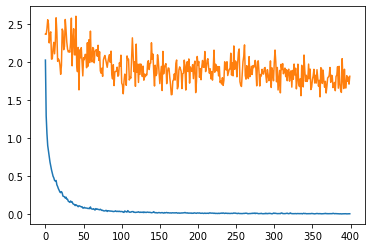

In [12]:
#코드작성
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(valid_loss)

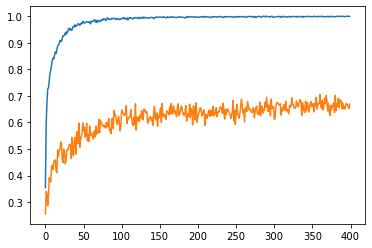

In [13]:
plt.plot(train_acc)
plt.plot(valid_acc)

## Step 7: Predict with Test Data 


### 예시 코드를 제공해 드립니다. 필요한 부분을 채워 사용하시거나 직접 코드를 작성 하셔도 됩니다

In [17]:
class test_dataset(Dataset):
    def __init__(self,imgpath,transform=None):
        
        self.imgpath = imgpath
        self.transform = transform
        
    def __len__(self):
        return len(self.imgpath)
    
    def __getitem__(self,idx):
        x = self.transform(Image.open(self.imgpath[idx]).convert('RGB'))
        
        return x

In [18]:
test_transform = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

### test dataset과 dataloader 생성

In [19]:
test_set = sorted(glob.glob('./imgs/test/*'))


test_data = test_dataset(test_set,test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, num_workers=0)

In [45]:
5.81506040e-08/2

2.9075302e-08

### Predict 수행

In [40]:
from tqdm import tqdm_notebook
import numpy as np
#코드작성(Test)

result = []
total_pred = np.zeros((604, 15))


print("Start Predict...\n\n")
for fold in range(5):
    model = USNet()
    model.to(device)
    model.load_state_dict(torch.load('./fold/model_fold_{}.pt'.format(fold)))     
    
    prediction = []
    for idx,data in tqdm_notebook(enumerate(test_loader)):
        pred = torch.zeros((test_loader.batch_size, 15)).to(device)
        # move tensors to GPU if CUDA is available
        data = data.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)
        pred = logits.softmax(1)
        prediction.append(pred.detach().cpu())
    
    prediction = torch.cat(prediction).numpy() 
    total_pred = np.add(total_pred, prediction)


total_pred = total_pred / 5
total_pred = total_pred.argmax(1)
result = total_pred.tolist()


print(len(result))
print(result)

print("\n\n...Finish!")

# pred 리스트 안에 Test image 순서대로 예측한 class index가 저장되도록 코드를 작성하시면 됩니다.

Start Predict...




<ipython-input-40-726444669510>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx,data in tqdm_notebook(enumerate(test_loader)):


0it [00:00, ?it/s]

0it [00:00, ?it/s]

[[1.56886369e-06 2.31410866e-03 3.97537474e-01 ... 7.90021159e-02
  3.04340710e-04 5.77756008e-02]
 [5.81506040e-08 4.60514888e-08 1.47101847e-08 ... 5.55641521e-07
  3.22955944e-09 1.01573686e-06]
 [2.18152940e-06 1.37954789e-06 2.82581717e-07 ... 4.54179305e-06
  5.75399716e-11 2.87795239e-08]
 ...
 [7.17428355e-01 2.18798559e-05 2.20505904e-05 ... 6.22956518e-05
  4.49516804e-03 4.78709105e-03]
 [5.51302931e-04 6.54882359e-05 6.71425878e-05 ... 6.42707690e-06
  1.21438345e-09 6.18756427e-07]
 [1.57830718e-08 4.16388837e-04 2.28864869e-05 ... 1.18378312e-02
  1.48234868e-01 9.19184567e-09]]
--------------
[[7.84431847e-07 1.15705433e-03 1.98768737e-01 ... 3.95010579e-02
  1.52170355e-04 2.88878004e-02]
 [2.90753020e-08 2.30257444e-08 7.35509237e-09 ... 2.77820761e-07
  1.61477972e-09 5.07868429e-07]
 [1.09076470e-06 6.89773946e-07 1.41290858e-07 ... 2.27089652e-06
  2.87699858e-11 1.43897620e-08]
 ...
 [3.58714178e-01 1.09399280e-05 1.10252952e-05 ... 3.11478259e-05
  2.24758402e-03 

예측 결과 인덱스를 저장한 pred 값을 사용해 클래스를 매칭하기 위한 class_name을 담아 놓은 리스트입니다.

주의할 점은 Train과정에서 사용된 class lable값과 같은 순서로 저장이 되어 있어야 한다는 점입니다

In [ ]:
class_names = train_data.classes
print(class_names)

In [ ]:
test_set[1]

In [ ]:
id=[]
category =[]
for i in range(len(test_set)):
    id.append(test_set[i].split('\\')[-1])
    category.append(class_names[result[i]])
pd.DataFrame({'Id':id,'Category':category}).to_csv('./fold/fold5_ensemble.csv',index=False)

print("Save Complete!")